In [24]:
import numpy
import numpy as np
import time
import datetime
import netCDF4
import matplotlib.pylab as plt
import os,sys,glob
sys.path.append(os.getcwd()+'/../adjust/rasotools/')
from utils import *
from multiprocessing import Pool
#import odb
from eccodes import *
from functools import partial
from collections import OrderedDict
import subprocess
import json
import gzip
# from retrieve_fb_jra55 import add_feedback
import copy
import pickle
import xarray as xr

import pandas as pd
import matplotlib
import matplotlib.pylab as plt
import matplotlib.pyplot as maplt
matplotlib.rcParams.update({'font.size': 20})

plt.rcParams['lines.linewidth'] = 3

import warnings
warnings.filterwarnings('ignore')

sys.path.append(os.getcwd()+'/../cds-backend/code/')
import cds_eua3 as eua
import trajectory as trj

In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [3]:
# run to convert the sh files to gaussian gridded gribs

# command = ''
# command += 'module load intel-parallel-studio/composer.2020.4-intel-20.0.4; '
# command += 'module load intel-mkl/2020.4.304-intel-20.0.4; '
# command += 'module load openmpi/4.0.5-intel-20.0.4; '
# command += 'module load hdf5/1.12.0-intel-20.0.4; '
# command += 'module load netcdf-c/4.7.4-intel-20.0.4; '
# command += 'module load eccodes/2.21.0-intel-20.0.4; '
# command += 'cd PROGRAMS/; '
# command += 'ulimit -s unlimited; '
# command += 'export OMP_NUM_THREADS=69; '
# base_command = command
# for i in range(1,13,1):
#     for j in range(1,32,1):
#         try:
#             command = base_command + './transsh.exe /mnt/scratch/scratch/mayerj47/era5_sh/t/2020/T3DSH2020'+f"{i:02d}"+f"{j:02d}"+'0000.grib ./2020/T3DSH2020'+f"{i:02d}"+f"{j:02d}"+'0000.grib; '
#             command += './transsh.exe /scratch/das/mayerj47/era5_sh/lnspana/2020/LNSPANASH2020'+f"{i:02d}"+f"{j:02d}"+'0000.grib ./2020/LNSPANASH2020'+f"{i:02d}"+f"{j:02d}"+'0000.grib'
#             os.system(command)
#         except:
#             print(i, j)

In [4]:
stat = '11035'
statlist = glob.glob('/mnt/users/scratch/leo/scratch/converted_v7/*' + stat + '*_CEUAS_merged_v1.nc')
df = eua.CDMDataset(filename = statlist[0]).to_dataframe(groups=['observations_table', 'era5fb'], variables=['latitude', 'longitude', 'observed_variable', 'observation_value', 'z_coordinate', 'date_time', 'fg_depar@body', 'an_depar@body', 'biascorr@body'])
# 2020 only
df = df[df.date_time.dt.year == 2020]
# night only -> ~ 00:00
df = df[np.isin(df.date_time.dt.hour,[23,0,1])]

In [5]:
df['biascorr@body'].drop_duplicates()

2917049     NaN
26311513    0.0
Name: biascorr@body, dtype: float32

lat:  48.24895 lon:  16.35687
11035
2020-01-01 23:30:34


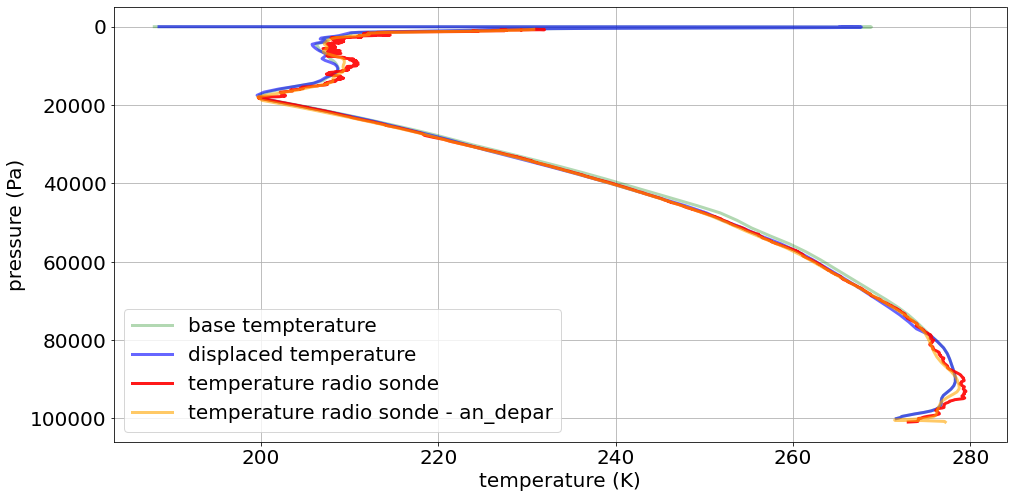

lat:  48.24895 lon:  16.35718
11035
2020-01-02 23:30:47


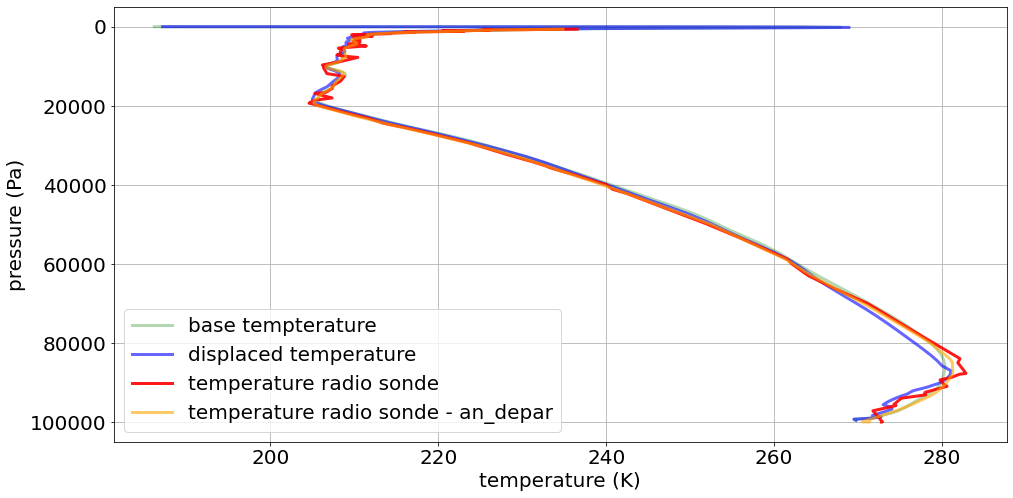

lat:  48.24895 lon:  16.35718
11035
2020-01-03 23:30:15


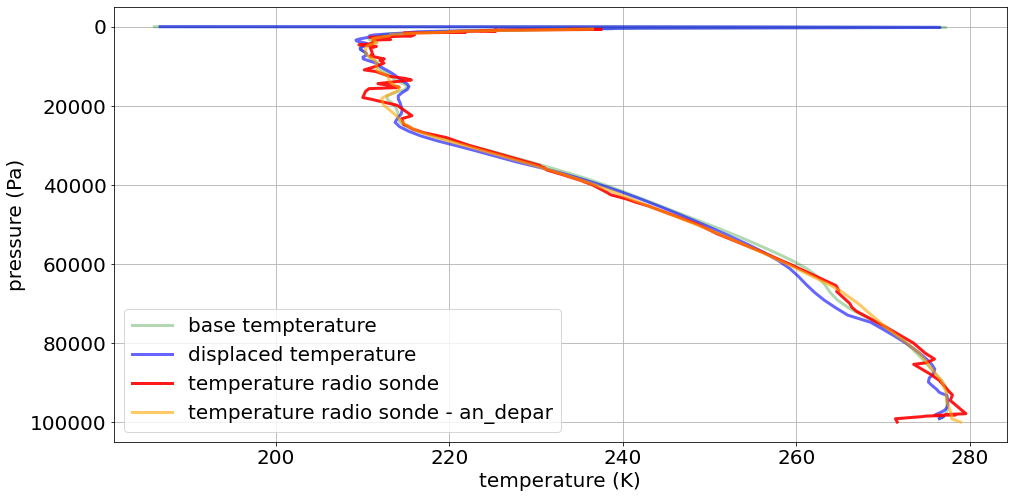

rmse_shbase_sonde - plev:  92500  RMSE:  1.0317233220400182
rmse_shbase_adjsonde - plev:  92500  RMSE:  1.0791759716545903
rmse_shdisp_sonde - plev:  92500  RMSE:  1.360891281194228
rmse_shdisp_adjsonde - plev:  92500  RMSE:  2.4371348514810256
rms_shbase - plev:  92500  RMS:  278.0500272203657
rms_adjsonde - plev:  92500  RMS:  278.803439002886
rms_sonde - plev:  92500  RMS:  278.31416611490994
rms_shdisp - plev:  92500  RMS:  276.9573823825632
rmse_shbase_sonde - plev:  85000  RMSE:  1.0556253987235902
rmse_shbase_adjsonde - plev:  85000  RMSE:  1.0681457263229692
rmse_shdisp_sonde - plev:  85000  RMSE:  1.5375300580620184
rmse_shdisp_adjsonde - plev:  85000  RMSE:  0.9482744070743683
rms_shbase - plev:  85000  RMS:  277.6764139842236
rms_adjsonde - plev:  85000  RMS:  277.0309319912471
rms_sonde - plev:  85000  RMS:  277.95188833500623
rms_shdisp - plev:  85000  RMS:  277.5757810726459
rmse_shbase_sonde - plev:  70000  RMSE:  0.8736679158576863
rmse_shbase_adjsonde - plev:  70000  R

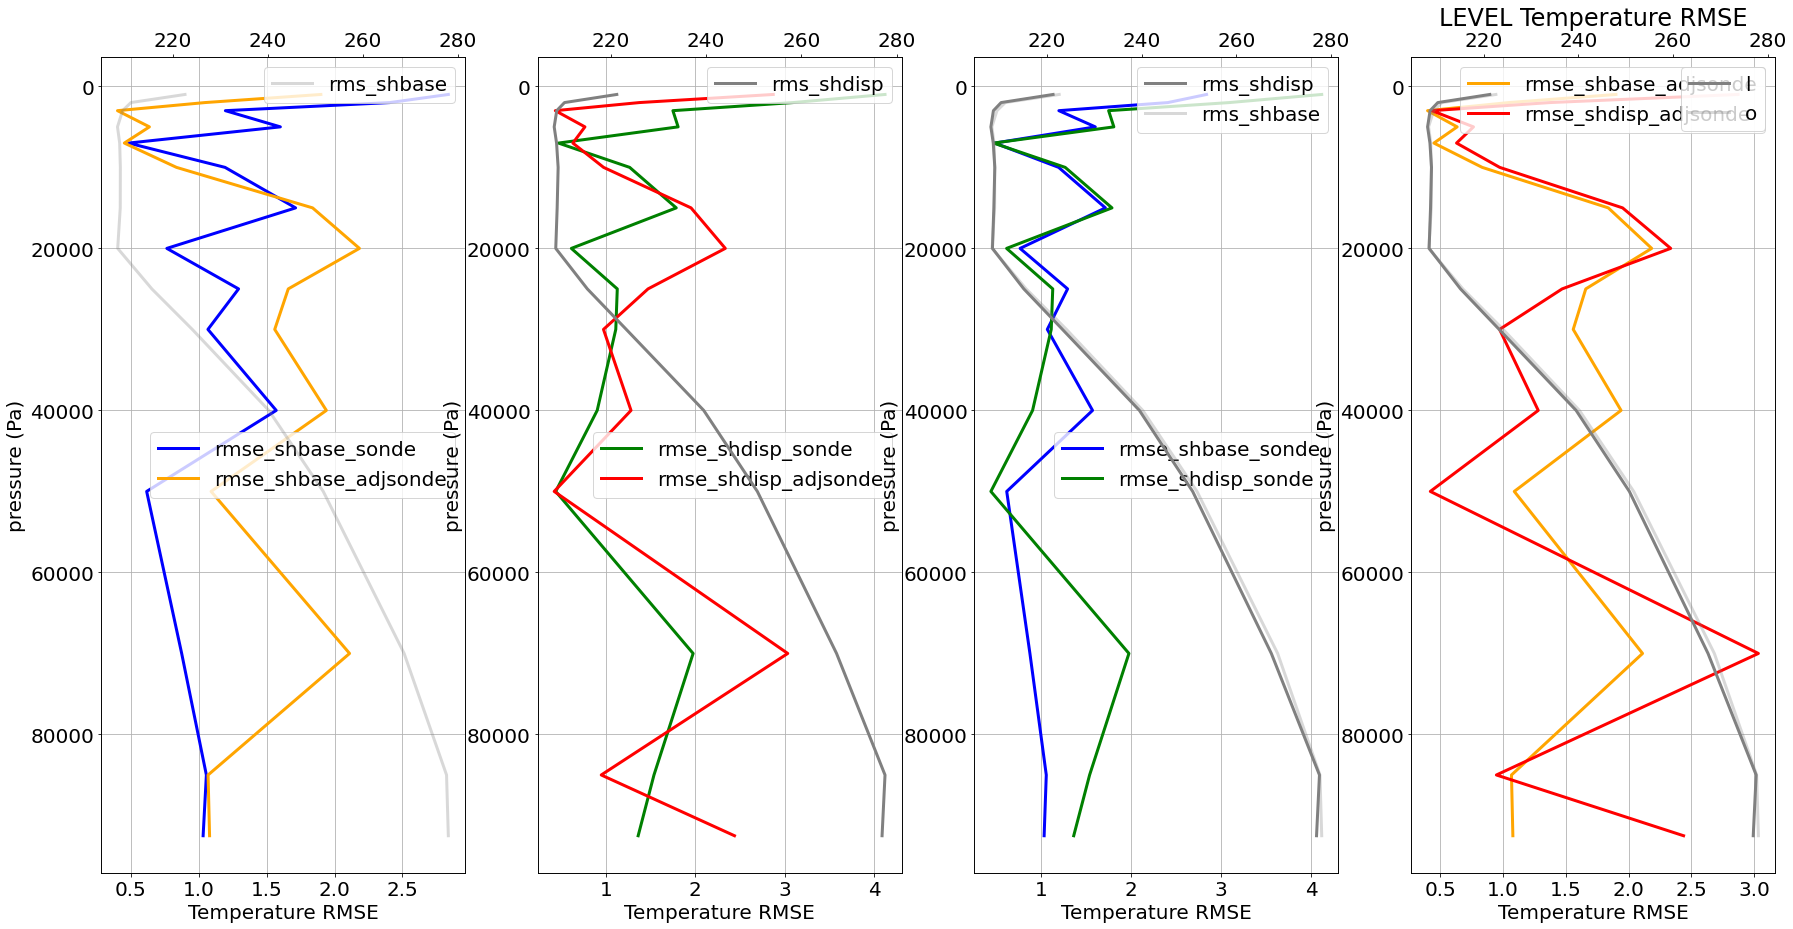

In [30]:
stat = '11035'
statlist = glob.glob('/mnt/users/scratch/leo/scratch/converted_v7/*' + stat + '*_CEUAS_merged_v1.nc')
df = eua.CDMDataset(filename = statlist[0]).to_dataframe(groups=['observations_table', 'era5fb'], variables=['latitude', 'longitude', 'observed_variable', 'observation_value', 'z_coordinate', 'date_time', 'fg_depar@body', 'an_depar@body'])
# 2020 only
df = df[df.date_time.dt.year == 2020]
# night only -> ~ 00:00
df = df[np.isin(df.date_time.dt.hour,[23,0,1])]

from scipy.signal import savgol_filter
stdplevs = [92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]
rmse_sum_shbase_sonde={}
rmse_sum_shbase_adjsonde={}
rmse_sum_shdisp_sonde={}
rmse_sum_shdisp_adjsonde={}
rms_sum_shbase={}
rms_sum_adjsonde={}
rms_sum_sonde={}
rms_sum_shdisp={}

for i in stdplevs:
    rmse_sum_shbase_sonde[i] = []
    rmse_sum_shbase_adjsonde[i] = []
    rmse_sum_shdisp_sonde[i] = []
    rmse_sum_shdisp_adjsonde[i] = []
    rms_sum_shbase[i] = []
    rms_sum_adjsonde[i] = []
    rms_sum_sonde[i] = []
    rms_sum_shdisp[i] = []

for day in df.date_time.drop_duplicates()[:3]:
    test = df[df.date_time == day]

    t = test[test.observed_variable == 85]
    t = t.rename(columns={'observation_value':'temperature'})
    t = t.drop(columns='observed_variable')

    u = test[test.observed_variable == 104]
    u = u.rename(columns={'observation_value':'u'})
    u = u.drop(columns=['observed_variable', 'fg_depar@body', 'an_depar@body'])

    v = test[test.observed_variable == 105]
    v = v.rename(columns={'observation_value':'v'})
    v = v.drop(columns=['observed_variable', 'fg_depar@body', 'an_depar@body'])

    input_data = pd.merge(t, u, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])
    input_data = pd.merge(input_data, v, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])

    input_data = input_data.dropna()
    phys_model = trj.trajectory(lat=t.latitude.iloc[0], lon=t.longitude.iloc[0], temperature=np.array(input_data.temperature), u=np.array(input_data.u), v=np.array(input_data.v), pressure=np.array(input_data.z_coordinate))


    input_data = input_data.reindex(index=input_data.index[::-1])
    input_data['z'] = np.array(trj.calc_height(np.array(input_data.temperature), np.array(input_data.z_coordinate), jump=False))
    input_data['calc_latd'] = np.array(phys_model[0])
    input_data['calc_lond'] = np.array(phys_model[1])

    test1 = [0] + list(input_data.calc_lond[:-1])
    test2 = [0] + list(input_data.calc_latd[:-1])
    input_data['prev_calc_lond']= test1
    input_data['prev_calc_latd']= test2

    input_data['lat_diff'] = np.array(input_data.calc_latd)- np.array(input_data.prev_calc_latd)
    input_data['lon_diff'] = np.array(input_data.calc_lond)- np.array(input_data.prev_calc_lond)


    input_data = input_data.dropna()


    with open('model_dt_4s_reduced_prev.p', "rb") as input_file:
        model = pickle.load(input_file)

    out = model.predict(input_data[['temperature', 'z_coordinate', 'u', 'v', 'z','latitude', 'longitude' , 'calc_latd', 'calc_lond', 'prev_calc_lond', 'prev_calc_latd', 'lon_diff', 'lat_diff']])

    ml_latd, ml_lond = out.transpose()
    filterlen = int(len(ml_latd)//2)
    if not (filterlen & 0x1):
        filterlen += 1
    input_data['ml_latd'] = np.array(savgol_filter(ml_latd, filterlen, 3))
    input_data['ml_lond'] = np.array(savgol_filter(ml_lond, filterlen, 3))

    input_data = input_data.reset_index()


    ds = xr.load_dataset("./PROGRAMS/"+str(day.year)+"/T3DSH"+str(day.year)+f"{day.month:02d}"+f"{day.day+1:02d}"+"0000.grib")
    ds_lnsp = xr.load_dataset("./PROGRAMS/"+str(day.year)+"/LNSPANASH"+str(day.year)+f"{day.month:02d}"+f"{day.day+1:02d}"+"0000.grib")



    igrib = '/scratch/das/mayerj47/era5_sh/lnspana/'+str(day.year)+'/LNSPANASH'+str(day.year)+f"{day.month:02d}"+f"{day.day:02d}"+'0000.grib'
    f = open(igrib)
#     print(f)
    msgid = codes_new_from_file(f, product_kind=CODES_PRODUCT_GRIB)
#     print(msgid)
    pv = codes_get_array(msgid,'pv')

    lnsp = float(ds_lnsp.sel(latitude=[input_data.latitude[0]], longitude=[input_data.longitude[0]], method="nearest").lnsp)
    sp = np.exp(lnsp)

    pv = np.array(pv)
    a = pv[:int(len(pv)/2)]
    b = pv[int(len(pv)/2):]

    p_half = a + b * sp
    base_t = ds.sel(latitude=[input_data.latitude[0]], longitude=[input_data.longitude[0]], method="nearest").t

    t_list = []
    for i in range(len(p_half[:-1])):
        step = find_nearest(input_data.z_coordinate, p_half[i])
        input_data_step = input_data[input_data.z_coordinate == step]
        station_lat = float(input_data.latitude[0]) + np.array(input_data_step.ml_latd)[0]
    #     print(station_lat)
        station_lon = float(input_data.longitude[0]) + np.array(input_data_step.ml_lond)[0]

        ds_now = ds.sel(latitude=[station_lat], longitude=[station_lon], method="nearest")
    #     print('selected lat: ', float(ds_now.latitude))
        t = ds_now.t
        t_list.append(np.array(t)[i][0][0])
    print('lat: ', input_data.latitude[0], 'lon: ', input_data.longitude[0])
    print(stat)
    print(day)
    for i in range(len(stdplevs)):
        if np.abs(stdplevs[i] - find_nearest(p_half[:-1],stdplevs[i])) > 1000:
            print(stdplevs[i] , find_nearest(p_half[:-1],stdplevs[i]))
            rmse_sum_shbase_sonde[stdplevs[i]].append(np.nan)
            rmse_sum_shbase_adjsonde[stdplevs[i]].append(np.nan)
            rmse_sum_shdisp_sonde[stdplevs[i]].append(np.nan)
            rmse_sum_shdisp_adjsonde[stdplevs[i]].append(np.nan)
            rms_sum_shbase[stdplevs[i]].append(np.nan)
            rms_sum_adjsonde[stdplevs[i]].append(np.nan)
            rms_sum_sonde[stdplevs[i]].append(np.nan)
            rms_sum_shdisp[stdplevs[i]].append(np.nan)
        else:
            sq_t = np.squeeze(t)
            t_base = float(sq_t[p_half[:-1] == find_nearest(p_half[:-1],stdplevs[i])])
            t_disp = float(np.array(t_list)[p_half[:-1] == find_nearest(p_half[:-1],stdplevs[i])])
            input_data_step = input_data[input_data.z_coordinate == find_nearest(input_data.z_coordinate, stdplevs[i])]
            t_sonde = float(input_data_step.temperature)
            t_adjsonde = float(input_data_step.temperature) - float(input_data_step['fg_depar@body']) - float(input_data_step['an_depar@body'])
            rmse_sum_shbase_sonde[stdplevs[i]].append(t_base - t_sonde)
            rmse_sum_shbase_adjsonde[stdplevs[i]].append(t_base - t_adjsonde)
            rmse_sum_shdisp_sonde[stdplevs[i]].append(t_disp - t_sonde)
            rmse_sum_shdisp_adjsonde[stdplevs[i]].append(t_disp - t_adjsonde)
            rms_sum_shbase[stdplevs[i]].append(t_base)
            rms_sum_adjsonde[stdplevs[i]].append(t_adjsonde)
            rms_sum_sonde[stdplevs[i]].append(t_sonde)
            rms_sum_shdisp[stdplevs[i]].append(t_disp)
        
        
    fig, ax1 = maplt.subplots(1, figsize=(16, 8))
    ax1.plot(np.squeeze(t), np.array(p_half[:-1]), color = 'green', alpha = 0.3, label='base tempterature')
    ax1.plot(np.array(t_list), np.array(p_half[:-1]), color = 'blue', alpha = 0.6, label='displaced temperature')
    ax1.plot(np.array(input_data.temperature), np.array(input_data.z_coordinate), color = 'red', alpha = 0.9, label='temperature radio sonde')
    ax1.plot(np.array(input_data.temperature - input_data['an_depar@body'] ), np.array(input_data.z_coordinate), color = 'orange', alpha = 0.6, label='temperature radio sonde - an_depar')
    ax1.set_ylabel('pressure (Pa)')
    ax1.set_xlabel('temperature (K)')
    ax1.tick_params(axis='y')
    ax1.set_ylim(ax1.get_ylim()[::-1])
    ax1.legend()
    ax1.grid()
    maplt.show()
    maplt.close()

rmse_shbase_sonde=[]
rmse_shbase_adjsonde=[]
rmse_shdisp_sonde=[]
rmse_shdisp_adjsonde=[]

rms_shbase=[]
rms_adjsonde=[]
rms_sonde=[]
rms_shdisp=[]

for i in range(len(stdplevs)):
    rmse_shbase_sonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shbase_sonde[stdplevs[i]])**2))))
    print('rmse_shbase_sonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shbase_sonde[-1])
    rmse_shbase_adjsonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shbase_adjsonde[stdplevs[i]])**2))))
    print('rmse_shbase_adjsonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shbase_adjsonde[-1])
    rmse_shdisp_sonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shdisp_sonde[stdplevs[i]])**2))))
    print('rmse_shdisp_sonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shdisp_sonde[-1])
    rmse_shdisp_adjsonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shdisp_adjsonde[stdplevs[i]])**2))))
    print('rmse_shdisp_adjsonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shdisp_adjsonde[-1])
    
    rms_shbase.append(np.sqrt(np.nanmean((np.array(rms_sum_shbase[stdplevs[i]])**2))))
    print('rms_shbase - plev: ', stdplevs[i], ' RMS: ', rms_shbase[-1])
    rms_adjsonde.append(np.sqrt(np.nanmean((np.array(rms_sum_adjsonde[stdplevs[i]])**2))))
    print('rms_adjsonde - plev: ', stdplevs[i], ' RMS: ', rms_adjsonde[-1])
    rms_sonde.append(np.sqrt(np.nanmean((np.array(rms_sum_sonde[stdplevs[i]])**2))))
    print('rms_sonde - plev: ', stdplevs[i], ' RMS: ', rms_sonde[-1])
    rms_shdisp.append(np.sqrt(np.nanmean((np.array(rms_sum_shdisp[stdplevs[i]])**2))))
    print('rms_shdisp - plev: ', stdplevs[i], ' RMS: ', rms_shdisp[-1])

print('')
# fig, ax1 = maplt.subplots(1,4,figsize = (30,15))

# ax1[0].plot(np.array(rmse_shbase_sonde),stdplevs,color = 'blue', label='rmse_shbase_sonde')
# ax1[0].plot(np.array(rmse_shbase_adjsonde),stdplevs,color='orange', label='rmse_shbase_adjsonde')
# # ax1[0].plot(np.array(rmse_shdisp_sonde),stdplevs, label='rmse_shdisp_sonde')
# # ax1[0].plot(np.array(rmse_shdisp_adjsonde),stdplevs, label='rmse_shdisp_adjsonde')
# ax1_1 = ax1[0].twiny()
# ax1_1.plot(np.array(rms_shbase),stdplevs,color='grey',alpha=0.3, label='rms_shbase')
# ax1_1.legend()
# ax1[0].set_ylim(ax1[0].get_ylim()[::-1])
# ax1[0].set_ylabel('pressure (Pa)')
# ax1[0].set_xlabel('Temperature RMSE')
# ax1[0].legend()
# ax1[0].grid()

# # ax1[1].plot(np.array(rmse_shbase_sonde),stdplevs, label='rmse_shbase_sonde')
# # ax1[1].plot(np.array(rmse_shbase_adjsonde),stdplevs, label='rmse_shbase_adjsonde')
# ax1[1].plot(np.array(rmse_shdisp_sonde),stdplevs, color='green', label='rmse_shdisp_sonde')
# ax1[1].plot(np.array(rmse_shdisp_adjsonde),stdplevs, color='red', label='rmse_shdisp_adjsonde')
# ax1_2 = ax1[1].twiny()
# ax1_2.plot(np.array(rms_shdisp),stdplevs,color='grey', label='rms_shdisp')
# ax1_2.legend()
# ax1[1].set_ylim(ax1[1].get_ylim()[::-1])
# ax1[1].set_ylabel('pressure (Pa)')
# ax1[1].set_xlabel('Temperature RMSE')
# ax1[1].legend()
# ax1[1].grid()

# ax1[2].plot(np.array(rmse_shbase_sonde),stdplevs,color = 'blue', label='rmse_shbase_sonde')
# ax1[2].plot(np.array(rmse_shdisp_sonde),stdplevs, color='green', label='rmse_shdisp_sonde')
# ax1_3 = ax1[2].twiny()
# ax1_3.plot(np.array(rms_shdisp),stdplevs,color='grey', label='rms_shdisp')
# ax1_3.plot(np.array(rms_shbase),stdplevs,color='grey',alpha=0.3, label='rms_shbase')
# ax1_3.legend()
# ax1[2].set_ylim(ax1[2].get_ylim()[::-1])
# ax1[2].set_ylabel('pressure (Pa)')
# ax1[2].set_xlabel('Temperature RMSE')
# ax1[2].legend()
# ax1[2].grid()

# ax1[3].plot(np.array(rmse_shbase_adjsonde),stdplevs,color='orange', label='rmse_shbase_adjsonde')
# ax1[3].plot(np.array(rmse_shdisp_adjsonde),stdplevs, color='red', label='rmse_shdisp_adjsonde')
# ax1_4 = ax1[3].twiny()
# ax1_4.plot(np.array(rms_shdisp),stdplevs,color='grey', label='rms_shdisp')
# ax1_4.plot(np.array(rms_shbase),stdplevs,color='grey',alpha=0.3, label='rms_shbase')
# ax1_4.legend('lower left')
# ax1[3].set_ylim(ax1[3].get_ylim()[::-1])
# ax1[3].set_ylabel('pressure (Pa)')
# ax1[3].set_xlabel('Temperature RMSE')
# ax1[3].legend(loc='upper right')
# ax1[3].grid()

# maplt.title('LEVEL Temperature RMSE')
# maplt.show()
# maplt.close()

fig, ax1 = maplt.subplots(figsize = (15,10))
ax1.plot(np.array(rmse_shbase_adjsonde),stdplevs,color='orange', label='rmse_shbase_adjsonde')
ax1.plot(np.array(rmse_shdisp_adjsonde),stdplevs, color='red', label='rmse_shdisp_adjsonde')
ax1_4 = ax1.twiny()
ax1_4.plot(np.array(rms_shdisp),stdplevs,color='grey', label='rms_shdisp')
ax1_4.plot(np.array(rms_shbase),stdplevs,color='grey',alpha=0.3, label='rms_shbase')
ax1_4.legend(loc='lower left')
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.set_ylabel('pressure (Pa)')
ax1.set_xlabel('Temperature RMSE')
ax1.legend('upper right')
ax1.grid()

maplt.title('LEVEL Temperature RMSE')
maplt.show()
maplt.close()

lat:  48.24895 lon:  16.35687
11035
2020-01-01 23:30:34
lat:  48.24895 lon:  16.35718
11035
2020-01-02 23:30:47
lat:  48.24895 lon:  16.35718
11035
2020-01-03 23:30:15
rmse_shbase_sonde - plev:  92500  RMSE:  3.91762868093767
rmse_shbase_adjsonde - plev:  92500  RMSE:  3.895311468614804
rmse_shdisp_sonde - plev:  92500  RMSE:  3.9058666907436956
rmse_shdisp_adjsonde - plev:  92500  RMSE:  3.88684458095416
rms_shbase - plev:  92500  RMS:  276.64103162218606
rms_adjsonde - plev:  92500  RMS:  278.803439002886
rms_sonde - plev:  92500  RMS:  278.31416611490994
rms_shdisp - plev:  92500  RMS:  275.6684889825492
rmse_shbase_sonde - plev:  85000  RMSE:  5.317438954021053
rmse_shbase_adjsonde - plev:  85000  RMSE:  4.171171438600705
rmse_shdisp_sonde - plev:  85000  RMSE:  5.277002531598967
rmse_shdisp_adjsonde - plev:  85000  RMSE:  4.191016587712484
rms_shbase - plev:  85000  RMS:  276.12663741488956
rms_adjsonde - plev:  85000  RMS:  277.0309319912471
rms_sonde - plev:  85000  RMS:  277.95

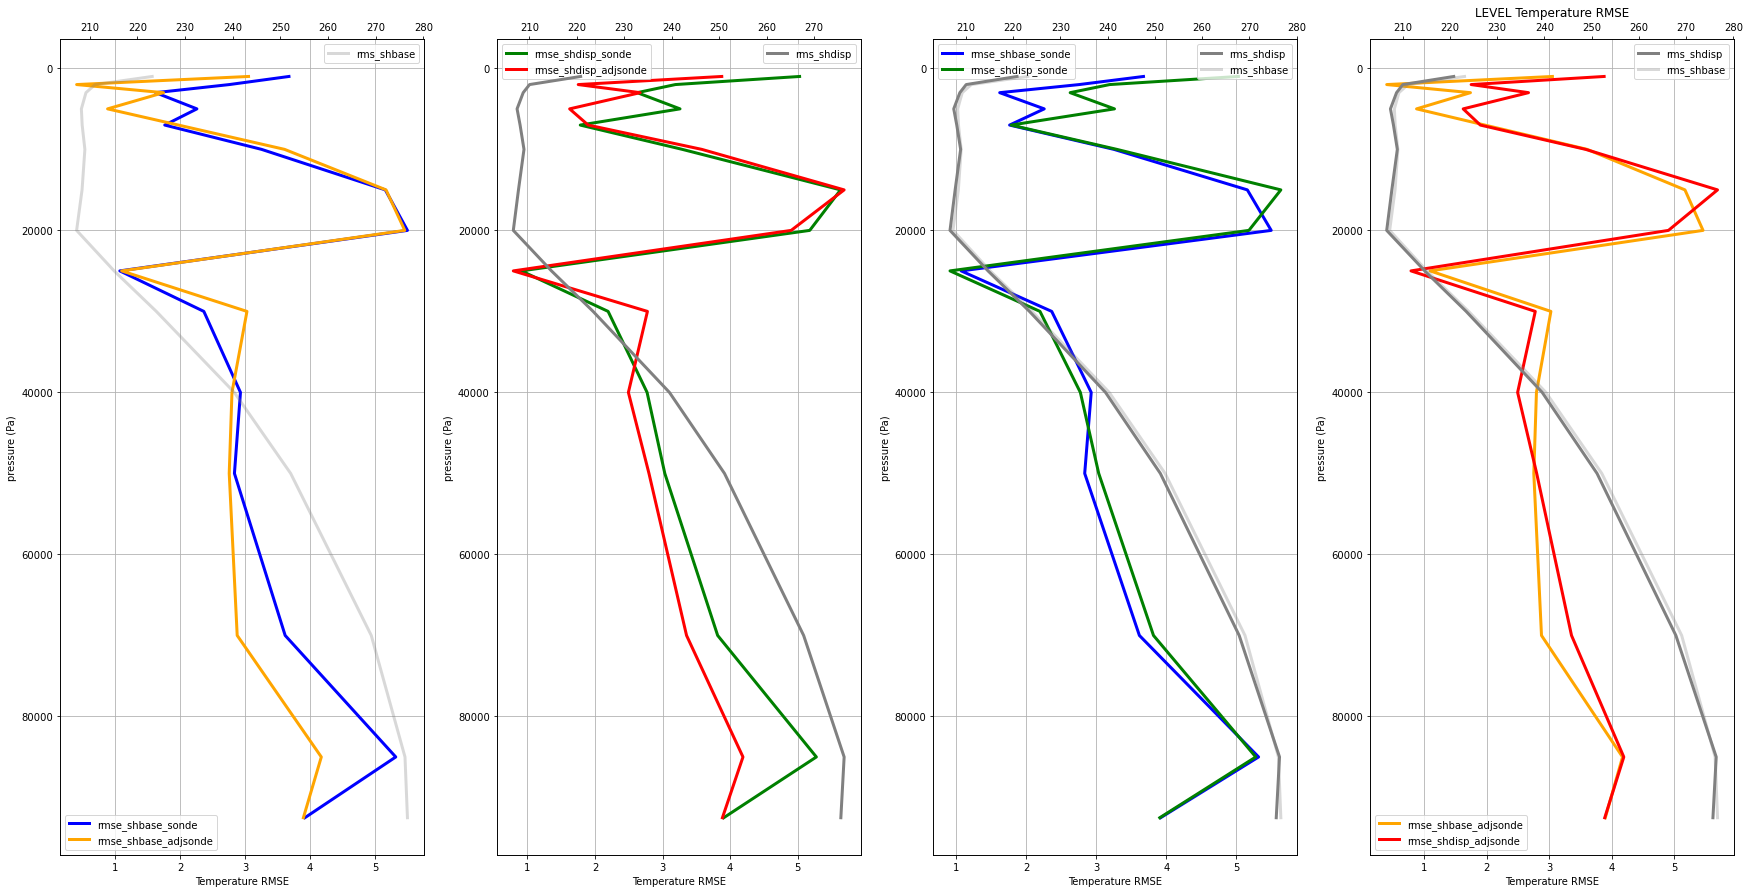

In [15]:
stat = '11035'
statlist = glob.glob('/mnt/users/scratch/leo/scratch/converted_v7/*' + stat + '*_CEUAS_merged_v1.nc')
df = eua.CDMDataset(filename = statlist[0]).to_dataframe(groups=['observations_table', 'era5fb'], variables=['latitude', 'longitude', 'observed_variable', 'observation_value', 'z_coordinate', 'date_time', 'fg_depar@body', 'an_depar@body'])
# 2020 only
df = df[df.date_time.dt.year == 2020]
# night only -> ~ 00:00
df = df[np.isin(df.date_time.dt.hour,[23,0,1])]

from scipy.signal import savgol_filter
stdplevs = [92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]
rmse_sum_shbase_sonde={}
rmse_sum_shbase_adjsonde={}
rmse_sum_shdisp_sonde={}
rmse_sum_shdisp_adjsonde={}
rms_sum_shbase={}
rms_sum_adjsonde={}
rms_sum_sonde={}
rms_sum_shdisp={}

for i in stdplevs:
    rmse_sum_shbase_sonde[i] = []
    rmse_sum_shbase_adjsonde[i] = []
    rmse_sum_shdisp_sonde[i] = []
    rmse_sum_shdisp_adjsonde[i] = []
    rms_sum_shbase[i] = []
    rms_sum_adjsonde[i] = []
    rms_sum_sonde[i] = []
    rms_sum_shdisp[i] = []

for day in df.date_time.drop_duplicates()[:3]:
    test = df[df.date_time == day]

    t = test[test.observed_variable == 85]
    t = t.rename(columns={'observation_value':'temperature'})
    t = t.drop(columns='observed_variable')

    u = test[test.observed_variable == 104]
    u = u.rename(columns={'observation_value':'u'})
    u = u.drop(columns=['observed_variable', 'fg_depar@body', 'an_depar@body'])

    v = test[test.observed_variable == 105]
    v = v.rename(columns={'observation_value':'v'})
    v = v.drop(columns=['observed_variable', 'fg_depar@body', 'an_depar@body'])

    input_data = pd.merge(t, u, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])
    input_data = pd.merge(input_data, v, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])

    input_data = input_data.dropna()
    phys_model = trj.trajectory(lat=t.latitude.iloc[0], lon=t.longitude.iloc[0], temperature=np.array(input_data.temperature), u=np.array(input_data.u), v=np.array(input_data.v), pressure=np.array(input_data.z_coordinate))


    input_data = input_data.reindex(index=input_data.index[::-1])
    input_data['z'] = np.array(trj.calc_height(np.array(input_data.temperature), np.array(input_data.z_coordinate), jump=False))
    input_data['calc_latd'] = np.array(phys_model[0])
    input_data['calc_lond'] = np.array(phys_model[1])

    test1 = [0] + list(input_data.calc_lond[:-1])
    test2 = [0] + list(input_data.calc_latd[:-1])
    input_data['prev_calc_lond']= test1
    input_data['prev_calc_latd']= test2

    input_data['lat_diff'] = np.array(input_data.calc_latd)- np.array(input_data.prev_calc_latd)
    input_data['lon_diff'] = np.array(input_data.calc_lond)- np.array(input_data.prev_calc_lond)


    input_data = input_data.dropna()


    with open('model_dt_4s_reduced_prev.p', "rb") as input_file:
        model = pickle.load(input_file)

    out = model.predict(input_data[['temperature', 'z_coordinate', 'u', 'v', 'z','latitude', 'longitude' , 'calc_latd', 'calc_lond', 'prev_calc_lond', 'prev_calc_latd', 'lon_diff', 'lat_diff']])

    ml_latd, ml_lond = out.transpose()
    filterlen = int(len(ml_latd)//2)
    if not (filterlen & 0x1):
        filterlen += 1
    input_data['ml_latd'] = np.array(savgol_filter(ml_latd, filterlen, 3))
    input_data['ml_lond'] = np.array(savgol_filter(ml_lond, filterlen, 3))

    input_data = input_data.reset_index()


    ds = xr.load_dataset("./PROGRAMS/"+str(day.year)+"/T3DSH"+str(day.year)+f"{day.month:02d}"+f"{day.day:02d}"+"0000.grib")
    ds_lnsp = xr.load_dataset("./PROGRAMS/"+str(day.year)+"/LNSPANASH"+str(day.year)+f"{day.month:02d}"+f"{day.day:02d}"+"0000.grib")



    igrib = '/scratch/das/mayerj47/era5_sh/lnspana/'+str(day.year)+'/LNSPANASH'+str(day.year)+f"{day.month:02d}"+f"{day.day:02d}"+'0000.grib'
    f = open(igrib)
#     print(f)
    msgid = codes_new_from_file(f, product_kind=CODES_PRODUCT_GRIB)
#     print(msgid)
    pv = codes_get_array(msgid,'pv')

    lnsp = float(ds_lnsp.sel(latitude=[input_data.latitude[0]], longitude=[input_data.longitude[0]], method="nearest").lnsp)
    sp = np.exp(lnsp)

    pv = np.array(pv)
    a = pv[:int(len(pv)/2)]
    b = pv[int(len(pv)/2):]

    p_half = a + b * sp
    base_t = ds.sel(latitude=[input_data.latitude[0]], longitude=[input_data.longitude[0]], method="nearest").t

    t_list = []
    for i in range(len(p_half[:-1])):
        step = find_nearest(input_data.z_coordinate, p_half[i])
        input_data_step = input_data[input_data.z_coordinate == step]
        station_lat = float(input_data.latitude[0]) + np.array(input_data_step.ml_latd)[0]
    #     print(station_lat)
        station_lon = float(input_data.longitude[0]) + np.array(input_data_step.ml_lond)[0]

        ds_now = ds.sel(latitude=[station_lat], longitude=[station_lon], method="nearest")
    #     print('selected lat: ', float(ds_now.latitude))
        t = ds_now.t
        t_list.append(np.array(t)[i][0][0])
    print('lat: ', input_data.latitude[0], 'lon: ', input_data.longitude[0])
    print(stat)
    print(day)
    for i in range(len(stdplevs)):
        if np.abs(stdplevs[i] - find_nearest(p_half[:-1],stdplevs[i])) > 1000:
            print(stdplevs[i] , find_nearest(p_half[:-1],stdplevs[i]))
            rmse_sum_shbase_sonde[stdplevs[i]].append(np.nan)
            rmse_sum_shbase_adjsonde[stdplevs[i]].append(np.nan)
            rmse_sum_shdisp_sonde[stdplevs[i]].append(np.nan)
            rmse_sum_shdisp_adjsonde[stdplevs[i]].append(np.nan)
            rms_sum_shbase[stdplevs[i]].append(np.nan)
            rms_sum_adjsonde[stdplevs[i]].append(np.nan)
            rms_sum_sonde[stdplevs[i]].append(np.nan)
            rms_sum_shdisp[stdplevs[i]].append(np.nan)
        else:
            sq_t = np.squeeze(t)
            t_base = float(sq_t[p_half[:-1] == find_nearest(p_half[:-1],stdplevs[i])])
            t_disp = float(np.array(t_list)[p_half[:-1] == find_nearest(p_half[:-1],stdplevs[i])])
            input_data_step = input_data[input_data.z_coordinate == find_nearest(input_data.z_coordinate, stdplevs[i])]
            t_sonde = float(input_data_step.temperature)
            t_adjsonde = float(input_data_step.temperature) - float(input_data_step['fg_depar@body']) - float(input_data_step['an_depar@body'])
            rmse_sum_shbase_sonde[stdplevs[i]].append(t_base - t_sonde)
            rmse_sum_shbase_adjsonde[stdplevs[i]].append(t_base - t_adjsonde)
            rmse_sum_shdisp_sonde[stdplevs[i]].append(t_disp - t_sonde)
            rmse_sum_shdisp_adjsonde[stdplevs[i]].append(t_disp - t_adjsonde)
            rms_sum_shbase[stdplevs[i]].append(t_base)
            rms_sum_adjsonde[stdplevs[i]].append(t_adjsonde)
            rms_sum_sonde[stdplevs[i]].append(t_sonde)
            rms_sum_shdisp[stdplevs[i]].append(t_disp)
        
        
#     fig, ax1 = maplt.subplots(1, figsize=(16, 8))
#     ax1.plot(np.squeeze(t), np.array(p_half[:-1]), color = 'green', alpha = 0.3, label='base tempterature')
#     ax1.plot(np.array(t_list), np.array(p_half[:-1]), color = 'blue', alpha = 0.6, label='displaced temperature')
#     ax1.plot(np.array(input_data.temperature), np.array(input_data.z_coordinate), color = 'red', alpha = 0.3, label='temperature radio sonde')
#     ax1.plot(np.array(input_data.temperature - input_data['fg_depar@body'] - input_data['an_depar@body'] ), np.array(input_data.z_coordinate), color = 'orange', alpha = 0.6, label='temperature radio sonde - adjusted')
#     ax1.set_ylabel('pressure (Pa)')
#     ax1.set_xlabel('temperature (K)')
#     ax1.tick_params(axis='y')
#     ax1.set_ylim(ax1.get_ylim()[::-1])
#     ax1.legend()
#     ax1.grid()
#     maplt.show()
#     maplt.close()

rmse_shbase_sonde=[]
rmse_shbase_adjsonde=[]
rmse_shdisp_sonde=[]
rmse_shdisp_adjsonde=[]

rms_shbase=[]
rms_adjsonde=[]
rms_sonde=[]
rms_shdisp=[]

for i in range(len(stdplevs)):
    rmse_shbase_sonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shbase_sonde[stdplevs[i]])**2))))
    print('rmse_shbase_sonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shbase_sonde[-1])
    rmse_shbase_adjsonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shbase_adjsonde[stdplevs[i]])**2))))
    print('rmse_shbase_adjsonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shbase_adjsonde[-1])
    rmse_shdisp_sonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shdisp_sonde[stdplevs[i]])**2))))
    print('rmse_shdisp_sonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shdisp_sonde[-1])
    rmse_shdisp_adjsonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shdisp_adjsonde[stdplevs[i]])**2))))
    print('rmse_shdisp_adjsonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shdisp_adjsonde[-1])
    
    rms_shbase.append(np.sqrt(np.nanmean((np.array(rms_sum_shbase[stdplevs[i]])**2))))
    print('rms_shbase - plev: ', stdplevs[i], ' RMS: ', rms_shbase[-1])
    rms_adjsonde.append(np.sqrt(np.nanmean((np.array(rms_sum_adjsonde[stdplevs[i]])**2))))
    print('rms_adjsonde - plev: ', stdplevs[i], ' RMS: ', rms_adjsonde[-1])
    rms_sonde.append(np.sqrt(np.nanmean((np.array(rms_sum_sonde[stdplevs[i]])**2))))
    print('rms_sonde - plev: ', stdplevs[i], ' RMS: ', rms_sonde[-1])
    rms_shdisp.append(np.sqrt(np.nanmean((np.array(rms_sum_shdisp[stdplevs[i]])**2))))
    print('rms_shdisp - plev: ', stdplevs[i], ' RMS: ', rms_shdisp[-1])

print('')
fig, ax1 = maplt.subplots(1,4,figsize = (30,15))

ax1[0].plot(np.array(rmse_shbase_sonde),stdplevs,color = 'blue', label='rmse_shbase_sonde')
ax1[0].plot(np.array(rmse_shbase_adjsonde),stdplevs,color='orange', label='rmse_shbase_adjsonde')
# ax1[0].plot(np.array(rmse_shdisp_sonde),stdplevs, label='rmse_shdisp_sonde')
# ax1[0].plot(np.array(rmse_shdisp_adjsonde),stdplevs, label='rmse_shdisp_adjsonde')
ax1_1 = ax1[0].twiny()
ax1_1.plot(np.array(rms_shbase),stdplevs,color='grey',alpha=0.3, label='rms_shbase')
ax1_1.legend()
ax1[0].set_ylim(ax1[0].get_ylim()[::-1])
ax1[0].set_ylabel('pressure (Pa)')
ax1[0].set_xlabel('Temperature RMSE')
ax1[0].legend()
ax1[0].grid()

# ax1[1].plot(np.array(rmse_shbase_sonde),stdplevs, label='rmse_shbase_sonde')
# ax1[1].plot(np.array(rmse_shbase_adjsonde),stdplevs, label='rmse_shbase_adjsonde')
ax1[1].plot(np.array(rmse_shdisp_sonde),stdplevs, color='green', label='rmse_shdisp_sonde')
ax1[1].plot(np.array(rmse_shdisp_adjsonde),stdplevs, color='red', label='rmse_shdisp_adjsonde')
ax1_2 = ax1[1].twiny()
ax1_2.plot(np.array(rms_shdisp),stdplevs,color='grey', label='rms_shdisp')
ax1_2.legend()
ax1[1].set_ylim(ax1[1].get_ylim()[::-1])
ax1[1].set_ylabel('pressure (Pa)')
ax1[1].set_xlabel('Temperature RMSE')
ax1[1].legend()
ax1[1].grid()

ax1[2].plot(np.array(rmse_shbase_sonde),stdplevs,color = 'blue', label='rmse_shbase_sonde')
ax1[2].plot(np.array(rmse_shdisp_sonde),stdplevs, color='green', label='rmse_shdisp_sonde')
ax1_3 = ax1[2].twiny()
ax1_3.plot(np.array(rms_shdisp),stdplevs,color='grey', label='rms_shdisp')
ax1_3.plot(np.array(rms_shbase),stdplevs,color='grey',alpha=0.3, label='rms_shbase')
ax1_3.legend()
ax1[2].set_ylim(ax1[2].get_ylim()[::-1])
ax1[2].set_ylabel('pressure (Pa)')
ax1[2].set_xlabel('Temperature RMSE')
ax1[2].legend()
ax1[2].grid()

ax1[3].plot(np.array(rmse_shbase_adjsonde),stdplevs,color='orange', label='rmse_shbase_adjsonde')
ax1[3].plot(np.array(rmse_shdisp_adjsonde),stdplevs, color='red', label='rmse_shdisp_adjsonde')
ax1_4 = ax1[3].twiny()
ax1_4.plot(np.array(rms_shdisp),stdplevs,color='grey', label='rms_shdisp')
ax1_4.plot(np.array(rms_shbase),stdplevs,color='grey',alpha=0.3, label='rms_shbase')
ax1_4.legend('lower left')
ax1[3].set_ylim(ax1[3].get_ylim()[::-1])
ax1[3].set_ylabel('pressure (Pa)')
ax1[3].set_xlabel('Temperature RMSE')
ax1[3].legend(loc='upper right')
ax1[3].grid()

maplt.title('LEVEL Temperature RMSE')
maplt.show()
maplt.close()

lat:  48.24895 lon:  16.35687
11035
2020-01-01 23:30:34
lat:  48.24895 lon:  16.35718
11035
2020-01-02 23:30:47
lat:  48.24895 lon:  16.35718
11035
2020-01-03 23:30:15
lat:  48.24895 lon:  16.35718
11035
2020-01-04 23:30:45
lat:  48.24895 lon:  16.35718
11035
2020-01-05 23:30:59
lat:  48.24895 lon:  16.35718
11035
2020-01-06 23:30:25
lat:  48.24895 lon:  16.35718
11035
2020-01-07 23:30:40
lat:  48.24895 lon:  16.35718
11035
2020-01-08 23:30:21
lat:  48.24895 lon:  16.35718
11035
2020-01-09 23:30:39
lat:  48.24895 lon:  16.35718
11035
2020-01-10 23:30:06
lat:  48.24895 lon:  16.35718
11035
2020-01-11 23:30:12
lat:  48.24895 lon:  16.35718
11035
2020-01-12 23:31:26
lat:  48.24895 lon:  16.35718
11035
2020-01-13 23:31:12
lat:  48.24895 lon:  16.35718
11035
2020-01-14 23:30:22
lat:  48.24895 lon:  16.35718
11035
2020-01-15 23:30:03
lat:  48.24895 lon:  16.35718
11035
2020-01-16 23:31:32
lat:  48.24894 lon:  16.3569
11035
2020-01-17 23:45:20
lat:  48.24895 lon:  16.35718
11035
2020-01-18 23

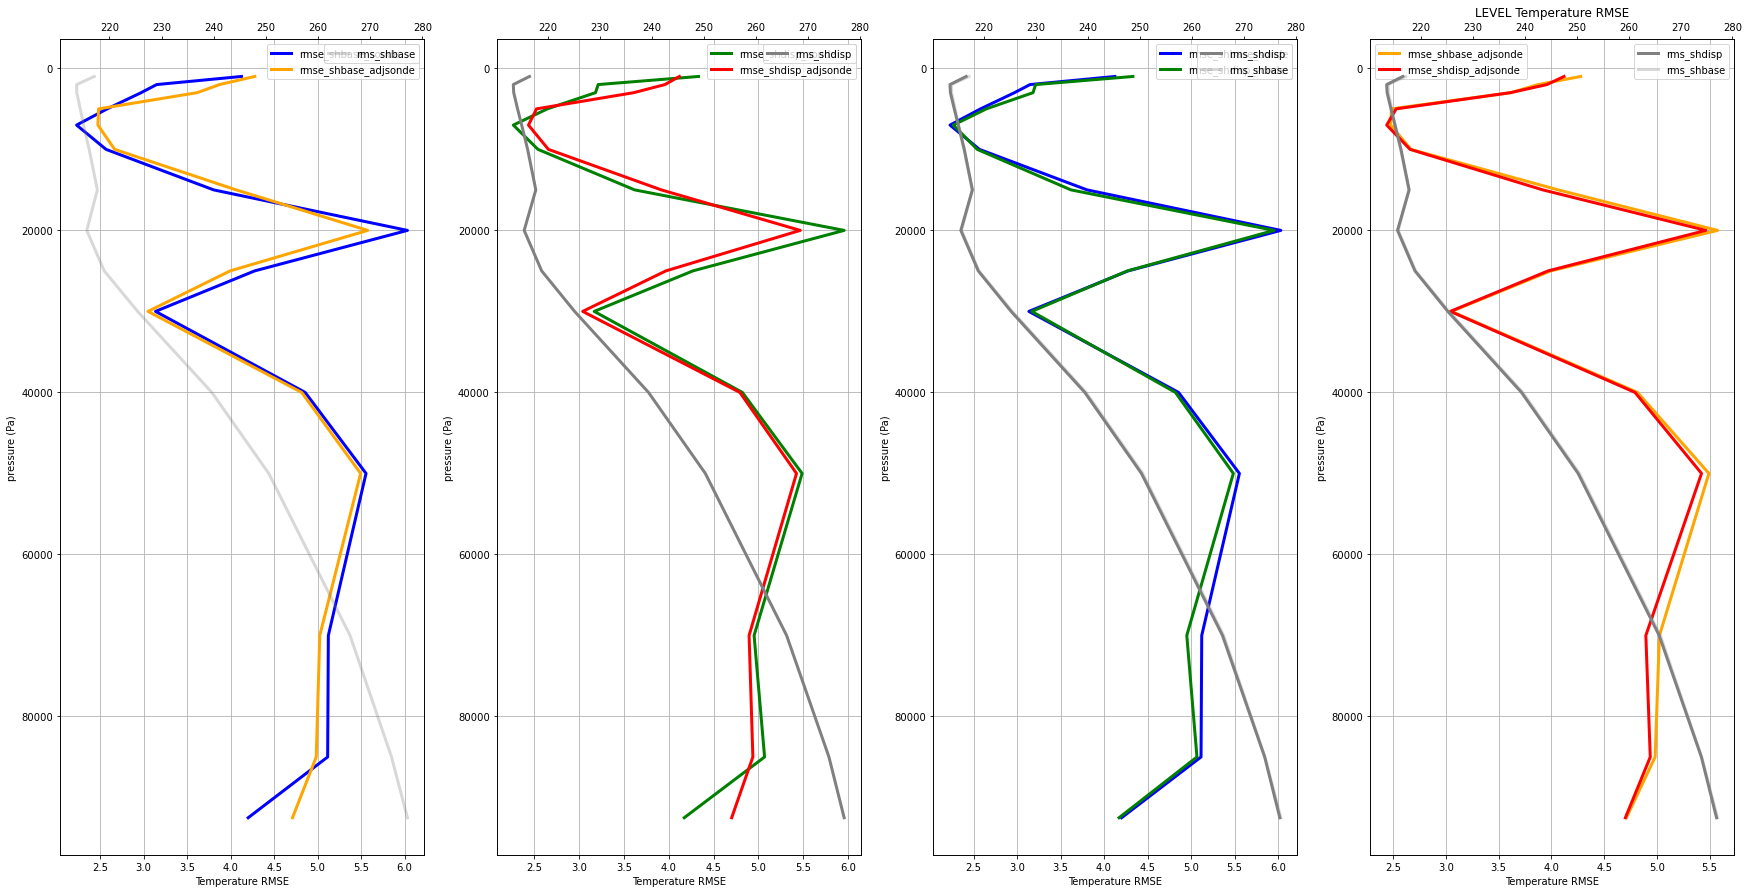

In [16]:
stat = '11035'
statlist = glob.glob('/mnt/users/scratch/leo/scratch/converted_v7/*' + stat + '*_CEUAS_merged_v1.nc')
df = eua.CDMDataset(filename = statlist[0]).to_dataframe(groups=['observations_table', 'era5fb'], variables=['latitude', 'longitude', 'observed_variable', 'observation_value', 'z_coordinate', 'date_time', 'fg_depar@body', 'an_depar@body'])
# 2020 only
df = df[df.date_time.dt.year == 2020]
# night only -> ~ 00:00
df = df[np.isin(df.date_time.dt.hour,[23,0,1])]

from scipy.signal import savgol_filter
stdplevs = [92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]
rmse_sum_shbase_sonde={}
rmse_sum_shbase_adjsonde={}
rmse_sum_shdisp_sonde={}
rmse_sum_shdisp_adjsonde={}
rms_sum_shbase={}
rms_sum_adjsonde={}
rms_sum_sonde={}
rms_sum_shdisp={}

for i in stdplevs:
    rmse_sum_shbase_sonde[i] = []
    rmse_sum_shbase_adjsonde[i] = []
    rmse_sum_shdisp_sonde[i] = []
    rmse_sum_shdisp_adjsonde[i] = []
    rms_sum_shbase[i] = []
    rms_sum_adjsonde[i] = []
    rms_sum_sonde[i] = []
    rms_sum_shdisp[i] = []

for day in df.date_time.drop_duplicates()[:100]:
    test = df[df.date_time == day]

    t = test[test.observed_variable == 85]
    t = t.rename(columns={'observation_value':'temperature'})
    t = t.drop(columns='observed_variable')

    u = test[test.observed_variable == 104]
    u = u.rename(columns={'observation_value':'u'})
    u = u.drop(columns=['observed_variable', 'fg_depar@body', 'an_depar@body'])

    v = test[test.observed_variable == 105]
    v = v.rename(columns={'observation_value':'v'})
    v = v.drop(columns=['observed_variable', 'fg_depar@body', 'an_depar@body'])

    input_data = pd.merge(t, u, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])
    input_data = pd.merge(input_data, v, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])

    input_data = input_data.dropna()
    phys_model = trj.trajectory(lat=t.latitude.iloc[0], lon=t.longitude.iloc[0], temperature=np.array(input_data.temperature), u=np.array(input_data.u), v=np.array(input_data.v), pressure=np.array(input_data.z_coordinate))


    input_data = input_data.reindex(index=input_data.index[::-1])
    input_data['z'] = np.array(trj.calc_height(np.array(input_data.temperature), np.array(input_data.z_coordinate), jump=False))
    input_data['calc_latd'] = np.array(phys_model[0])
    input_data['calc_lond'] = np.array(phys_model[1])

    test1 = [0] + list(input_data.calc_lond[:-1])
    test2 = [0] + list(input_data.calc_latd[:-1])
    input_data['prev_calc_lond']= test1
    input_data['prev_calc_latd']= test2

    input_data['lat_diff'] = np.array(input_data.calc_latd)- np.array(input_data.prev_calc_latd)
    input_data['lon_diff'] = np.array(input_data.calc_lond)- np.array(input_data.prev_calc_lond)


    input_data = input_data.dropna()


    with open('model_dt_4s_reduced_prev.p', "rb") as input_file:
        model = pickle.load(input_file)

    out = model.predict(input_data[['temperature', 'z_coordinate', 'u', 'v', 'z','latitude', 'longitude' , 'calc_latd', 'calc_lond', 'prev_calc_lond', 'prev_calc_latd', 'lon_diff', 'lat_diff']])

    ml_latd, ml_lond = out.transpose()
    filterlen = int(len(ml_latd)//2)
    if not (filterlen & 0x1):
        filterlen += 1
    input_data['ml_latd'] = np.array(savgol_filter(ml_latd, filterlen, 3))
    input_data['ml_lond'] = np.array(savgol_filter(ml_lond, filterlen, 3))

    input_data = input_data.reset_index()


    ds = xr.load_dataset("./PROGRAMS/"+str(day.year)+"/T3DSH"+str(day.year)+f"{day.month:02d}"+f"{day.day:02d}"+"0000.grib")
    ds_lnsp = xr.load_dataset("./PROGRAMS/"+str(day.year)+"/LNSPANASH"+str(day.year)+f"{day.month:02d}"+f"{day.day:02d}"+"0000.grib")



    igrib = '/scratch/das/mayerj47/era5_sh/lnspana/'+str(day.year)+'/LNSPANASH'+str(day.year)+f"{day.month:02d}"+f"{day.day:02d}"+'0000.grib'
    f = open(igrib)
#     print(f)
    msgid = codes_new_from_file(f, product_kind=CODES_PRODUCT_GRIB)
#     print(msgid)
    pv = codes_get_array(msgid,'pv')

    lnsp = float(ds_lnsp.sel(latitude=[input_data.latitude[0]], longitude=[input_data.longitude[0]], method="nearest").lnsp)
    sp = np.exp(lnsp)

    pv = np.array(pv)
    a = pv[:int(len(pv)/2)]
    b = pv[int(len(pv)/2):]

    p_half = a + b * sp
    base_t = ds.sel(latitude=[input_data.latitude[0]], longitude=[input_data.longitude[0]], method="nearest").t

    t_list = []
    for i in range(len(p_half[:-1])):
        step = find_nearest(input_data.z_coordinate, p_half[i])
        input_data_step = input_data[input_data.z_coordinate == step]
        station_lat = float(input_data.latitude[0]) + np.array(input_data_step.ml_latd)[0]
    #     print(station_lat)
        station_lon = float(input_data.longitude[0]) + np.array(input_data_step.ml_lond)[0]

        ds_now = ds.sel(latitude=[station_lat], longitude=[station_lon], method="nearest")
    #     print('selected lat: ', float(ds_now.latitude))
        t = ds_now.t
        t_list.append(np.array(t)[i][0][0])
    print('lat: ', input_data.latitude[0], 'lon: ', input_data.longitude[0])
    print(stat)
    print(day)
    for i in range(len(stdplevs)):
        if np.abs(stdplevs[i] - find_nearest(p_half[:-1],stdplevs[i])) > 1000:
            print(stdplevs[i] , find_nearest(p_half[:-1],stdplevs[i]))
            rmse_sum_shbase_sonde[stdplevs[i]].append(np.nan)
            rmse_sum_shbase_adjsonde[stdplevs[i]].append(np.nan)
            rmse_sum_shdisp_sonde[stdplevs[i]].append(np.nan)
            rmse_sum_shdisp_adjsonde[stdplevs[i]].append(np.nan)
            rms_sum_shbase[stdplevs[i]].append(np.nan)
            rms_sum_adjsonde[stdplevs[i]].append(np.nan)
            rms_sum_sonde[stdplevs[i]].append(np.nan)
            rms_sum_shdisp[stdplevs[i]].append(np.nan)
        else:
            sq_t = np.squeeze(t)
            t_base = float(sq_t[p_half[:-1] == find_nearest(p_half[:-1],stdplevs[i])])
            t_disp = float(np.array(t_list)[p_half[:-1] == find_nearest(p_half[:-1],stdplevs[i])])
            input_data_step = input_data[input_data.z_coordinate == find_nearest(input_data.z_coordinate, stdplevs[i])]
            t_sonde = float(input_data_step.temperature)
            t_adjsonde = float(input_data_step.temperature) - float(input_data_step['fg_depar@body']) - float(input_data_step['an_depar@body'])
            rmse_sum_shbase_sonde[stdplevs[i]].append(t_base - t_sonde)
            rmse_sum_shbase_adjsonde[stdplevs[i]].append(t_base - t_adjsonde)
            rmse_sum_shdisp_sonde[stdplevs[i]].append(t_disp - t_sonde)
            rmse_sum_shdisp_adjsonde[stdplevs[i]].append(t_disp - t_adjsonde)
            rms_sum_shbase[stdplevs[i]].append(t_base)
            rms_sum_adjsonde[stdplevs[i]].append(t_adjsonde)
            rms_sum_sonde[stdplevs[i]].append(t_sonde)
            rms_sum_shdisp[stdplevs[i]].append(t_disp)
        
        
#     fig, ax1 = maplt.subplots(1, figsize=(16, 8))
#     ax1.plot(np.squeeze(t), np.array(p_half[:-1]), color = 'green', alpha = 0.3, label='base tempterature')
#     ax1.plot(np.array(t_list), np.array(p_half[:-1]), color = 'blue', alpha = 0.6, label='displaced temperature')
#     ax1.plot(np.array(input_data.temperature), np.array(input_data.z_coordinate), color = 'red', alpha = 0.3, label='temperature radio sonde')
#     ax1.plot(np.array(input_data.temperature - input_data['fg_depar@body'] - input_data['an_depar@body'] ), np.array(input_data.z_coordinate), color = 'orange', alpha = 0.6, label='temperature radio sonde - adjusted')
#     ax1.set_ylabel('pressure (Pa)')
#     ax1.set_xlabel('temperature (K)')
#     ax1.tick_params(axis='y')
#     ax1.set_ylim(ax1.get_ylim()[::-1])
#     ax1.legend()
#     ax1.grid()
#     maplt.show()
#     maplt.close()

rmse_shbase_sonde=[]
rmse_shbase_adjsonde=[]
rmse_shdisp_sonde=[]
rmse_shdisp_adjsonde=[]

rms_shbase=[]
rms_adjsonde=[]
rms_sonde=[]
rms_shdisp=[]

for i in range(len(stdplevs)):
    rmse_shbase_sonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shbase_sonde[stdplevs[i]])**2))))
    print('rmse_shbase_sonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shbase_sonde[-1])
    rmse_shbase_adjsonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shbase_adjsonde[stdplevs[i]])**2))))
    print('rmse_shbase_adjsonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shbase_adjsonde[-1])
    rmse_shdisp_sonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shdisp_sonde[stdplevs[i]])**2))))
    print('rmse_shdisp_sonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shdisp_sonde[-1])
    rmse_shdisp_adjsonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shdisp_adjsonde[stdplevs[i]])**2))))
    print('rmse_shdisp_adjsonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shdisp_adjsonde[-1])
    
    rms_shbase.append(np.sqrt(np.nanmean((np.array(rms_sum_shbase[stdplevs[i]])**2))))
    print('rms_shbase - plev: ', stdplevs[i], ' RMS: ', rms_shbase[-1])
    rms_adjsonde.append(np.sqrt(np.nanmean((np.array(rms_sum_adjsonde[stdplevs[i]])**2))))
    print('rms_adjsonde - plev: ', stdplevs[i], ' RMS: ', rms_adjsonde[-1])
    rms_sonde.append(np.sqrt(np.nanmean((np.array(rms_sum_sonde[stdplevs[i]])**2))))
    print('rms_sonde - plev: ', stdplevs[i], ' RMS: ', rms_sonde[-1])
    rms_shdisp.append(np.sqrt(np.nanmean((np.array(rms_sum_shdisp[stdplevs[i]])**2))))
    print('rms_shdisp - plev: ', stdplevs[i], ' RMS: ', rms_shdisp[-1])

print('')
fig, ax1 = maplt.subplots(1,4,figsize = (30,15))

ax1[0].plot(np.array(rmse_shbase_sonde),stdplevs,color = 'blue', label='rmse_shbase_sonde')
ax1[0].plot(np.array(rmse_shbase_adjsonde),stdplevs,color='orange', label='rmse_shbase_adjsonde')
# ax1[0].plot(np.array(rmse_shdisp_sonde),stdplevs, label='rmse_shdisp_sonde')
# ax1[0].plot(np.array(rmse_shdisp_adjsonde),stdplevs, label='rmse_shdisp_adjsonde')
ax1_1 = ax1[0].twiny()
ax1_1.plot(np.array(rms_shbase),stdplevs,color='grey',alpha=0.3, label='rms_shbase')
ax1_1.legend()
ax1[0].set_ylim(ax1[0].get_ylim()[::-1])
ax1[0].set_ylabel('pressure (Pa)')
ax1[0].set_xlabel('Temperature RMSE')
ax1[0].legend()
ax1[0].grid()

# ax1[1].plot(np.array(rmse_shbase_sonde),stdplevs, label='rmse_shbase_sonde')
# ax1[1].plot(np.array(rmse_shbase_adjsonde),stdplevs, label='rmse_shbase_adjsonde')
ax1[1].plot(np.array(rmse_shdisp_sonde),stdplevs, color='green', label='rmse_shdisp_sonde')
ax1[1].plot(np.array(rmse_shdisp_adjsonde),stdplevs, color='red', label='rmse_shdisp_adjsonde')
ax1_2 = ax1[1].twiny()
ax1_2.plot(np.array(rms_shdisp),stdplevs,color='grey', label='rms_shdisp')
ax1_2.legend()
ax1[1].set_ylim(ax1[1].get_ylim()[::-1])
ax1[1].set_ylabel('pressure (Pa)')
ax1[1].set_xlabel('Temperature RMSE')
ax1[1].legend()
ax1[1].grid()

ax1[2].plot(np.array(rmse_shbase_sonde),stdplevs,color = 'blue', label='rmse_shbase_sonde')
ax1[2].plot(np.array(rmse_shdisp_sonde),stdplevs, color='green', label='rmse_shdisp_sonde')
ax1_3 = ax1[2].twiny()
ax1_3.plot(np.array(rms_shdisp),stdplevs,color='grey', label='rms_shdisp')
ax1_3.plot(np.array(rms_shbase),stdplevs,color='grey',alpha=0.3, label='rms_shbase')
ax1_3.legend()
ax1[2].set_ylim(ax1[2].get_ylim()[::-1])
ax1[2].set_ylabel('pressure (Pa)')
ax1[2].set_xlabel('Temperature RMSE')
ax1[2].legend()
ax1[2].grid()

ax1[3].plot(np.array(rmse_shbase_adjsonde),stdplevs,color='orange', label='rmse_shbase_adjsonde')
ax1[3].plot(np.array(rmse_shdisp_adjsonde),stdplevs, color='red', label='rmse_shdisp_adjsonde')
ax1_4 = ax1[3].twiny()
ax1_4.plot(np.array(rms_shdisp),stdplevs,color='grey', label='rms_shdisp')
ax1_4.plot(np.array(rms_shbase),stdplevs,color='grey',alpha=0.3, label='rms_shbase')
ax1_4.legend(loc='lower left')
ax1[3].set_ylim(ax1[3].get_ylim()[::-1])
ax1[3].set_ylabel('pressure (Pa)')
ax1[3].set_xlabel('Temperature RMSE')
ax1[3].legend(loc='upper right')
ax1[3].grid()

maplt.title('LEVEL Temperature RMSE')
maplt.show()
maplt.close()

lat:  48.24895 lon:  16.35687
11035
2020-01-01 23:30:34
lat:  48.24895 lon:  16.35718
11035
2020-01-02 23:30:47
lat:  48.24895 lon:  16.35718
11035
2020-01-03 23:30:15
lat:  48.24895 lon:  16.35718
11035
2020-01-04 23:30:45
lat:  48.24895 lon:  16.35718
11035
2020-01-05 23:30:59
lat:  48.24895 lon:  16.35718
11035
2020-01-06 23:30:25
lat:  48.24895 lon:  16.35718
11035
2020-01-07 23:30:40
lat:  48.24895 lon:  16.35718
11035
2020-01-08 23:30:21
lat:  48.24895 lon:  16.35718
11035
2020-01-09 23:30:39
lat:  48.24895 lon:  16.35718
11035
2020-01-10 23:30:06
lat:  48.24895 lon:  16.35718
11035
2020-01-11 23:30:12
lat:  48.24895 lon:  16.35718
11035
2020-01-12 23:31:26
lat:  48.24895 lon:  16.35718
11035
2020-01-13 23:31:12
lat:  48.24895 lon:  16.35718
11035
2020-01-14 23:30:22
lat:  48.24895 lon:  16.35718
11035
2020-01-15 23:30:03
lat:  48.24895 lon:  16.35718
11035
2020-01-16 23:31:32
lat:  48.24894 lon:  16.3569
11035
2020-01-17 23:45:20
lat:  48.24895 lon:  16.35718
11035
2020-01-18 23

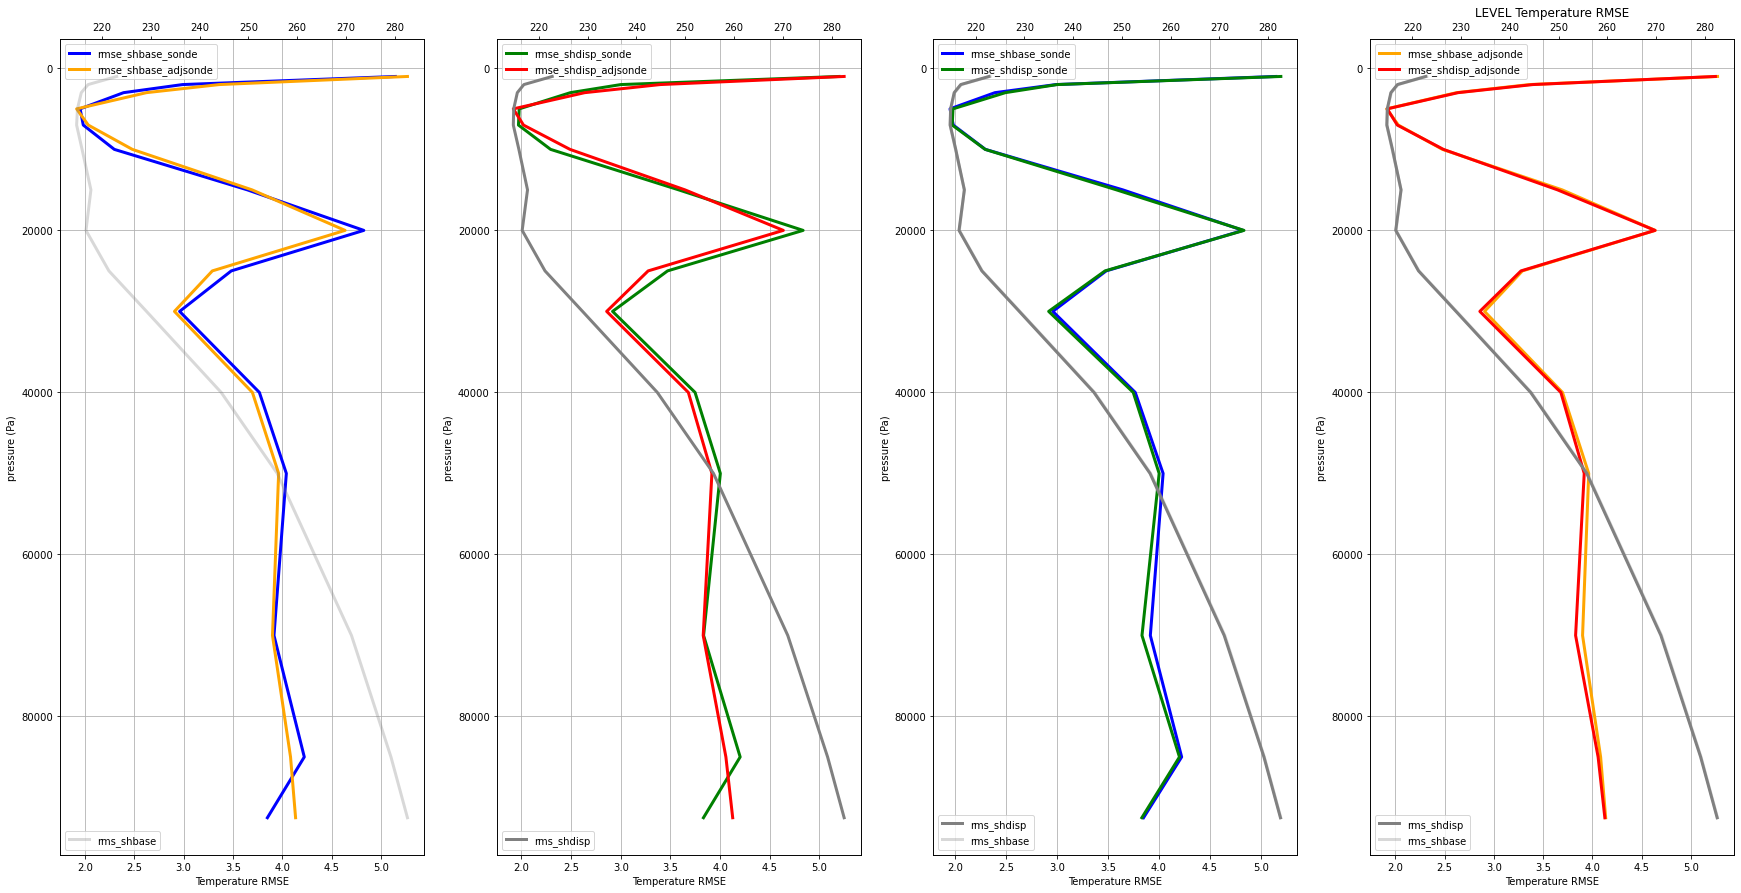

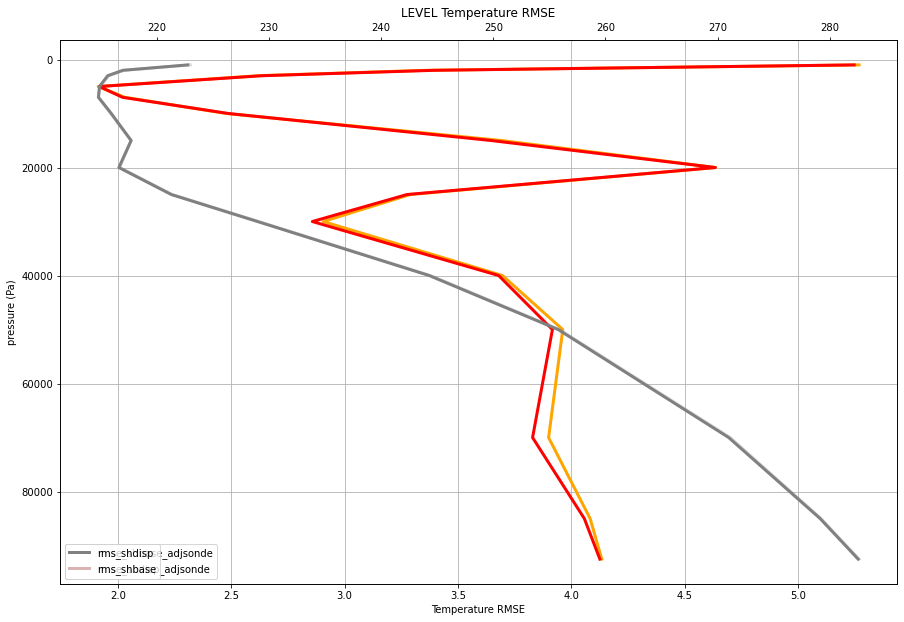

In [17]:
stat = '11035'
statlist = glob.glob('/mnt/users/scratch/leo/scratch/converted_v7/*' + stat + '*_CEUAS_merged_v1.nc')
df = eua.CDMDataset(filename = statlist[0]).to_dataframe(groups=['observations_table', 'era5fb'], variables=['latitude', 'longitude', 'observed_variable', 'observation_value', 'z_coordinate', 'date_time', 'fg_depar@body', 'an_depar@body'])
# 2020 only
df = df[df.date_time.dt.year == 2020]
# night only -> ~ 00:00
df = df[np.isin(df.date_time.dt.hour,[23,0,1])]

from scipy.signal import savgol_filter
stdplevs = [92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]
rmse_sum_shbase_sonde={}
rmse_sum_shbase_adjsonde={}
rmse_sum_shdisp_sonde={}
rmse_sum_shdisp_adjsonde={}
rms_sum_shbase={}
rms_sum_adjsonde={}
rms_sum_sonde={}
rms_sum_shdisp={}

for i in stdplevs:
    rmse_sum_shbase_sonde[i] = []
    rmse_sum_shbase_adjsonde[i] = []
    rmse_sum_shdisp_sonde[i] = []
    rmse_sum_shdisp_adjsonde[i] = []
    rms_sum_shbase[i] = []
    rms_sum_adjsonde[i] = []
    rms_sum_sonde[i] = []
    rms_sum_shdisp[i] = []

for day in df.date_time.drop_duplicates():
    test = df[df.date_time == day]

    t = test[test.observed_variable == 85]
    t = t.rename(columns={'observation_value':'temperature'})
    t = t.drop(columns='observed_variable')

    u = test[test.observed_variable == 104]
    u = u.rename(columns={'observation_value':'u'})
    u = u.drop(columns=['observed_variable', 'fg_depar@body', 'an_depar@body'])

    v = test[test.observed_variable == 105]
    v = v.rename(columns={'observation_value':'v'})
    v = v.drop(columns=['observed_variable', 'fg_depar@body', 'an_depar@body'])

    input_data = pd.merge(t, u, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])
    input_data = pd.merge(input_data, v, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])

    input_data = input_data.dropna()
    phys_model = trj.trajectory(lat=t.latitude.iloc[0], lon=t.longitude.iloc[0], temperature=np.array(input_data.temperature), u=np.array(input_data.u), v=np.array(input_data.v), pressure=np.array(input_data.z_coordinate))


    input_data = input_data.reindex(index=input_data.index[::-1])
    input_data['z'] = np.array(trj.calc_height(np.array(input_data.temperature), np.array(input_data.z_coordinate), jump=False))
    input_data['calc_latd'] = np.array(phys_model[0])
    input_data['calc_lond'] = np.array(phys_model[1])

    test1 = [0] + list(input_data.calc_lond[:-1])
    test2 = [0] + list(input_data.calc_latd[:-1])
    input_data['prev_calc_lond']= test1
    input_data['prev_calc_latd']= test2

    input_data['lat_diff'] = np.array(input_data.calc_latd)- np.array(input_data.prev_calc_latd)
    input_data['lon_diff'] = np.array(input_data.calc_lond)- np.array(input_data.prev_calc_lond)


    input_data = input_data.dropna()


    with open('model_dt_4s_reduced_prev.p', "rb") as input_file:
        model = pickle.load(input_file)

    out = model.predict(input_data[['temperature', 'z_coordinate', 'u', 'v', 'z','latitude', 'longitude' , 'calc_latd', 'calc_lond', 'prev_calc_lond', 'prev_calc_latd', 'lon_diff', 'lat_diff']])

    ml_latd, ml_lond = out.transpose()
    filterlen = int(len(ml_latd)//2)
    if not (filterlen & 0x1):
        filterlen += 1
    input_data['ml_latd'] = np.array(savgol_filter(ml_latd, filterlen, 3))
    input_data['ml_lond'] = np.array(savgol_filter(ml_lond, filterlen, 3))

    input_data = input_data.reset_index()


    ds = xr.load_dataset("./PROGRAMS/"+str(day.year)+"/T3DSH"+str(day.year)+f"{day.month:02d}"+f"{day.day:02d}"+"0000.grib")
    ds_lnsp = xr.load_dataset("./PROGRAMS/"+str(day.year)+"/LNSPANASH"+str(day.year)+f"{day.month:02d}"+f"{day.day:02d}"+"0000.grib")



    igrib = '/scratch/das/mayerj47/era5_sh/lnspana/'+str(day.year)+'/LNSPANASH'+str(day.year)+f"{day.month:02d}"+f"{day.day:02d}"+'0000.grib'
    f = open(igrib)
#     print(f)
    msgid = codes_new_from_file(f, product_kind=CODES_PRODUCT_GRIB)
#     print(msgid)
    pv = codes_get_array(msgid,'pv')

    lnsp = float(ds_lnsp.sel(latitude=[input_data.latitude[0]], longitude=[input_data.longitude[0]], method="nearest").lnsp)
    sp = np.exp(lnsp)

    pv = np.array(pv)
    a = pv[:int(len(pv)/2)]
    b = pv[int(len(pv)/2):]

    p_half = a + b * sp
    base_t = ds.sel(latitude=[input_data.latitude[0]], longitude=[input_data.longitude[0]], method="nearest").t

    t_list = []
    for i in range(len(p_half[:-1])):
        step = find_nearest(input_data.z_coordinate, p_half[i])
        input_data_step = input_data[input_data.z_coordinate == step]
        station_lat = float(input_data.latitude[0]) + np.array(input_data_step.ml_latd)[0]
    #     print(station_lat)
        station_lon = float(input_data.longitude[0]) + np.array(input_data_step.ml_lond)[0]

        ds_now = ds.sel(latitude=[station_lat], longitude=[station_lon], method="nearest")
    #     print('selected lat: ', float(ds_now.latitude))
        t = ds_now.t
        t_list.append(np.array(t)[i][0][0])
    print('lat: ', input_data.latitude[0], 'lon: ', input_data.longitude[0])
    print(stat)
    print(day)
    for i in range(len(stdplevs)):
        if np.abs(stdplevs[i] - find_nearest(p_half[:-1],stdplevs[i])) > 1000:
            print(stdplevs[i] , find_nearest(p_half[:-1],stdplevs[i]))
            rmse_sum_shbase_sonde[stdplevs[i]].append(np.nan)
            rmse_sum_shbase_adjsonde[stdplevs[i]].append(np.nan)
            rmse_sum_shdisp_sonde[stdplevs[i]].append(np.nan)
            rmse_sum_shdisp_adjsonde[stdplevs[i]].append(np.nan)
            rms_sum_shbase[stdplevs[i]].append(np.nan)
            rms_sum_adjsonde[stdplevs[i]].append(np.nan)
            rms_sum_sonde[stdplevs[i]].append(np.nan)
            rms_sum_shdisp[stdplevs[i]].append(np.nan)
        else:
            sq_t = np.squeeze(t)
            t_base = float(sq_t[p_half[:-1] == find_nearest(p_half[:-1],stdplevs[i])])
            t_disp = float(np.array(t_list)[p_half[:-1] == find_nearest(p_half[:-1],stdplevs[i])])
            input_data_step = input_data[input_data.z_coordinate == find_nearest(input_data.z_coordinate, stdplevs[i])]
            t_sonde = float(input_data_step.temperature)
            t_adjsonde = float(input_data_step.temperature) - float(input_data_step['fg_depar@body']) - float(input_data_step['an_depar@body'])
            rmse_sum_shbase_sonde[stdplevs[i]].append(t_base - t_sonde)
            rmse_sum_shbase_adjsonde[stdplevs[i]].append(t_base - t_adjsonde)
            rmse_sum_shdisp_sonde[stdplevs[i]].append(t_disp - t_sonde)
            rmse_sum_shdisp_adjsonde[stdplevs[i]].append(t_disp - t_adjsonde)
            rms_sum_shbase[stdplevs[i]].append(t_base)
            rms_sum_adjsonde[stdplevs[i]].append(t_adjsonde)
            rms_sum_sonde[stdplevs[i]].append(t_sonde)
            rms_sum_shdisp[stdplevs[i]].append(t_disp)
        
        
#     fig, ax1 = maplt.subplots(1, figsize=(16, 8))
#     ax1.plot(np.squeeze(t), np.array(p_half[:-1]), color = 'green', alpha = 0.3, label='base tempterature')
#     ax1.plot(np.array(t_list), np.array(p_half[:-1]), color = 'blue', alpha = 0.6, label='displaced temperature')
#     ax1.plot(np.array(input_data.temperature), np.array(input_data.z_coordinate), color = 'red', alpha = 0.3, label='temperature radio sonde')
#     ax1.plot(np.array(input_data.temperature - input_data['fg_depar@body'] - input_data['an_depar@body'] ), np.array(input_data.z_coordinate), color = 'orange', alpha = 0.6, label='temperature radio sonde - adjusted')
#     ax1.set_ylabel('pressure (Pa)')
#     ax1.set_xlabel('temperature (K)')
#     ax1.tick_params(axis='y')
#     ax1.set_ylim(ax1.get_ylim()[::-1])
#     ax1.legend()
#     ax1.grid()
#     maplt.show()
#     maplt.close()

rmse_shbase_sonde=[]
rmse_shbase_adjsonde=[]
rmse_shdisp_sonde=[]
rmse_shdisp_adjsonde=[]

rms_shbase=[]
rms_adjsonde=[]
rms_sonde=[]
rms_shdisp=[]

for i in range(len(stdplevs)):
    rmse_shbase_sonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shbase_sonde[stdplevs[i]])**2))))
    print('rmse_shbase_sonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shbase_sonde[-1])
    rmse_shbase_adjsonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shbase_adjsonde[stdplevs[i]])**2))))
    print('rmse_shbase_adjsonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shbase_adjsonde[-1])
    rmse_shdisp_sonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shdisp_sonde[stdplevs[i]])**2))))
    print('rmse_shdisp_sonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shdisp_sonde[-1])
    rmse_shdisp_adjsonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shdisp_adjsonde[stdplevs[i]])**2))))
    print('rmse_shdisp_adjsonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shdisp_adjsonde[-1])
    
    rms_shbase.append(np.sqrt(np.nanmean((np.array(rms_sum_shbase[stdplevs[i]])**2))))
    print('rms_shbase - plev: ', stdplevs[i], ' RMS: ', rms_shbase[-1])
    rms_adjsonde.append(np.sqrt(np.nanmean((np.array(rms_sum_adjsonde[stdplevs[i]])**2))))
    print('rms_adjsonde - plev: ', stdplevs[i], ' RMS: ', rms_adjsonde[-1])
    rms_sonde.append(np.sqrt(np.nanmean((np.array(rms_sum_sonde[stdplevs[i]])**2))))
    print('rms_sonde - plev: ', stdplevs[i], ' RMS: ', rms_sonde[-1])
    rms_shdisp.append(np.sqrt(np.nanmean((np.array(rms_sum_shdisp[stdplevs[i]])**2))))
    print('rms_shdisp - plev: ', stdplevs[i], ' RMS: ', rms_shdisp[-1])

print('')
fig, ax1 = maplt.subplots(1,4,figsize = (30,15))

ax1[0].plot(np.array(rmse_shbase_sonde),stdplevs,color = 'blue', label='rmse_shbase_sonde')
ax1[0].plot(np.array(rmse_shbase_adjsonde),stdplevs,color='orange', label='rmse_shbase_adjsonde')
# ax1[0].plot(np.array(rmse_shdisp_sonde),stdplevs, label='rmse_shdisp_sonde')
# ax1[0].plot(np.array(rmse_shdisp_adjsonde),stdplevs, label='rmse_shdisp_adjsonde')
ax1_1 = ax1[0].twiny()
ax1_1.plot(np.array(rms_shbase),stdplevs,color='grey',alpha=0.3, label='rms_shbase')
ax1_1.legend(loc='lower left')
ax1[0].set_ylim(ax1[0].get_ylim()[::-1])
ax1[0].set_ylabel('pressure (Pa)')
ax1[0].set_xlabel('Temperature RMSE')
ax1[0].legend()
ax1[0].grid()

# ax1[1].plot(np.array(rmse_shbase_sonde),stdplevs, label='rmse_shbase_sonde')
# ax1[1].plot(np.array(rmse_shbase_adjsonde),stdplevs, label='rmse_shbase_adjsonde')
ax1[1].plot(np.array(rmse_shdisp_sonde),stdplevs, color='green', label='rmse_shdisp_sonde')
ax1[1].plot(np.array(rmse_shdisp_adjsonde),stdplevs, color='red', label='rmse_shdisp_adjsonde')
ax1_2 = ax1[1].twiny()
ax1_2.plot(np.array(rms_shdisp),stdplevs,color='grey', label='rms_shdisp')
ax1_2.legend(loc='lower left')
ax1[1].set_ylim(ax1[1].get_ylim()[::-1])
ax1[1].set_ylabel('pressure (Pa)')
ax1[1].set_xlabel('Temperature RMSE')
ax1[1].legend()
ax1[1].grid()

ax1[2].plot(np.array(rmse_shbase_sonde),stdplevs,color = 'blue', label='rmse_shbase_sonde')
ax1[2].plot(np.array(rmse_shdisp_sonde),stdplevs, color='green', label='rmse_shdisp_sonde')
ax1_3 = ax1[2].twiny()
ax1_3.plot(np.array(rms_shdisp),stdplevs,color='grey', label='rms_shdisp')
ax1_3.plot(np.array(rms_shbase),stdplevs,color='grey',alpha=0.3, label='rms_shbase')
ax1_3.legend(loc='lower left')
ax1[2].set_ylim(ax1[2].get_ylim()[::-1])
ax1[2].set_ylabel('pressure (Pa)')
ax1[2].set_xlabel('Temperature RMSE')
ax1[2].legend()
ax1[2].grid()

ax1[3].plot(np.array(rmse_shbase_adjsonde),stdplevs,color='orange', label='rmse_shbase_adjsonde')
ax1[3].plot(np.array(rmse_shdisp_adjsonde),stdplevs, color='red', label='rmse_shdisp_adjsonde')
ax1_4 = ax1[3].twiny()
ax1_4.plot(np.array(rms_shdisp),stdplevs,color='grey', label='rms_shdisp')
ax1_4.plot(np.array(rms_shbase),stdplevs,color='grey',alpha=0.3, label='rms_shbase')
ax1_4.legend(loc='lower left')
ax1[3].set_ylim(ax1[3].get_ylim()[::-1])
ax1[3].set_ylabel('pressure (Pa)')
ax1[3].set_xlabel('Temperature RMSE')
ax1[3].legend()
ax1[3].grid()

maplt.title('LEVEL Temperature RMSE')
maplt.show()
maplt.close()

fig, ax1 = maplt.subplots(figsize = (15,10))
ax1.plot(np.array(rmse_shbase_adjsonde),stdplevs,color='orange', label='rmse_shbase_adjsonde')
ax1.plot(np.array(rmse_shdisp_adjsonde),stdplevs, color='red', label='rmse_shdisp_adjsonde')
ax1_4 = ax1.twiny()
ax1_4.plot(np.array(rms_shdisp),stdplevs,color='grey', label='rms_shdisp')
ax1_4.plot(np.array(rms_shbase),stdplevs,color='grey',alpha=0.3, label='rms_shbase')
ax1_4.legend(loc='lower left')
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.set_ylabel('pressure (Pa)')
ax1.set_xlabel('Temperature RMSE')
ax1.legend('upper right')
ax1.grid()

maplt.title('LEVEL Temperature RMSE')
maplt.show()
maplt.close()

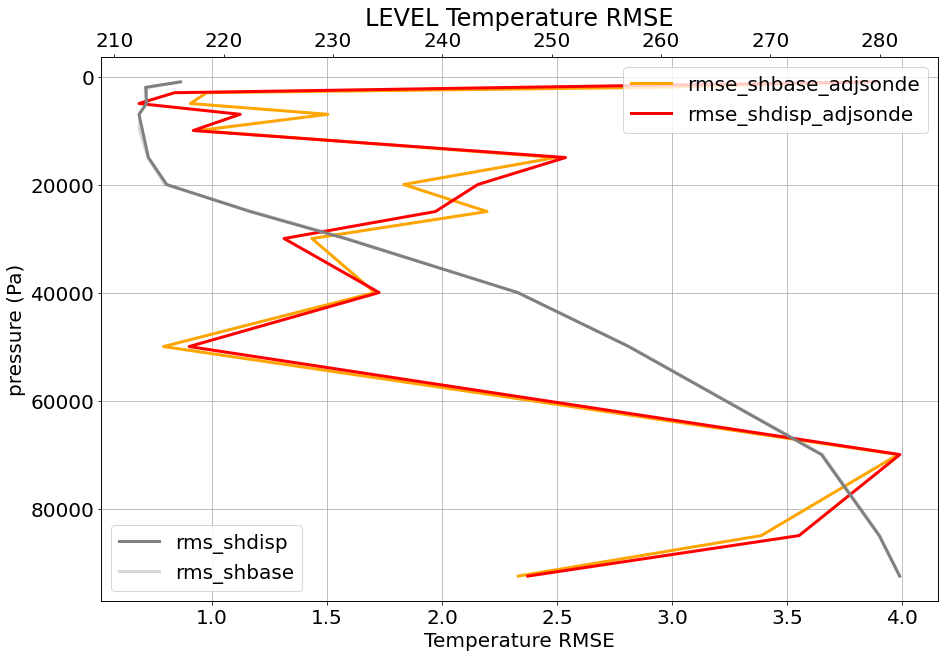

In [25]:
fig, ax1 = maplt.subplots(figsize = (15,10))
ax1.plot(np.array(rmse_shbase_adjsonde),stdplevs,color='orange', label='rmse_shbase_adjsonde')
ax1.plot(np.array(rmse_shdisp_adjsonde),stdplevs, color='red', label='rmse_shdisp_adjsonde')
ax1_4 = ax1.twiny()
ax1_4.plot(np.array(rms_shdisp),stdplevs,color='grey', label='rms_shdisp')
ax1_4.plot(np.array(rms_shbase),stdplevs,color='grey',alpha=0.3, label='rms_shbase')
ax1_4.legend(loc='lower left')
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.set_ylabel('pressure (Pa)')
ax1.set_xlabel('Temperature RMSE')
ax1.legend(loc='upper right')
ax1.grid()

maplt.title('LEVEL Temperature RMSE')
maplt.show()
maplt.close()

lat:  49.25 lon:  119.7
50527
2020-01-01 23:17:26
lat:  49.25 lon:  119.7
50527
2020-01-02 23:15:27
lat:  49.25 lon:  119.7
50527
2020-01-03 23:19:17
lat:  49.25 lon:  119.7
50527
2020-01-04 23:16:36
lat:  49.25 lon:  119.7
50527
2020-01-05 23:15:14
lat:  49.25 lon:  119.7
50527
2020-01-06 23:16:30
lat:  49.25 lon:  119.7
50527
2020-01-07 23:16:02
lat:  49.25 lon:  119.7
50527
2020-01-08 23:15:32
lat:  49.25 lon:  119.7
50527
2020-01-09 23:19:24
lat:  49.25 lon:  119.7
50527
2020-01-10 23:15:34
lat:  49.25 lon:  119.7
50527
2020-01-11 23:22:20
lat:  49.25 lon:  119.7
50527
2020-01-13 00:05:50
lat:  49.25 lon:  119.7
50527
2020-01-13 23:28:48
lat:  49.25 lon:  119.7
50527
2020-01-14 23:15:24
lat:  49.25 lon:  119.7
50527
2020-01-15 23:15:58
lat:  49.25 lon:  119.7
50527
2020-01-16 23:15:42
lat:  49.25 lon:  119.7
50527
2020-01-17 23:15:47
lat:  49.25 lon:  119.7
50527
2020-01-18 23:15:48
lat:  49.25 lon:  119.7
50527
2020-01-19 23:17:42
lat:  49.25 lon:  119.7
50527
2020-01-20 23:15:53


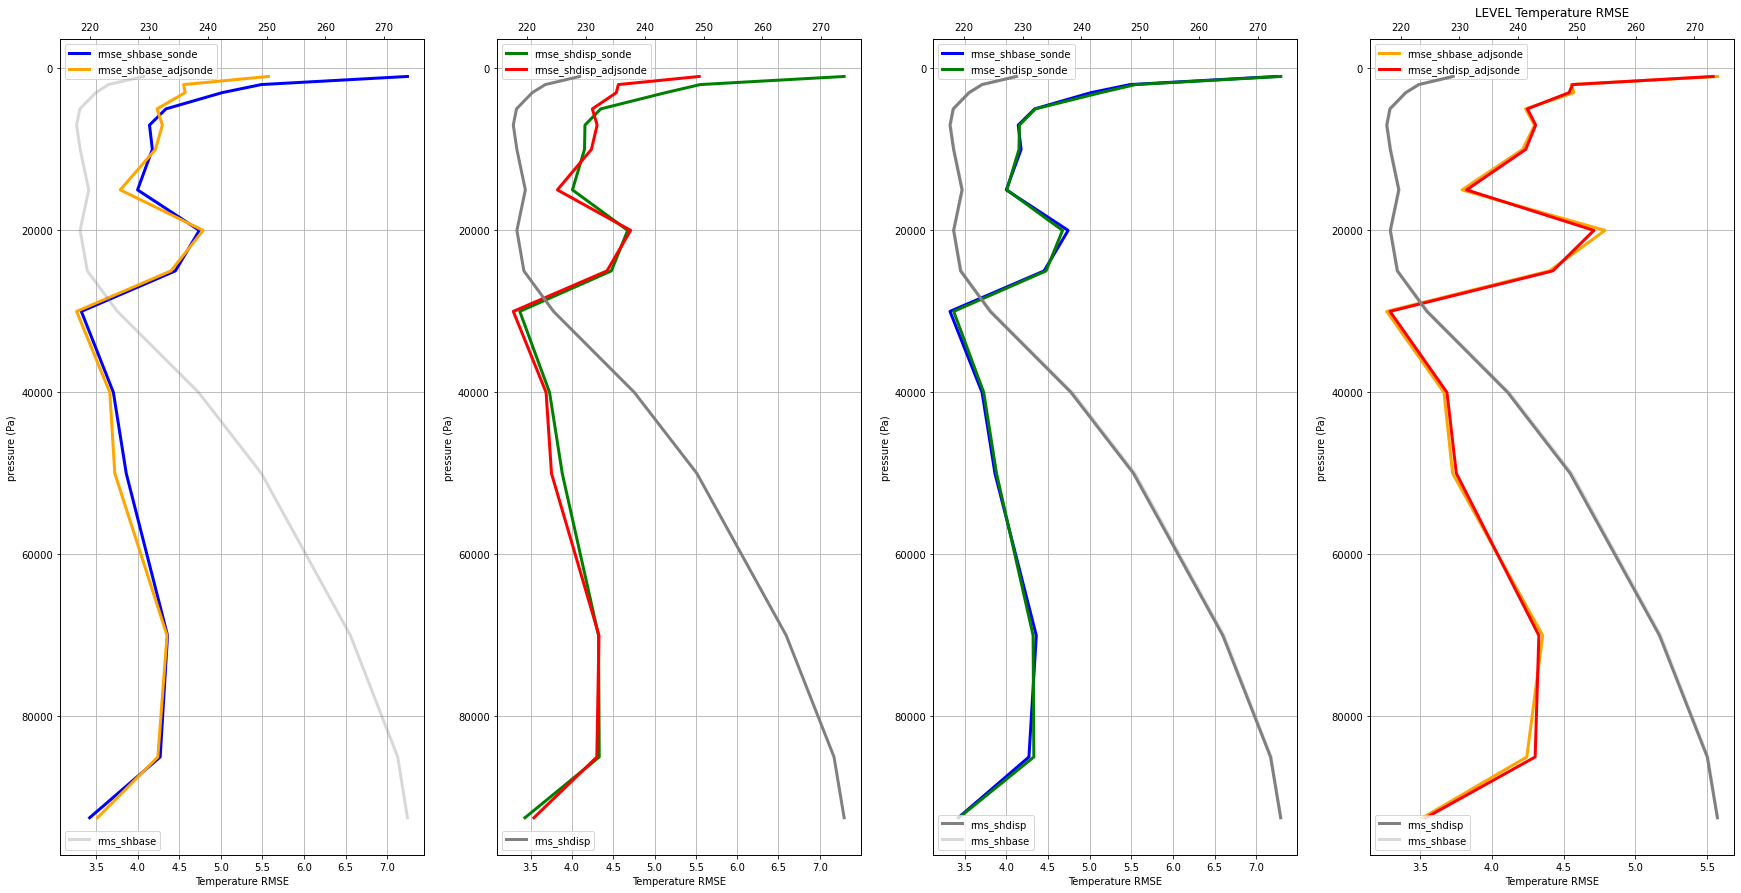

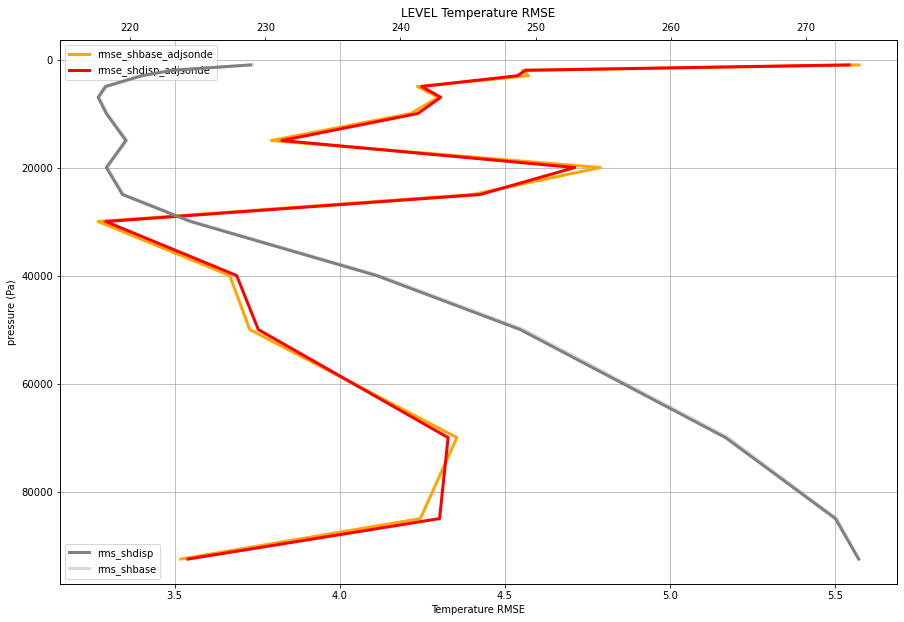

In [18]:
stat = '50527'
statlist = glob.glob('/mnt/users/scratch/leo/scratch/converted_v7/*' + stat + '*_CEUAS_merged_v1.nc')
df = eua.CDMDataset(filename = statlist[0]).to_dataframe(groups=['observations_table', 'era5fb'], variables=['latitude', 'longitude', 'observed_variable', 'observation_value', 'z_coordinate', 'date_time', 'fg_depar@body', 'an_depar@body'])
# 2020 only
df = df[df.date_time.dt.year == 2020]
# night only -> ~ 00:00
df = df[np.isin(df.date_time.dt.hour,[23,0,1])]

from scipy.signal import savgol_filter
stdplevs = [92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]
rmse_sum_shbase_sonde={}
rmse_sum_shbase_adjsonde={}
rmse_sum_shdisp_sonde={}
rmse_sum_shdisp_adjsonde={}
rms_sum_shbase={}
rms_sum_adjsonde={}
rms_sum_sonde={}
rms_sum_shdisp={}

for i in stdplevs:
    rmse_sum_shbase_sonde[i] = []
    rmse_sum_shbase_adjsonde[i] = []
    rmse_sum_shdisp_sonde[i] = []
    rmse_sum_shdisp_adjsonde[i] = []
    rms_sum_shbase[i] = []
    rms_sum_adjsonde[i] = []
    rms_sum_sonde[i] = []
    rms_sum_shdisp[i] = []

for day in df.date_time.drop_duplicates():
    test = df[df.date_time == day]

    t = test[test.observed_variable == 85]
    t = t.rename(columns={'observation_value':'temperature'})
    t = t.drop(columns='observed_variable')

    u = test[test.observed_variable == 104]
    u = u.rename(columns={'observation_value':'u'})
    u = u.drop(columns=['observed_variable', 'fg_depar@body', 'an_depar@body'])

    v = test[test.observed_variable == 105]
    v = v.rename(columns={'observation_value':'v'})
    v = v.drop(columns=['observed_variable', 'fg_depar@body', 'an_depar@body'])

    input_data = pd.merge(t, u, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])
    input_data = pd.merge(input_data, v, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])

    input_data = input_data.dropna()
    phys_model = trj.trajectory(lat=t.latitude.iloc[0], lon=t.longitude.iloc[0], temperature=np.array(input_data.temperature), u=np.array(input_data.u), v=np.array(input_data.v), pressure=np.array(input_data.z_coordinate))


    input_data = input_data.reindex(index=input_data.index[::-1])
    input_data['z'] = np.array(trj.calc_height(np.array(input_data.temperature), np.array(input_data.z_coordinate), jump=False))
    input_data['calc_latd'] = np.array(phys_model[0])
    input_data['calc_lond'] = np.array(phys_model[1])

    test1 = [0] + list(input_data.calc_lond[:-1])
    test2 = [0] + list(input_data.calc_latd[:-1])
    input_data['prev_calc_lond']= test1
    input_data['prev_calc_latd']= test2

    input_data['lat_diff'] = np.array(input_data.calc_latd)- np.array(input_data.prev_calc_latd)
    input_data['lon_diff'] = np.array(input_data.calc_lond)- np.array(input_data.prev_calc_lond)


    input_data = input_data.dropna()


    with open('model_dt_4s_reduced_prev.p', "rb") as input_file:
        model = pickle.load(input_file)

    out = model.predict(input_data[['temperature', 'z_coordinate', 'u', 'v', 'z','latitude', 'longitude' , 'calc_latd', 'calc_lond', 'prev_calc_lond', 'prev_calc_latd', 'lon_diff', 'lat_diff']])

    ml_latd, ml_lond = out.transpose()
    filterlen = int(len(ml_latd)//2)
    if not (filterlen & 0x1):
        filterlen += 1
    input_data['ml_latd'] = np.array(savgol_filter(ml_latd, filterlen, 3))
    input_data['ml_lond'] = np.array(savgol_filter(ml_lond, filterlen, 3))

    input_data = input_data.reset_index()


    ds = xr.load_dataset("./PROGRAMS/"+str(day.year)+"/T3DSH"+str(day.year)+f"{day.month:02d}"+f"{day.day:02d}"+"0000.grib")
    ds_lnsp = xr.load_dataset("./PROGRAMS/"+str(day.year)+"/LNSPANASH"+str(day.year)+f"{day.month:02d}"+f"{day.day:02d}"+"0000.grib")



    igrib = '/scratch/das/mayerj47/era5_sh/lnspana/'+str(day.year)+'/LNSPANASH'+str(day.year)+f"{day.month:02d}"+f"{day.day:02d}"+'0000.grib'
    f = open(igrib)
#     print(f)
    msgid = codes_new_from_file(f, product_kind=CODES_PRODUCT_GRIB)
#     print(msgid)
    pv = codes_get_array(msgid,'pv')

    lnsp = float(ds_lnsp.sel(latitude=[input_data.latitude[0]], longitude=[input_data.longitude[0]], method="nearest").lnsp)
    sp = np.exp(lnsp)

    pv = np.array(pv)
    a = pv[:int(len(pv)/2)]
    b = pv[int(len(pv)/2):]

    p_half = a + b * sp
    base_t = ds.sel(latitude=[input_data.latitude[0]], longitude=[input_data.longitude[0]], method="nearest").t

    t_list = []
    for i in range(len(p_half[:-1])):
        step = find_nearest(input_data.z_coordinate, p_half[i])
        input_data_step = input_data[input_data.z_coordinate == step]
        station_lat = float(input_data.latitude[0]) + np.array(input_data_step.ml_latd)[0]
    #     print(station_lat)
        station_lon = float(input_data.longitude[0]) + np.array(input_data_step.ml_lond)[0]

        ds_now = ds.sel(latitude=[station_lat], longitude=[station_lon], method="nearest")
    #     print('selected lat: ', float(ds_now.latitude))
        t = ds_now.t
        t_list.append(np.array(t)[i][0][0])
    print('lat: ', input_data.latitude[0], 'lon: ', input_data.longitude[0])
    print(stat)
    print(day)
    for i in range(len(stdplevs)):
        if np.abs(stdplevs[i] - find_nearest(p_half[:-1],stdplevs[i])) > 1000:
            print(stdplevs[i] , find_nearest(p_half[:-1],stdplevs[i]))
            rmse_sum_shbase_sonde[stdplevs[i]].append(np.nan)
            rmse_sum_shbase_adjsonde[stdplevs[i]].append(np.nan)
            rmse_sum_shdisp_sonde[stdplevs[i]].append(np.nan)
            rmse_sum_shdisp_adjsonde[stdplevs[i]].append(np.nan)
            rms_sum_shbase[stdplevs[i]].append(np.nan)
            rms_sum_adjsonde[stdplevs[i]].append(np.nan)
            rms_sum_sonde[stdplevs[i]].append(np.nan)
            rms_sum_shdisp[stdplevs[i]].append(np.nan)
        else:
            sq_t = np.squeeze(t)
            t_base = float(sq_t[p_half[:-1] == find_nearest(p_half[:-1],stdplevs[i])])
            t_disp = float(np.array(t_list)[p_half[:-1] == find_nearest(p_half[:-1],stdplevs[i])])
            input_data_step = input_data[input_data.z_coordinate == find_nearest(input_data.z_coordinate, stdplevs[i])]
            t_sonde = float(input_data_step.temperature)
            t_adjsonde = float(input_data_step.temperature) - float(input_data_step['fg_depar@body']) - float(input_data_step['an_depar@body'])
            rmse_sum_shbase_sonde[stdplevs[i]].append(t_base - t_sonde)
            rmse_sum_shbase_adjsonde[stdplevs[i]].append(t_base - t_adjsonde)
            rmse_sum_shdisp_sonde[stdplevs[i]].append(t_disp - t_sonde)
            rmse_sum_shdisp_adjsonde[stdplevs[i]].append(t_disp - t_adjsonde)
            rms_sum_shbase[stdplevs[i]].append(t_base)
            rms_sum_adjsonde[stdplevs[i]].append(t_adjsonde)
            rms_sum_sonde[stdplevs[i]].append(t_sonde)
            rms_sum_shdisp[stdplevs[i]].append(t_disp)
        
        
#     fig, ax1 = maplt.subplots(1, figsize=(16, 8))
#     ax1.plot(np.squeeze(t), np.array(p_half[:-1]), color = 'green', alpha = 0.3, label='base tempterature')
#     ax1.plot(np.array(t_list), np.array(p_half[:-1]), color = 'blue', alpha = 0.6, label='displaced temperature')
#     ax1.plot(np.array(input_data.temperature), np.array(input_data.z_coordinate), color = 'red', alpha = 0.3, label='temperature radio sonde')
#     ax1.plot(np.array(input_data.temperature - input_data['fg_depar@body'] - input_data['an_depar@body'] ), np.array(input_data.z_coordinate), color = 'orange', alpha = 0.6, label='temperature radio sonde - adjusted')
#     ax1.set_ylabel('pressure (Pa)')
#     ax1.set_xlabel('temperature (K)')
#     ax1.tick_params(axis='y')
#     ax1.set_ylim(ax1.get_ylim()[::-1])
#     ax1.legend()
#     ax1.grid()
#     maplt.show()
#     maplt.close()

rmse_shbase_sonde=[]
rmse_shbase_adjsonde=[]
rmse_shdisp_sonde=[]
rmse_shdisp_adjsonde=[]

rms_shbase=[]
rms_adjsonde=[]
rms_sonde=[]
rms_shdisp=[]

for i in range(len(stdplevs)):
    rmse_shbase_sonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shbase_sonde[stdplevs[i]])**2))))
    print('rmse_shbase_sonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shbase_sonde[-1])
    rmse_shbase_adjsonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shbase_adjsonde[stdplevs[i]])**2))))
    print('rmse_shbase_adjsonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shbase_adjsonde[-1])
    rmse_shdisp_sonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shdisp_sonde[stdplevs[i]])**2))))
    print('rmse_shdisp_sonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shdisp_sonde[-1])
    rmse_shdisp_adjsonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shdisp_adjsonde[stdplevs[i]])**2))))
    print('rmse_shdisp_adjsonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shdisp_adjsonde[-1])
    
    rms_shbase.append(np.sqrt(np.nanmean((np.array(rms_sum_shbase[stdplevs[i]])**2))))
    print('rms_shbase - plev: ', stdplevs[i], ' RMS: ', rms_shbase[-1])
    rms_adjsonde.append(np.sqrt(np.nanmean((np.array(rms_sum_adjsonde[stdplevs[i]])**2))))
    print('rms_adjsonde - plev: ', stdplevs[i], ' RMS: ', rms_adjsonde[-1])
    rms_sonde.append(np.sqrt(np.nanmean((np.array(rms_sum_sonde[stdplevs[i]])**2))))
    print('rms_sonde - plev: ', stdplevs[i], ' RMS: ', rms_sonde[-1])
    rms_shdisp.append(np.sqrt(np.nanmean((np.array(rms_sum_shdisp[stdplevs[i]])**2))))
    print('rms_shdisp - plev: ', stdplevs[i], ' RMS: ', rms_shdisp[-1])

print('')
fig, ax1 = maplt.subplots(1,4,figsize = (30,15))

ax1[0].plot(np.array(rmse_shbase_sonde),stdplevs,color = 'blue', label='rmse_shbase_sonde')
ax1[0].plot(np.array(rmse_shbase_adjsonde),stdplevs,color='orange', label='rmse_shbase_adjsonde')
# ax1[0].plot(np.array(rmse_shdisp_sonde),stdplevs, label='rmse_shdisp_sonde')
# ax1[0].plot(np.array(rmse_shdisp_adjsonde),stdplevs, label='rmse_shdisp_adjsonde')
ax1_1 = ax1[0].twiny()
ax1_1.plot(np.array(rms_shbase),stdplevs,color='grey',alpha=0.3, label='rms_shbase')
ax1_1.legend(loc='lower left')
ax1[0].set_ylim(ax1[0].get_ylim()[::-1])
ax1[0].set_ylabel('pressure (Pa)')
ax1[0].set_xlabel('Temperature RMSE')
ax1[0].legend()
ax1[0].grid()

# ax1[1].plot(np.array(rmse_shbase_sonde),stdplevs, label='rmse_shbase_sonde')
# ax1[1].plot(np.array(rmse_shbase_adjsonde),stdplevs, label='rmse_shbase_adjsonde')
ax1[1].plot(np.array(rmse_shdisp_sonde),stdplevs, color='green', label='rmse_shdisp_sonde')
ax1[1].plot(np.array(rmse_shdisp_adjsonde),stdplevs, color='red', label='rmse_shdisp_adjsonde')
ax1_2 = ax1[1].twiny()
ax1_2.plot(np.array(rms_shdisp),stdplevs,color='grey', label='rms_shdisp')
ax1_2.legend(loc='lower left')
ax1[1].set_ylim(ax1[1].get_ylim()[::-1])
ax1[1].set_ylabel('pressure (Pa)')
ax1[1].set_xlabel('Temperature RMSE')
ax1[1].legend()
ax1[1].grid()

ax1[2].plot(np.array(rmse_shbase_sonde),stdplevs,color = 'blue', label='rmse_shbase_sonde')
ax1[2].plot(np.array(rmse_shdisp_sonde),stdplevs, color='green', label='rmse_shdisp_sonde')
ax1_3 = ax1[2].twiny()
ax1_3.plot(np.array(rms_shdisp),stdplevs,color='grey', label='rms_shdisp')
ax1_3.plot(np.array(rms_shbase),stdplevs,color='grey',alpha=0.3, label='rms_shbase')
ax1_3.legend(loc='lower left')
ax1[2].set_ylim(ax1[2].get_ylim()[::-1])
ax1[2].set_ylabel('pressure (Pa)')
ax1[2].set_xlabel('Temperature RMSE')
ax1[2].legend()
ax1[2].grid()

ax1[3].plot(np.array(rmse_shbase_adjsonde),stdplevs,color='orange', label='rmse_shbase_adjsonde')
ax1[3].plot(np.array(rmse_shdisp_adjsonde),stdplevs, color='red', label='rmse_shdisp_adjsonde')
ax1_4 = ax1[3].twiny()
ax1_4.plot(np.array(rms_shdisp),stdplevs,color='grey', label='rms_shdisp')
ax1_4.plot(np.array(rms_shbase),stdplevs,color='grey',alpha=0.3, label='rms_shbase')
ax1_4.legend(loc='lower left')
ax1[3].set_ylim(ax1[3].get_ylim()[::-1])
ax1[3].set_ylabel('pressure (Pa)')
ax1[3].set_xlabel('Temperature RMSE')
ax1[3].legend()
ax1[3].grid()

maplt.title('LEVEL Temperature RMSE')
maplt.show()
maplt.close()

fig, ax1 = maplt.subplots(figsize = (15,10))
ax1.plot(np.array(rmse_shbase_adjsonde),stdplevs,color='orange', label='rmse_shbase_adjsonde')
ax1.plot(np.array(rmse_shdisp_adjsonde),stdplevs, color='red', label='rmse_shdisp_adjsonde')
ax1_4 = ax1.twiny()
ax1_4.plot(np.array(rms_shdisp),stdplevs,color='grey', label='rms_shdisp')
ax1_4.plot(np.array(rms_shbase),stdplevs,color='grey',alpha=0.3, label='rms_shbase')
ax1_4.legend(loc='lower left')
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.set_ylabel('pressure (Pa)')
ax1.set_xlabel('Temperature RMSE')
ax1.legend()
ax1.grid()

maplt.title('LEVEL Temperature RMSE')
maplt.show()
maplt.close()

lat:  52.2093 lon:  14.12041
10393
2020-09-09 00:05:14
lat:  52.2093 lon:  14.12041
10393
2020-11-12 23:49:48
lat:  52.2093 lon:  14.12041
10393
2020-11-14 23:00:29
rmse_shbase_sonde - plev:  92500  RMSE:  2.7881176650563053
rmse_shbase_adjsonde - plev:  92500  RMSE:  2.3317408262335313
rmse_shdisp_sonde - plev:  92500  RMSE:  2.830332450033424
rmse_shdisp_adjsonde - plev:  92500  RMSE:  2.373114433965427
rms_shbase - plev:  92500  RMS:  281.84659790810275
rms_adjsonde - plev:  92500  RMS:  283.6749609231523
rms_sonde - plev:  92500  RMS:  283.6251467651544
rms_shdisp - plev:  92500  RMS:  281.82123562282135
rmse_shbase_sonde - plev:  85000  RMSE:  3.072301262030237
rmse_shbase_adjsonde - plev:  85000  RMSE:  3.387553760016612
rmse_shdisp_sonde - plev:  85000  RMSE:  3.2282753996084983
rmse_shdisp_adjsonde - plev:  85000  RMSE:  3.5518879457350248
rms_shbase - plev:  85000  RMS:  280.00713099222924
rms_adjsonde - plev:  85000  RMS:  280.1703100785034
rms_sonde - plev:  85000  RMS:  279

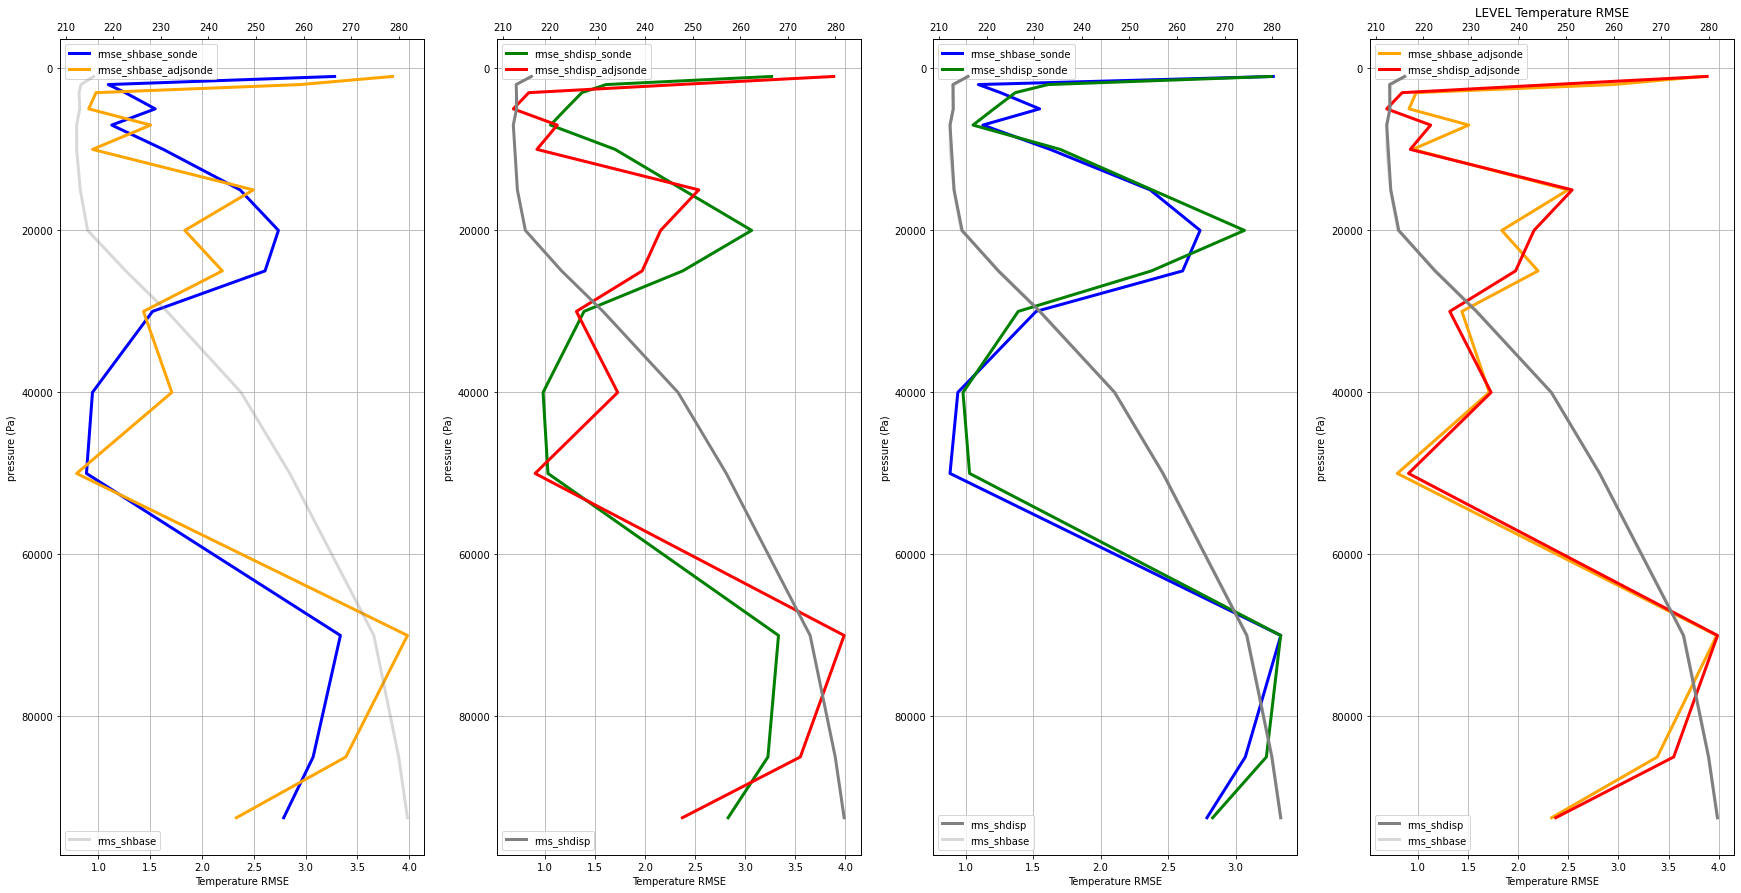

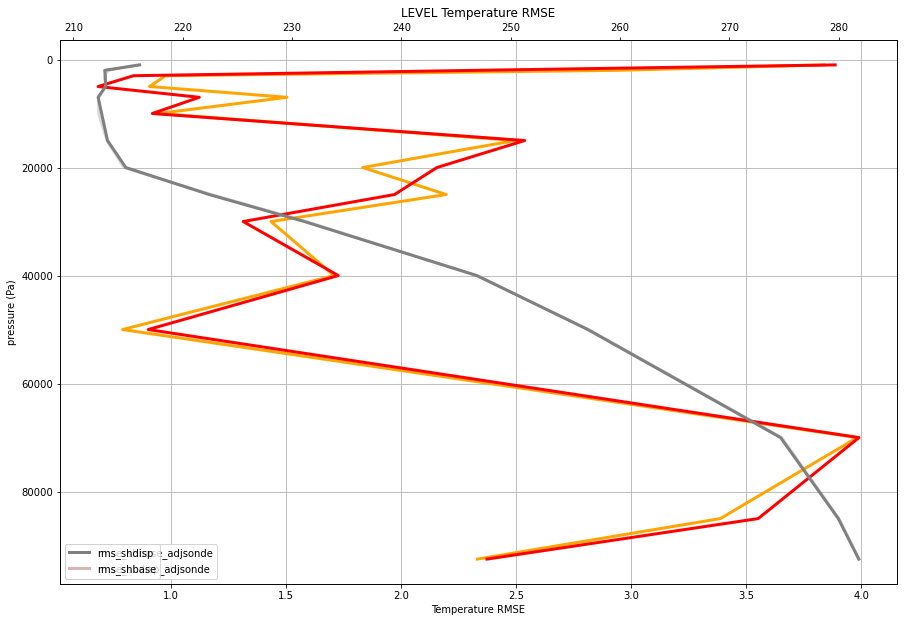

In [19]:
stat = '10393'
statlist = glob.glob('/mnt/users/scratch/leo/scratch/converted_v7/*' + stat + '*_CEUAS_merged_v1.nc')
df = eua.CDMDataset(filename = statlist[0]).to_dataframe(groups=['observations_table', 'era5fb'], variables=['latitude', 'longitude', 'observed_variable', 'observation_value', 'z_coordinate', 'date_time', 'fg_depar@body', 'an_depar@body'])
# 2020 only
df = df[df.date_time.dt.year == 2020]
# night only -> ~ 00:00
df = df[np.isin(df.date_time.dt.hour,[23,0,1])]

from scipy.signal import savgol_filter
stdplevs = [92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]
rmse_sum_shbase_sonde={}
rmse_sum_shbase_adjsonde={}
rmse_sum_shdisp_sonde={}
rmse_sum_shdisp_adjsonde={}
rms_sum_shbase={}
rms_sum_adjsonde={}
rms_sum_sonde={}
rms_sum_shdisp={}

for i in stdplevs:
    rmse_sum_shbase_sonde[i] = []
    rmse_sum_shbase_adjsonde[i] = []
    rmse_sum_shdisp_sonde[i] = []
    rmse_sum_shdisp_adjsonde[i] = []
    rms_sum_shbase[i] = []
    rms_sum_adjsonde[i] = []
    rms_sum_sonde[i] = []
    rms_sum_shdisp[i] = []

for day in df.date_time.drop_duplicates():
    test = df[df.date_time == day]

    t = test[test.observed_variable == 85]
    t = t.rename(columns={'observation_value':'temperature'})
    t = t.drop(columns='observed_variable')

    u = test[test.observed_variable == 104]
    u = u.rename(columns={'observation_value':'u'})
    u = u.drop(columns=['observed_variable', 'fg_depar@body', 'an_depar@body'])

    v = test[test.observed_variable == 105]
    v = v.rename(columns={'observation_value':'v'})
    v = v.drop(columns=['observed_variable', 'fg_depar@body', 'an_depar@body'])

    input_data = pd.merge(t, u, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])
    input_data = pd.merge(input_data, v, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])

    input_data = input_data.dropna()
    phys_model = trj.trajectory(lat=t.latitude.iloc[0], lon=t.longitude.iloc[0], temperature=np.array(input_data.temperature), u=np.array(input_data.u), v=np.array(input_data.v), pressure=np.array(input_data.z_coordinate))


    input_data = input_data.reindex(index=input_data.index[::-1])
    input_data['z'] = np.array(trj.calc_height(np.array(input_data.temperature), np.array(input_data.z_coordinate), jump=False))
    input_data['calc_latd'] = np.array(phys_model[0])
    input_data['calc_lond'] = np.array(phys_model[1])

    test1 = [0] + list(input_data.calc_lond[:-1])
    test2 = [0] + list(input_data.calc_latd[:-1])
    input_data['prev_calc_lond']= test1
    input_data['prev_calc_latd']= test2

    input_data['lat_diff'] = np.array(input_data.calc_latd)- np.array(input_data.prev_calc_latd)
    input_data['lon_diff'] = np.array(input_data.calc_lond)- np.array(input_data.prev_calc_lond)


    input_data = input_data.dropna()


    with open('model_dt_4s_reduced_prev.p', "rb") as input_file:
        model = pickle.load(input_file)

    out = model.predict(input_data[['temperature', 'z_coordinate', 'u', 'v', 'z','latitude', 'longitude' , 'calc_latd', 'calc_lond', 'prev_calc_lond', 'prev_calc_latd', 'lon_diff', 'lat_diff']])

    ml_latd, ml_lond = out.transpose()
    filterlen = int(len(ml_latd)//2)
    if not (filterlen & 0x1):
        filterlen += 1
    input_data['ml_latd'] = np.array(savgol_filter(ml_latd, filterlen, 3))
    input_data['ml_lond'] = np.array(savgol_filter(ml_lond, filterlen, 3))

    input_data = input_data.reset_index()


    ds = xr.load_dataset("./PROGRAMS/"+str(day.year)+"/T3DSH"+str(day.year)+f"{day.month:02d}"+f"{day.day:02d}"+"0000.grib")
    ds_lnsp = xr.load_dataset("./PROGRAMS/"+str(day.year)+"/LNSPANASH"+str(day.year)+f"{day.month:02d}"+f"{day.day:02d}"+"0000.grib")



    igrib = '/scratch/das/mayerj47/era5_sh/lnspana/'+str(day.year)+'/LNSPANASH'+str(day.year)+f"{day.month:02d}"+f"{day.day:02d}"+'0000.grib'
    f = open(igrib)
#     print(f)
    msgid = codes_new_from_file(f, product_kind=CODES_PRODUCT_GRIB)
#     print(msgid)
    pv = codes_get_array(msgid,'pv')

    lnsp = float(ds_lnsp.sel(latitude=[input_data.latitude[0]], longitude=[input_data.longitude[0]], method="nearest").lnsp)
    sp = np.exp(lnsp)

    pv = np.array(pv)
    a = pv[:int(len(pv)/2)]
    b = pv[int(len(pv)/2):]

    p_half = a + b * sp
    base_t = ds.sel(latitude=[input_data.latitude[0]], longitude=[input_data.longitude[0]], method="nearest").t

    t_list = []
    for i in range(len(p_half[:-1])):
        step = find_nearest(input_data.z_coordinate, p_half[i])
        input_data_step = input_data[input_data.z_coordinate == step]
        station_lat = float(input_data.latitude[0]) + np.array(input_data_step.ml_latd)[0]
    #     print(station_lat)
        station_lon = float(input_data.longitude[0]) + np.array(input_data_step.ml_lond)[0]

        ds_now = ds.sel(latitude=[station_lat], longitude=[station_lon], method="nearest")
    #     print('selected lat: ', float(ds_now.latitude))
        t = ds_now.t
        t_list.append(np.array(t)[i][0][0])
    print('lat: ', input_data.latitude[0], 'lon: ', input_data.longitude[0])
    print(stat)
    print(day)
    for i in range(len(stdplevs)):
        if np.abs(stdplevs[i] - find_nearest(p_half[:-1],stdplevs[i])) > 1000:
            print(stdplevs[i] , find_nearest(p_half[:-1],stdplevs[i]))
            rmse_sum_shbase_sonde[stdplevs[i]].append(np.nan)
            rmse_sum_shbase_adjsonde[stdplevs[i]].append(np.nan)
            rmse_sum_shdisp_sonde[stdplevs[i]].append(np.nan)
            rmse_sum_shdisp_adjsonde[stdplevs[i]].append(np.nan)
            rms_sum_shbase[stdplevs[i]].append(np.nan)
            rms_sum_adjsonde[stdplevs[i]].append(np.nan)
            rms_sum_sonde[stdplevs[i]].append(np.nan)
            rms_sum_shdisp[stdplevs[i]].append(np.nan)
        else:
            sq_t = np.squeeze(t)
            t_base = float(sq_t[p_half[:-1] == find_nearest(p_half[:-1],stdplevs[i])])
            t_disp = float(np.array(t_list)[p_half[:-1] == find_nearest(p_half[:-1],stdplevs[i])])
            input_data_step = input_data[input_data.z_coordinate == find_nearest(input_data.z_coordinate, stdplevs[i])]
            t_sonde = float(input_data_step.temperature)
            t_adjsonde = float(input_data_step.temperature) - float(input_data_step['fg_depar@body']) - float(input_data_step['an_depar@body'])
            rmse_sum_shbase_sonde[stdplevs[i]].append(t_base - t_sonde)
            rmse_sum_shbase_adjsonde[stdplevs[i]].append(t_base - t_adjsonde)
            rmse_sum_shdisp_sonde[stdplevs[i]].append(t_disp - t_sonde)
            rmse_sum_shdisp_adjsonde[stdplevs[i]].append(t_disp - t_adjsonde)
            rms_sum_shbase[stdplevs[i]].append(t_base)
            rms_sum_adjsonde[stdplevs[i]].append(t_adjsonde)
            rms_sum_sonde[stdplevs[i]].append(t_sonde)
            rms_sum_shdisp[stdplevs[i]].append(t_disp)
        
        
#     fig, ax1 = maplt.subplots(1, figsize=(16, 8))
#     ax1.plot(np.squeeze(t), np.array(p_half[:-1]), color = 'green', alpha = 0.3, label='base tempterature')
#     ax1.plot(np.array(t_list), np.array(p_half[:-1]), color = 'blue', alpha = 0.6, label='displaced temperature')
#     ax1.plot(np.array(input_data.temperature), np.array(input_data.z_coordinate), color = 'red', alpha = 0.3, label='temperature radio sonde')
#     ax1.plot(np.array(input_data.temperature - input_data['fg_depar@body'] - input_data['an_depar@body'] ), np.array(input_data.z_coordinate), color = 'orange', alpha = 0.6, label='temperature radio sonde - adjusted')
#     ax1.set_ylabel('pressure (Pa)')
#     ax1.set_xlabel('temperature (K)')
#     ax1.tick_params(axis='y')
#     ax1.set_ylim(ax1.get_ylim()[::-1])
#     ax1.legend()
#     ax1.grid()
#     maplt.show()
#     maplt.close()

rmse_shbase_sonde=[]
rmse_shbase_adjsonde=[]
rmse_shdisp_sonde=[]
rmse_shdisp_adjsonde=[]

rms_shbase=[]
rms_adjsonde=[]
rms_sonde=[]
rms_shdisp=[]

for i in range(len(stdplevs)):
    rmse_shbase_sonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shbase_sonde[stdplevs[i]])**2))))
    print('rmse_shbase_sonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shbase_sonde[-1])
    rmse_shbase_adjsonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shbase_adjsonde[stdplevs[i]])**2))))
    print('rmse_shbase_adjsonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shbase_adjsonde[-1])
    rmse_shdisp_sonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shdisp_sonde[stdplevs[i]])**2))))
    print('rmse_shdisp_sonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shdisp_sonde[-1])
    rmse_shdisp_adjsonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shdisp_adjsonde[stdplevs[i]])**2))))
    print('rmse_shdisp_adjsonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shdisp_adjsonde[-1])
    
    rms_shbase.append(np.sqrt(np.nanmean((np.array(rms_sum_shbase[stdplevs[i]])**2))))
    print('rms_shbase - plev: ', stdplevs[i], ' RMS: ', rms_shbase[-1])
    rms_adjsonde.append(np.sqrt(np.nanmean((np.array(rms_sum_adjsonde[stdplevs[i]])**2))))
    print('rms_adjsonde - plev: ', stdplevs[i], ' RMS: ', rms_adjsonde[-1])
    rms_sonde.append(np.sqrt(np.nanmean((np.array(rms_sum_sonde[stdplevs[i]])**2))))
    print('rms_sonde - plev: ', stdplevs[i], ' RMS: ', rms_sonde[-1])
    rms_shdisp.append(np.sqrt(np.nanmean((np.array(rms_sum_shdisp[stdplevs[i]])**2))))
    print('rms_shdisp - plev: ', stdplevs[i], ' RMS: ', rms_shdisp[-1])

print('')
fig, ax1 = maplt.subplots(1,4,figsize = (30,15))

ax1[0].plot(np.array(rmse_shbase_sonde),stdplevs,color = 'blue', label='rmse_shbase_sonde')
ax1[0].plot(np.array(rmse_shbase_adjsonde),stdplevs,color='orange', label='rmse_shbase_adjsonde')
# ax1[0].plot(np.array(rmse_shdisp_sonde),stdplevs, label='rmse_shdisp_sonde')
# ax1[0].plot(np.array(rmse_shdisp_adjsonde),stdplevs, label='rmse_shdisp_adjsonde')
ax1_1 = ax1[0].twiny()
ax1_1.plot(np.array(rms_shbase),stdplevs,color='grey',alpha=0.3, label='rms_shbase')
ax1_1.legend(loc='lower left')
ax1[0].set_ylim(ax1[0].get_ylim()[::-1])
ax1[0].set_ylabel('pressure (Pa)')
ax1[0].set_xlabel('Temperature RMSE')
ax1[0].legend()
ax1[0].grid()

# ax1[1].plot(np.array(rmse_shbase_sonde),stdplevs, label='rmse_shbase_sonde')
# ax1[1].plot(np.array(rmse_shbase_adjsonde),stdplevs, label='rmse_shbase_adjsonde')
ax1[1].plot(np.array(rmse_shdisp_sonde),stdplevs, color='green', label='rmse_shdisp_sonde')
ax1[1].plot(np.array(rmse_shdisp_adjsonde),stdplevs, color='red', label='rmse_shdisp_adjsonde')
ax1_2 = ax1[1].twiny()
ax1_2.plot(np.array(rms_shdisp),stdplevs,color='grey', label='rms_shdisp')
ax1_2.legend(loc='lower left')
ax1[1].set_ylim(ax1[1].get_ylim()[::-1])
ax1[1].set_ylabel('pressure (Pa)')
ax1[1].set_xlabel('Temperature RMSE')
ax1[1].legend()
ax1[1].grid()

ax1[2].plot(np.array(rmse_shbase_sonde),stdplevs,color = 'blue', label='rmse_shbase_sonde')
ax1[2].plot(np.array(rmse_shdisp_sonde),stdplevs, color='green', label='rmse_shdisp_sonde')
ax1_3 = ax1[2].twiny()
ax1_3.plot(np.array(rms_shdisp),stdplevs,color='grey', label='rms_shdisp')
ax1_3.plot(np.array(rms_shbase),stdplevs,color='grey',alpha=0.3, label='rms_shbase')
ax1_3.legend(loc='lower left')
ax1[2].set_ylim(ax1[2].get_ylim()[::-1])
ax1[2].set_ylabel('pressure (Pa)')
ax1[2].set_xlabel('Temperature RMSE')
ax1[2].legend()
ax1[2].grid()

ax1[3].plot(np.array(rmse_shbase_adjsonde),stdplevs,color='orange', label='rmse_shbase_adjsonde')
ax1[3].plot(np.array(rmse_shdisp_adjsonde),stdplevs, color='red', label='rmse_shdisp_adjsonde')
ax1_4 = ax1[3].twiny()
ax1_4.plot(np.array(rms_shdisp),stdplevs,color='grey', label='rms_shdisp')
ax1_4.plot(np.array(rms_shbase),stdplevs,color='grey',alpha=0.3, label='rms_shbase')
ax1_4.legend(loc='lower left')
ax1[3].set_ylim(ax1[3].get_ylim()[::-1])
ax1[3].set_ylabel('pressure (Pa)')
ax1[3].set_xlabel('Temperature RMSE')
ax1[3].legend()
ax1[3].grid()

maplt.title('LEVEL Temperature RMSE')
maplt.show()
maplt.close()

fig, ax1 = maplt.subplots(figsize = (15,10))
ax1.plot(np.array(rmse_shbase_adjsonde),stdplevs,color='orange', label='rmse_shbase_adjsonde')
ax1.plot(np.array(rmse_shdisp_adjsonde),stdplevs, color='red', label='rmse_shdisp_adjsonde')
ax1_4 = ax1.twiny()
ax1_4.plot(np.array(rms_shdisp),stdplevs,color='grey', label='rms_shdisp')
ax1_4.plot(np.array(rms_shbase),stdplevs,color='grey',alpha=0.3, label='rms_shbase')
ax1_4.legend(loc='lower left')
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.set_ylabel('pressure (Pa)')
ax1.set_xlabel('Temperature RMSE')
ax1.legend()
ax1.grid()

maplt.title('LEVEL Temperature RMSE')
maplt.show()
maplt.close()

In [14]:
float(input_data_step.temperature)

204.1300048828125

lat:  52.2093 lon:  14.12041
10393
2020-09-09 00:05:14
lat:  52.2093 lon:  14.12041
10393
2020-11-12 23:49:48
lat:  52.2093 lon:  14.12041
10393
2020-11-14 23:00:29
rmse_shbase_sonde - plev:  92500  RMSE:  2.7881176650563053
rmse_shbase_adjsonde - plev:  92500  RMSE:  2.331742185433426
rmse_shdisp_sonde - plev:  92500  RMSE:  2.830332450033424
rmse_shdisp_adjsonde - plev:  92500  RMSE:  2.373115872660768
rmse_shbase_sonde - plev:  85000  RMSE:  2.875715698237604
rmse_shbase_adjsonde - plev:  85000  RMSE:  2.915311412852095
rmse_shdisp_sonde - plev:  85000  RMSE:  2.9549648798354844
rmse_shdisp_adjsonde - plev:  85000  RMSE:  2.997868739576647
rmse_shbase_sonde - plev:  70000  RMSE:  1.37158203125
rmse_shbase_adjsonde - plev:  70000  RMSE:  1.338958740234375
rmse_shdisp_sonde - plev:  70000  RMSE:  0.93017578125
rmse_shdisp_adjsonde - plev:  70000  RMSE:  0.897552490234375
rmse_shbase_sonde - plev:  50000  RMSE:  0.884984805577274
rmse_shbase_adjsonde - plev:  50000  RMSE:  0.7900385432

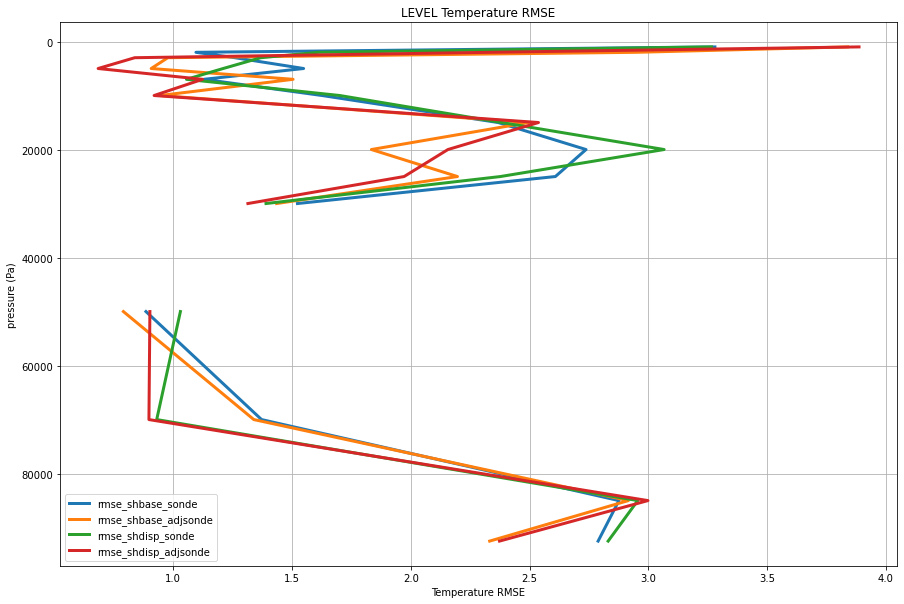

In [8]:
stat = '10393'
statlist = glob.glob('/mnt/users/scratch/leo/scratch/converted_v7/*' + stat + '*_CEUAS_merged_v1.nc')
df = eua.CDMDataset(filename = statlist[0]).to_dataframe(groups=['observations_table', 'era5fb'], variables=['latitude', 'longitude', 'observed_variable', 'observation_value', 'z_coordinate', 'date_time', 'fg_depar@body', 'an_depar@body'])
# 2020 only
df = df[df.date_time.dt.year == 2020]
# night only -> ~ 00:00
df = df[np.isin(df.date_time.dt.hour,[23,0,1])]

from scipy.signal import savgol_filter
stdplevs = [92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]
rmse_sum_shbase_sonde={}
rmse_sum_shbase_adjsonde={}
rmse_sum_shdisp_sonde={}
rmse_sum_shdisp_adjsonde={}

for i in stdplevs:
    rmse_sum_shbase_sonde[i] = []
    rmse_sum_shbase_adjsonde[i] = []
    rmse_sum_shdisp_sonde[i] = []
    rmse_sum_shdisp_adjsonde[i] = []

for day in df.date_time.drop_duplicates():
    test = df[df.date_time == day]

    t = test[test.observed_variable == 85]
    t = t.rename(columns={'observation_value':'temperature'})
    t = t.drop(columns='observed_variable')

    u = test[test.observed_variable == 104]
    u = u.rename(columns={'observation_value':'u'})
    u = u.drop(columns=['observed_variable', 'fg_depar@body', 'an_depar@body'])

    v = test[test.observed_variable == 105]
    v = v.rename(columns={'observation_value':'v'})
    v = v.drop(columns=['observed_variable', 'fg_depar@body', 'an_depar@body'])

    input_data = pd.merge(t, u, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])
    input_data = pd.merge(input_data, v, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])

    input_data = input_data.dropna()
    phys_model = trj.trajectory(lat=t.latitude.iloc[0], lon=t.longitude.iloc[0], temperature=np.array(input_data.temperature), u=np.array(input_data.u), v=np.array(input_data.v), pressure=np.array(input_data.z_coordinate))


    input_data = input_data.reindex(index=input_data.index[::-1])
    input_data['z'] = np.array(trj.calc_height(np.array(input_data.temperature), np.array(input_data.z_coordinate), jump=False))
    input_data['calc_latd'] = np.array(phys_model[0])
    input_data['calc_lond'] = np.array(phys_model[1])

    test1 = [0] + list(input_data.calc_lond[:-1])
    test2 = [0] + list(input_data.calc_latd[:-1])
    input_data['prev_calc_lond']= test1
    input_data['prev_calc_latd']= test2

    input_data['lat_diff'] = np.array(input_data.calc_latd)- np.array(input_data.prev_calc_latd)
    input_data['lon_diff'] = np.array(input_data.calc_lond)- np.array(input_data.prev_calc_lond)


    input_data = input_data.dropna()


    with open('model_dt_4s_reduced_prev.p', "rb") as input_file:
        model = pickle.load(input_file)

    out = model.predict(input_data[['temperature', 'z_coordinate', 'u', 'v', 'z','latitude', 'longitude' , 'calc_latd', 'calc_lond', 'prev_calc_lond', 'prev_calc_latd', 'lon_diff', 'lat_diff']])

    ml_latd, ml_lond = out.transpose()
    filterlen = int(len(ml_latd)//2)
    if not (filterlen & 0x1):
        filterlen += 1
    input_data['ml_latd'] = np.array(savgol_filter(ml_latd, filterlen, 3))
    input_data['ml_lond'] = np.array(savgol_filter(ml_lond, filterlen, 3))

    input_data = input_data.reset_index()


    ds = xr.load_dataset("./PROGRAMS/"+str(day.year)+"/T3DSH"+str(day.year)+f"{day.month:02d}"+f"{day.day:02d}"+"0000.grib")
    ds_lnsp = xr.load_dataset("./PROGRAMS/"+str(day.year)+"/LNSPANASH"+str(day.year)+f"{day.month:02d}"+f"{day.day:02d}"+"0000.grib")



    igrib = '/scratch/das/mayerj47/era5_sh/lnspana/'+str(day.year)+'/LNSPANASH'+str(day.year)+f"{day.month:02d}"+f"{day.day:02d}"+'0000.grib'
    f = open(igrib)
#     print(f)
    msgid = codes_new_from_file(f, product_kind=CODES_PRODUCT_GRIB)
#     print(msgid)
    pv = codes_get_array(msgid,'pv')

    lnsp = float(ds_lnsp.sel(latitude=[input_data.latitude[0]], longitude=[input_data.longitude[0]], method="nearest").lnsp)
    sp = np.exp(lnsp)

    pv = np.array(pv)
    a = pv[:int(len(pv)/2)]
    b = pv[int(len(pv)/2):]

    p_half = a + b * sp
    base_t = ds.sel(latitude=[input_data.latitude[0]], longitude=[input_data.longitude[0]], method="nearest").t

    t_list = []
    for i in range(len(p_half[:-1])):
        step = find_nearest(input_data.z_coordinate, p_half[i])
        input_data_step = input_data[input_data.z_coordinate == step]
        station_lat = input_data.latitude[0] + np.array(input_data_step.ml_latd)[0]
    #     print(station_lat)
        station_lon = input_data.longitude[0] + np.array(input_data_step.ml_lond)[0]

        ds_now = ds.sel(latitude=[station_lat], longitude=[station_lon], method="nearest")
    #     print('selected lat: ', float(ds_now.latitude))
        t = ds_now.t
        t_list.append(np.array(t)[i][0][0])
    print('lat: ', input_data.latitude[0], 'lon: ', input_data.longitude[0])
    print(stat)
    print(day)
    for i in range(len(stdplevs)):
        if np.abs(stdplevs[i] - find_nearest(p_half[:-1],stdplevs[i])) > 500:
#             print(stdplevs[i] , find_nearest(p_half[:-1],stdplevs[i]))
            rmse_sum_shbase_sonde[stdplevs[i]].append(np.nan)
            rmse_sum_shbase_adjsonde[stdplevs[i]].append(np.nan)
            rmse_sum_shdisp_sonde[stdplevs[i]].append(np.nan)
            rmse_sum_shdisp_adjsonde[stdplevs[i]].append(np.nan)
        else:
            sq_t = np.squeeze(t)
            t_base = sq_t[p_half[:-1] == find_nearest(p_half[:-1],stdplevs[i])]
            t_disp = np.array(t_list)[p_half[:-1] == find_nearest(p_half[:-1],stdplevs[i])]

            input_data_step = input_data[input_data.z_coordinate == find_nearest(input_data.z_coordinate, stdplevs[i])]
            t_sonde = input_data_step.temperature
            t_adjsonde = input_data_step.temperature - input_data_step['fg_depar@body'] - input_data_step['an_depar@body']
            
            if(np.isnan(float(t_base))):
                print(t_base)
                raise
            if(np.isnan(float(t_sonde))):
                print(t_sonde)
                raise
            if(np.isnan(float(t_disp))):
                print(t_disp)
                raise
            if(np.isnan(float(t_adjsonde))):
                print(t_adjsonde)
                raise
            rmse_sum_shbase_sonde[stdplevs[i]].append(float(t_base - t_sonde))
            rmse_sum_shbase_adjsonde[stdplevs[i]].append(float(t_base - t_adjsonde))
            rmse_sum_shdisp_sonde[stdplevs[i]].append(float(t_disp - t_sonde))
            rmse_sum_shdisp_adjsonde[stdplevs[i]].append(float(t_disp - t_adjsonde))
        
        
#     fig, ax1 = maplt.subplots(1, figsize=(16, 8))
#     ax1.plot(np.squeeze(t), np.array(p_half[:-1]), color = 'green', alpha = 0.3, label='base tempterature')
#     ax1.plot(np.array(t_list), np.array(p_half[:-1]), color = 'blue', alpha = 0.6, label='displaced temperature')
#     ax1.plot(np.array(input_data.temperature), np.array(input_data.z_coordinate), color = 'red', alpha = 0.3, label='temperature radio sonde')
#     ax1.plot(np.array(input_data.temperature - input_data['fg_depar@body'] - input_data['an_depar@body'] ), np.array(input_data.z_coordinate), color = 'orange', alpha = 0.6, label='temperature radio sonde - adjusted')
#     ax1.set_ylabel('pressure (Pa)')
#     ax1.set_xlabel('temperature (K)')
#     ax1.tick_params(axis='y')
#     ax1.set_ylim(ax1.get_ylim()[::-1])
#     ax1.legend()
#     ax1.grid()
#     maplt.show()
#     maplt.close()

rmse_shbase_sonde=[]
rmse_shbase_adjsonde=[]
rmse_shdisp_sonde=[]
rmse_shdisp_adjsonde=[]

for i in range(len(stdplevs)):
    rmse_shbase_sonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shbase_sonde[stdplevs[i]])**2))))
    print('rmse_shbase_sonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shbase_sonde[-1])
    rmse_shbase_adjsonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shbase_adjsonde[stdplevs[i]])**2))))
    print('rmse_shbase_adjsonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shbase_adjsonde[-1])
    rmse_shdisp_sonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shdisp_sonde[stdplevs[i]])**2))))
    print('rmse_shdisp_sonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shdisp_sonde[-1])
    rmse_shdisp_adjsonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shdisp_adjsonde[stdplevs[i]])**2))))
    print('rmse_shdisp_adjsonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shdisp_adjsonde[-1])

print('')
fig, ax1 = maplt.subplots(figsize = (15,10))
ax1.plot(np.array(rmse_shbase_sonde),stdplevs, label='rmse_shbase_sonde')
ax1.plot(np.array(rmse_shbase_adjsonde),stdplevs, label='rmse_shbase_adjsonde')
ax1.plot(np.array(rmse_shdisp_sonde),stdplevs, label='rmse_shdisp_sonde')
ax1.plot(np.array(rmse_shdisp_adjsonde),stdplevs, label='rmse_shdisp_adjsonde')
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.set_ylabel('pressure (Pa)')
ax1.set_xlabel('Temperature RMSE')
ax1.legend()
ax1.grid()
maplt.title('LEVEL Temperature RMSE')
maplt.show()
maplt.close()

lat:  49.25 lon:  119.7
50527
2020-01-01 23:17:26
lat:  49.25 lon:  119.7
50527
2020-01-02 23:15:27
lat:  49.25 lon:  119.7
50527
2020-01-03 23:19:17
lat:  49.25 lon:  119.7
50527
2020-01-04 23:16:36
lat:  49.25 lon:  119.7
50527
2020-01-05 23:15:14
lat:  49.25 lon:  119.7
50527
2020-01-06 23:16:30
lat:  49.25 lon:  119.7
50527
2020-01-07 23:16:02
lat:  49.25 lon:  119.7
50527
2020-01-08 23:15:32
lat:  49.25 lon:  119.7
50527
2020-01-09 23:19:24
lat:  49.25 lon:  119.7
50527
2020-01-10 23:15:34
lat:  49.25 lon:  119.7
50527
2020-01-11 23:22:20
lat:  49.25 lon:  119.7
50527
2020-01-13 00:05:50
lat:  49.25 lon:  119.7
50527
2020-01-13 23:28:48
lat:  49.25 lon:  119.7
50527
2020-01-14 23:15:24
lat:  49.25 lon:  119.7
50527
2020-01-15 23:15:58
lat:  49.25 lon:  119.7
50527
2020-01-16 23:15:42
lat:  49.25 lon:  119.7
50527
2020-01-17 23:15:47
lat:  49.25 lon:  119.7
50527
2020-01-18 23:15:48
lat:  49.25 lon:  119.7
50527
2020-01-19 23:17:42
lat:  49.25 lon:  119.7
50527
2020-01-20 23:15:53


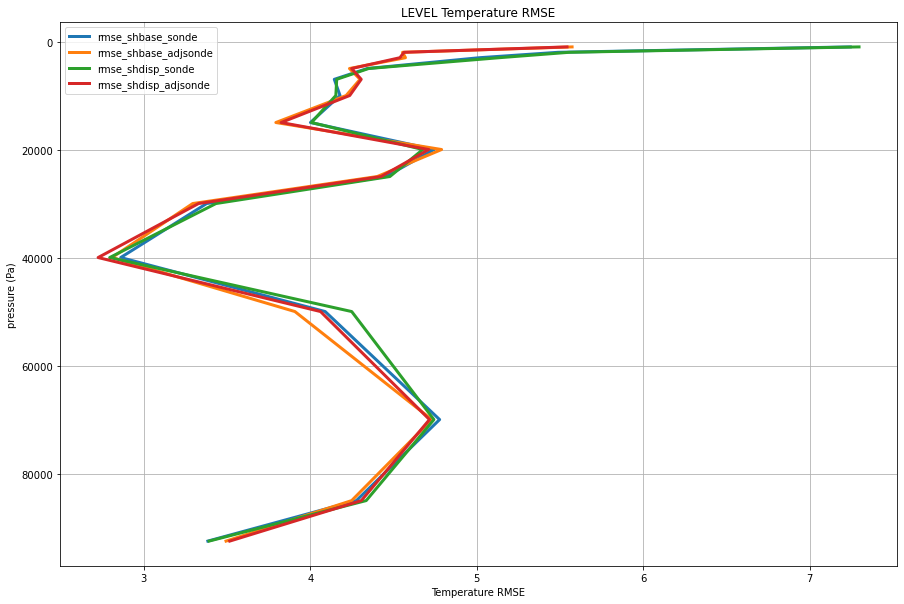

In [7]:
stat = '50527'
statlist = glob.glob('/mnt/users/scratch/leo/scratch/converted_v7/*' + stat + '*_CEUAS_merged_v1.nc')
df = eua.CDMDataset(filename = statlist[0]).to_dataframe(groups=['observations_table', 'era5fb'], variables=['latitude', 'longitude', 'observed_variable', 'observation_value', 'z_coordinate', 'date_time', 'fg_depar@body', 'an_depar@body'])
# 2020 only
df = df[df.date_time.dt.year == 2020]
# night only -> ~ 00:00
df = df[np.isin(df.date_time.dt.hour,[23,0,1])]

from scipy.signal import savgol_filter
stdplevs = [92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]
rmse_sum_shbase_sonde={}
rmse_sum_shbase_adjsonde={}
rmse_sum_shdisp_sonde={}
rmse_sum_shdisp_adjsonde={}

for i in stdplevs:
    rmse_sum_shbase_sonde[i] = []
    rmse_sum_shbase_adjsonde[i] = []
    rmse_sum_shdisp_sonde[i] = []
    rmse_sum_shdisp_adjsonde[i] = []

for day in df.date_time.drop_duplicates():
    test = df[df.date_time == day]

    t = test[test.observed_variable == 85]
    t = t.rename(columns={'observation_value':'temperature'})
    t = t.drop(columns='observed_variable')

    u = test[test.observed_variable == 104]
    u = u.rename(columns={'observation_value':'u'})
    u = u.drop(columns=['observed_variable', 'fg_depar@body', 'an_depar@body'])

    v = test[test.observed_variable == 105]
    v = v.rename(columns={'observation_value':'v'})
    v = v.drop(columns=['observed_variable', 'fg_depar@body', 'an_depar@body'])

    input_data = pd.merge(t, u, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])
    input_data = pd.merge(input_data, v, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])

    input_data = input_data.dropna()
    phys_model = trj.trajectory(lat=t.latitude.iloc[0], lon=t.longitude.iloc[0], temperature=np.array(input_data.temperature), u=np.array(input_data.u), v=np.array(input_data.v), pressure=np.array(input_data.z_coordinate))


    input_data = input_data.reindex(index=input_data.index[::-1])
    input_data['z'] = np.array(trj.calc_height(np.array(input_data.temperature), np.array(input_data.z_coordinate), jump=False))
    input_data['calc_latd'] = np.array(phys_model[0])
    input_data['calc_lond'] = np.array(phys_model[1])

    test1 = [0] + list(input_data.calc_lond[:-1])
    test2 = [0] + list(input_data.calc_latd[:-1])
    input_data['prev_calc_lond']= test1
    input_data['prev_calc_latd']= test2

    input_data['lat_diff'] = np.array(input_data.calc_latd)- np.array(input_data.prev_calc_latd)
    input_data['lon_diff'] = np.array(input_data.calc_lond)- np.array(input_data.prev_calc_lond)


    input_data = input_data.dropna()


    with open('model_dt_4s_reduced_prev.p', "rb") as input_file:
        model = pickle.load(input_file)

    out = model.predict(input_data[['temperature', 'z_coordinate', 'u', 'v', 'z','latitude', 'longitude' , 'calc_latd', 'calc_lond', 'prev_calc_lond', 'prev_calc_latd', 'lon_diff', 'lat_diff']])

    ml_latd, ml_lond = out.transpose()
    filterlen = int(len(ml_latd)//2)
    if not (filterlen & 0x1):
        filterlen += 1
    input_data['ml_latd'] = np.array(savgol_filter(ml_latd, filterlen, 3))
    input_data['ml_lond'] = np.array(savgol_filter(ml_lond, filterlen, 3))

    input_data = input_data.reset_index()


    ds = xr.load_dataset("./PROGRAMS/"+str(day.year)+"/T3DSH"+str(day.year)+f"{day.month:02d}"+f"{day.day:02d}"+"0000.grib")
    ds_lnsp = xr.load_dataset("./PROGRAMS/"+str(day.year)+"/LNSPANASH"+str(day.year)+f"{day.month:02d}"+f"{day.day:02d}"+"0000.grib")



    igrib = '/scratch/das/mayerj47/era5_sh/lnspana/'+str(day.year)+'/LNSPANASH'+str(day.year)+f"{day.month:02d}"+f"{day.day:02d}"+'0000.grib'
    f = open(igrib)
#     print(f)
    msgid = codes_new_from_file(f, product_kind=CODES_PRODUCT_GRIB)
#     print(msgid)
    pv = codes_get_array(msgid,'pv')

    lnsp = float(ds_lnsp.sel(latitude=[input_data.latitude[0]], longitude=[input_data.longitude[0]], method="nearest").lnsp)
    sp = np.exp(lnsp)

    pv = np.array(pv)
    a = pv[:int(len(pv)/2)]
    b = pv[int(len(pv)/2):]

    p_half = a + b * sp
    base_t = ds.sel(latitude=[input_data.latitude[0]], longitude=[input_data.longitude[0]], method="nearest").t

    t_list = []
    for i in range(len(p_half[:-1])):
        step = find_nearest(input_data.z_coordinate, p_half[i])
        input_data_step = input_data[input_data.z_coordinate == step]
        station_lat = input_data.latitude[0] + np.array(input_data_step.ml_latd)[0]
    #     print(station_lat)
        station_lon = input_data.longitude[0] + np.array(input_data_step.ml_lond)[0]

        ds_now = ds.sel(latitude=[station_lat], longitude=[station_lon], method="nearest")
    #     print('selected lat: ', float(ds_now.latitude))
        t = ds_now.t
        t_list.append(np.array(t)[i][0][0])
    print('lat: ', input_data.latitude[0], 'lon: ', input_data.longitude[0])
    print(stat)
    print(day)
    for i in range(len(stdplevs)):
        if np.abs(stdplevs[i] - find_nearest(p_half[:-1],stdplevs[i])) > 500:
#             print(stdplevs[i] , find_nearest(p_half[:-1],stdplevs[i]))
            rmse_sum_shbase_sonde[stdplevs[i]].append(np.nan)
            rmse_sum_shbase_adjsonde[stdplevs[i]].append(np.nan)
            rmse_sum_shdisp_sonde[stdplevs[i]].append(np.nan)
            rmse_sum_shdisp_adjsonde[stdplevs[i]].append(np.nan)
        else:
            sq_t = np.squeeze(t)
            t_base = sq_t[p_half[:-1] == find_nearest(p_half[:-1],stdplevs[i])]
            t_disp = np.array(t_list)[p_half[:-1] == find_nearest(p_half[:-1],stdplevs[i])]

            input_data_step = input_data[input_data.z_coordinate == find_nearest(input_data.z_coordinate, stdplevs[i])]
            t_sonde = input_data_step.temperature
            t_adjsonde = input_data_step.temperature - input_data_step['fg_depar@body'] - input_data_step['an_depar@body']
            
            if(np.isnan(float(t_base))):
                print(t_base)
                raise
            if(np.isnan(float(t_sonde))):
                print(t_sonde)
                raise
            if(np.isnan(float(t_disp))):
                print(t_disp)
                raise
            if(np.isnan(float(t_adjsonde))):
                print(t_adjsonde)
                raise
            rmse_sum_shbase_sonde[stdplevs[i]].append(float(t_base - t_sonde))
            rmse_sum_shbase_adjsonde[stdplevs[i]].append(float(t_base - t_adjsonde))
            rmse_sum_shdisp_sonde[stdplevs[i]].append(float(t_disp - t_sonde))
            rmse_sum_shdisp_adjsonde[stdplevs[i]].append(float(t_disp - t_adjsonde))
        
        
#     fig, ax1 = maplt.subplots(1, figsize=(16, 8))
#     ax1.plot(np.squeeze(t), np.array(p_half[:-1]), color = 'green', alpha = 0.3, label='base tempterature')
#     ax1.plot(np.array(t_list), np.array(p_half[:-1]), color = 'blue', alpha = 0.6, label='displaced temperature')
#     ax1.plot(np.array(input_data.temperature), np.array(input_data.z_coordinate), color = 'red', alpha = 0.3, label='temperature radio sonde')
#     ax1.plot(np.array(input_data.temperature - input_data['fg_depar@body'] - input_data['an_depar@body'] ), np.array(input_data.z_coordinate), color = 'orange', alpha = 0.6, label='temperature radio sonde - adjusted')
#     ax1.set_ylabel('pressure (Pa)')
#     ax1.set_xlabel('temperature (K)')
#     ax1.tick_params(axis='y')
#     ax1.set_ylim(ax1.get_ylim()[::-1])
#     ax1.legend()
#     ax1.grid()
#     maplt.show()
#     maplt.close()

rmse_shbase_sonde=[]
rmse_shbase_adjsonde=[]
rmse_shdisp_sonde=[]
rmse_shdisp_adjsonde=[]

for i in range(len(stdplevs)):
    rmse_shbase_sonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shbase_sonde[stdplevs[i]])**2))))
    print('rmse_shbase_sonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shbase_sonde[-1])
    rmse_shbase_adjsonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shbase_adjsonde[stdplevs[i]])**2))))
    print('rmse_shbase_adjsonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shbase_adjsonde[-1])
    rmse_shdisp_sonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shdisp_sonde[stdplevs[i]])**2))))
    print('rmse_shdisp_sonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shdisp_sonde[-1])
    rmse_shdisp_adjsonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shdisp_adjsonde[stdplevs[i]])**2))))
    print('rmse_shdisp_adjsonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shdisp_adjsonde[-1])

print('')
fig, ax1 = maplt.subplots(figsize = (15,10))
ax1.plot(np.array(rmse_shbase_sonde),stdplevs, label='rmse_shbase_sonde')
ax1.plot(np.array(rmse_shbase_adjsonde),stdplevs, label='rmse_shbase_adjsonde')
ax1.plot(np.array(rmse_shdisp_sonde),stdplevs, label='rmse_shdisp_sonde')
ax1.plot(np.array(rmse_shdisp_adjsonde),stdplevs, label='rmse_shdisp_adjsonde')
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.set_ylabel('pressure (Pa)')
ax1.set_xlabel('Temperature RMSE')
ax1.legend()
ax1.grid()
maplt.title('LEVEL Temperature RMSE')
maplt.show()
maplt.close()

In [9]:
stat = '72357'
statlist = glob.glob('/mnt/users/scratch/leo/scratch/converted_v7/*' + stat + '*_CEUAS_merged_v1.nc')
df = eua.CDMDataset(filename = statlist[0]).to_dataframe(groups=['observations_table', 'era5fb'], variables=['latitude', 'longitude', 'observed_variable', 'observation_value', 'z_coordinate', 'date_time', 'fg_depar@body', 'an_depar@body'])
# 2020 only
df = df[df.date_time.dt.year == 2020]
# night only -> ~ 00:00
df = df[np.isin(df.date_time.dt.hour,[23,0,1])]

from scipy.signal import savgol_filter
stdplevs = [92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]
rmse_sum_shbase_sonde={}
rmse_sum_shbase_adjsonde={}
rmse_sum_shdisp_sonde={}
rmse_sum_shdisp_adjsonde={}

for i in stdplevs:
    rmse_sum_shbase_sonde[i] = []
    rmse_sum_shbase_adjsonde[i] = []
    rmse_sum_shdisp_sonde[i] = []
    rmse_sum_shdisp_adjsonde[i] = []

for day in df.date_time.drop_duplicates():
    test = df[df.date_time == day]

    t = test[test.observed_variable == 85]
    t = t.rename(columns={'observation_value':'temperature'})
    t = t.drop(columns='observed_variable')

    u = test[test.observed_variable == 104]
    u = u.rename(columns={'observation_value':'u'})
    u = u.drop(columns=['observed_variable', 'fg_depar@body', 'an_depar@body'])

    v = test[test.observed_variable == 105]
    v = v.rename(columns={'observation_value':'v'})
    v = v.drop(columns=['observed_variable', 'fg_depar@body', 'an_depar@body'])

    input_data = pd.merge(t, u, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])
    input_data = pd.merge(input_data, v, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])

    input_data = input_data.dropna()
    phys_model = trj.trajectory(lat=t.latitude.iloc[0], lon=t.longitude.iloc[0], temperature=np.array(input_data.temperature), u=np.array(input_data.u), v=np.array(input_data.v), pressure=np.array(input_data.z_coordinate))


    input_data = input_data.reindex(index=input_data.index[::-1])
    input_data['z'] = np.array(trj.calc_height(np.array(input_data.temperature), np.array(input_data.z_coordinate), jump=False))
    input_data['calc_latd'] = np.array(phys_model[0])
    input_data['calc_lond'] = np.array(phys_model[1])

    test1 = [0] + list(input_data.calc_lond[:-1])
    test2 = [0] + list(input_data.calc_latd[:-1])
    input_data['prev_calc_lond']= test1
    input_data['prev_calc_latd']= test2

    input_data['lat_diff'] = np.array(input_data.calc_latd)- np.array(input_data.prev_calc_latd)
    input_data['lon_diff'] = np.array(input_data.calc_lond)- np.array(input_data.prev_calc_lond)


    input_data = input_data.dropna()


    with open('model_dt_4s_reduced_prev.p', "rb") as input_file:
        model = pickle.load(input_file)

    out = model.predict(input_data[['temperature', 'z_coordinate', 'u', 'v', 'z','latitude', 'longitude' , 'calc_latd', 'calc_lond', 'prev_calc_lond', 'prev_calc_latd', 'lon_diff', 'lat_diff']])

    ml_latd, ml_lond = out.transpose()
    filterlen = int(len(ml_latd)//2)
    if not (filterlen & 0x1):
        filterlen += 1
    input_data['ml_latd'] = np.array(savgol_filter(ml_latd, filterlen, 3))
    input_data['ml_lond'] = np.array(savgol_filter(ml_lond, filterlen, 3))

    input_data = input_data.reset_index()


    ds = xr.load_dataset("./PROGRAMS/"+str(day.year)+"/T3DSH"+str(day.year)+f"{day.month:02d}"+f"{day.day:02d}"+"0000.grib")
    ds_lnsp = xr.load_dataset("./PROGRAMS/"+str(day.year)+"/LNSPANASH"+str(day.year)+f"{day.month:02d}"+f"{day.day:02d}"+"0000.grib")



    igrib = '/scratch/das/mayerj47/era5_sh/lnspana/'+str(day.year)+'/LNSPANASH'+str(day.year)+f"{day.month:02d}"+f"{day.day:02d}"+'0000.grib'
    f = open(igrib)
#     print(f)
    msgid = codes_new_from_file(f, product_kind=CODES_PRODUCT_GRIB)
#     print(msgid)
    pv = codes_get_array(msgid,'pv')

    lnsp = float(ds_lnsp.sel(latitude=[input_data.latitude[0]], longitude=[input_data.longitude[0]], method="nearest").lnsp)
    sp = np.exp(lnsp)

    pv = np.array(pv)
    a = pv[:int(len(pv)/2)]
    b = pv[int(len(pv)/2):]

    p_half = a + b * sp
    base_t = ds.sel(latitude=[input_data.latitude[0]], longitude=[input_data.longitude[0]], method="nearest").t

    t_list = []
    for i in range(len(p_half[:-1])):
        step = find_nearest(input_data.z_coordinate, p_half[i])
        input_data_step = input_data[input_data.z_coordinate == step]
        station_lat = input_data.latitude[0] + np.array(input_data_step.ml_latd)[0]
    #     print(station_lat)
        station_lon = input_data.longitude[0] + np.array(input_data_step.ml_lond)[0]

        ds_now = ds.sel(latitude=[station_lat], longitude=[station_lon], method="nearest")
    #     print('selected lat: ', float(ds_now.latitude))
        t = ds_now.t
        t_list.append(np.array(t)[i][0][0])
    print('lat: ', input_data.latitude[0], 'lon: ', input_data.longitude[0])
    print(stat)
    print(day)
    for i in range(len(stdplevs)):
        if np.abs(stdplevs[i] - find_nearest(p_half[:-1],stdplevs[i])) > 500:
#             print(stdplevs[i] , find_nearest(p_half[:-1],stdplevs[i]))
            rmse_sum_shbase_sonde[stdplevs[i]].append(np.nan)
            rmse_sum_shbase_adjsonde[stdplevs[i]].append(np.nan)
            rmse_sum_shdisp_sonde[stdplevs[i]].append(np.nan)
            rmse_sum_shdisp_adjsonde[stdplevs[i]].append(np.nan)
        else:
            sq_t = np.squeeze(t)
            t_base = sq_t[p_half[:-1] == find_nearest(p_half[:-1],stdplevs[i])]
            t_disp = np.array(t_list)[p_half[:-1] == find_nearest(p_half[:-1],stdplevs[i])]

            input_data_step = input_data[input_data.z_coordinate == find_nearest(input_data.z_coordinate, stdplevs[i])]
            t_sonde = input_data_step.temperature
            t_adjsonde = input_data_step.temperature - input_data_step['fg_depar@body'] - input_data_step['an_depar@body']
            
            if(np.isnan(float(t_base))):
                print(t_base)
                raise
            if(np.isnan(float(t_sonde))):
                print(t_sonde)
                raise
            if(np.isnan(float(t_disp))):
                print(t_disp)
                raise
            if(np.isnan(float(t_adjsonde))):
                print(t_adjsonde)
                raise
            rmse_sum_shbase_sonde[stdplevs[i]].append(float(t_base - t_sonde))
            rmse_sum_shbase_adjsonde[stdplevs[i]].append(float(t_base - t_adjsonde))
            rmse_sum_shdisp_sonde[stdplevs[i]].append(float(t_disp - t_sonde))
            rmse_sum_shdisp_adjsonde[stdplevs[i]].append(float(t_disp - t_adjsonde))
        
        
#     fig, ax1 = maplt.subplots(1, figsize=(16, 8))
#     ax1.plot(np.squeeze(t), np.array(p_half[:-1]), color = 'green', alpha = 0.3, label='base tempterature')
#     ax1.plot(np.array(t_list), np.array(p_half[:-1]), color = 'blue', alpha = 0.6, label='displaced temperature')
#     ax1.plot(np.array(input_data.temperature), np.array(input_data.z_coordinate), color = 'red', alpha = 0.3, label='temperature radio sonde')
#     ax1.plot(np.array(input_data.temperature - input_data['fg_depar@body'] - input_data['an_depar@body'] ), np.array(input_data.z_coordinate), color = 'orange', alpha = 0.6, label='temperature radio sonde - adjusted')
#     ax1.set_ylabel('pressure (Pa)')
#     ax1.set_xlabel('temperature (K)')
#     ax1.tick_params(axis='y')
#     ax1.set_ylim(ax1.get_ylim()[::-1])
#     ax1.legend()
#     ax1.grid()
#     maplt.show()
#     maplt.close()

rmse_shbase_sonde=[]
rmse_shbase_adjsonde=[]
rmse_shdisp_sonde=[]
rmse_shdisp_adjsonde=[]

for i in range(len(stdplevs)):
    rmse_shbase_sonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shbase_sonde[stdplevs[i]])**2))))
    print('rmse_shbase_sonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shbase_sonde[-1])
    rmse_shbase_adjsonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shbase_adjsonde[stdplevs[i]])**2))))
    print('rmse_shbase_adjsonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shbase_adjsonde[-1])
    rmse_shdisp_sonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shdisp_sonde[stdplevs[i]])**2))))
    print('rmse_shdisp_sonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shdisp_sonde[-1])
    rmse_shdisp_adjsonde.append(np.sqrt(np.nanmean((np.array(rmse_sum_shdisp_adjsonde[stdplevs[i]])**2))))
    print('rmse_shdisp_adjsonde - plev: ', stdplevs[i], ' RMSE: ', rmse_shdisp_adjsonde[-1])

print('')
fig, ax1 = maplt.subplots(figsize = (15,10))
ax1.plot(np.array(rmse_shbase_sonde),stdplevs, label='rmse_shbase_sonde')
ax1.plot(np.array(rmse_shbase_adjsonde),stdplevs, label='rmse_shbase_adjsonde')
ax1.plot(np.array(rmse_shdisp_sonde),stdplevs, label='rmse_shdisp_sonde')
ax1.plot(np.array(rmse_shdisp_adjsonde),stdplevs, label='rmse_shdisp_adjsonde')
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.set_ylabel('pressure (Pa)')
ax1.set_xlabel('Temperature RMSE')
ax1.legend()
ax1.grid()
maplt.title('LEVEL Temperature RMSE')
maplt.show()
maplt.close()

lat:  35.18 lon:  -97.44
72357
2020-01-01 00:00:00
lat:  35.18 lon:  -97.44
72357
2020-01-02 00:00:00
lat:  35.18 lon:  -97.44
72357
2020-01-03 00:00:00
lat:  35.18 lon:  -97.44
72357
2020-01-04 00:00:00
lat:  35.18 lon:  -97.44
72357
2020-01-05 00:00:00
lat:  35.18 lon:  -97.44
72357
2020-01-06 00:00:00
lat:  35.18 lon:  -97.44
72357
2020-01-07 00:00:00
lat:  35.18 lon:  -97.44
72357
2020-01-08 00:00:00
lat:  35.18 lon:  -97.44
72357
2020-01-09 00:00:00
lat:  35.18 lon:  -97.44
72357
2020-01-10 00:00:00
lat:  35.18 lon:  -97.44
72357
2020-01-11 00:00:00
lat:  35.18 lon:  -97.44
72357
2020-01-12 00:00:00
lat:  35.18 lon:  -97.44
72357
2020-01-13 00:00:00
lat:  35.18 lon:  -97.44
72357
2020-01-14 00:00:00
lat:  35.18 lon:  -97.44
72357
2020-01-15 00:00:00
lat:  35.18 lon:  -97.44
72357
2020-01-16 00:00:00
lat:  35.18 lon:  -97.44
72357
2020-01-17 00:00:00
lat:  35.18 lon:  -97.44
72357
2020-01-18 00:00:00
lat:  35.18 lon:  -97.44
72357
2020-01-19 00:00:00
lat:  35.18 lon:  -97.44
72357


ValueError: polyorder must be less than window_length.

<_io.TextIOWrapper name='/scratch/das/mayerj47/era5_sh/lnspana/2020/LNSPANASH202012311700.grib' mode='r' encoding='UTF-8'>
94179332370144
lat:  49.25 lon:  119.7
50527
2020-12-30 23:15:27


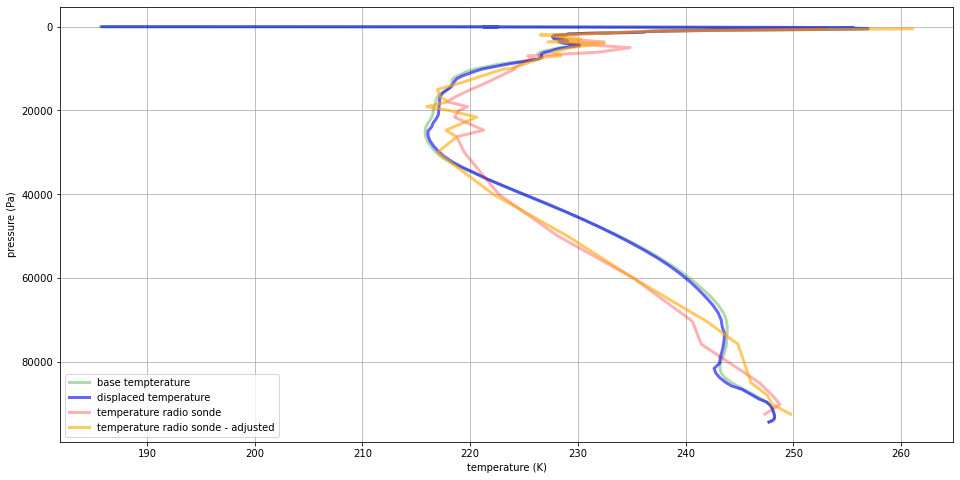

In [54]:
stat = '50527'
date_time = '2020-12-30 23:15:27'
statlist = glob.glob('/mnt/users/scratch/leo/scratch/converted_v7/*' + stat + '*_CEUAS_merged_v1.nc')
df = eua.CDMDataset(filename = statlist[0]).to_dataframe(groups=['observations_table', 'era5fb'], variables=['latitude', 'longitude', 'observed_variable', 'observation_value', 'z_coordinate', 'date_time', 'fg_depar@body', 'an_depar@body'])
test = df[df.date_time == date_time]

t = test[test.observed_variable == 85]
t = t.rename(columns={'observation_value':'temperature'})
t = t.drop(columns='observed_variable')

u = test[test.observed_variable == 104]
u = u.rename(columns={'observation_value':'u'})
u = u.drop(columns=['observed_variable', 'fg_depar@body', 'an_depar@body'])

v = test[test.observed_variable == 105]
v = v.rename(columns={'observation_value':'v'})
v = v.drop(columns=['observed_variable', 'fg_depar@body', 'an_depar@body'])

input_data = pd.merge(t, u, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])
input_data = pd.merge(input_data, v, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])

input_data = input_data.dropna()
phys_model = trj.trajectory(lat=t.latitude.iloc[0], lon=t.longitude.iloc[0], temperature=np.array(input_data.temperature), u=np.array(input_data.u), v=np.array(input_data.v), pressure=np.array(input_data.z_coordinate))


input_data = input_data.reindex(index=input_data.index[::-1])
input_data['z'] = np.array(trj.calc_height(np.array(input_data.temperature), np.array(input_data.z_coordinate), jump=False))
input_data['calc_latd'] = np.array(phys_model[0])
input_data['calc_lond'] = np.array(phys_model[1])

test1 = [0] + list(input_data.calc_lond[:-1])
test2 = [0] + list(input_data.calc_latd[:-1])
input_data['prev_calc_lond']= test1
input_data['prev_calc_latd']= test2

input_data['lat_diff'] = np.array(input_data.calc_latd)- np.array(input_data.prev_calc_latd)
input_data['lon_diff'] = np.array(input_data.calc_lond)- np.array(input_data.prev_calc_lond)


input_data = input_data.dropna()


with open('model_dt_4s_reduced_prev.p', "rb") as input_file:
    model = pickle.load(input_file)
    
out = model.predict(input_data[['temperature', 'z_coordinate', 'u', 'v', 'z','latitude', 'longitude' , 'calc_latd', 'calc_lond', 'prev_calc_lond', 'prev_calc_latd', 'lon_diff', 'lat_diff']])

ml_latd, ml_lond = out.transpose()
input_data['ml_latd'] = ml_latd
input_data['ml_lond'] = ml_lond

input_data = input_data.reset_index()


ds = xr.load_dataset("./PROGRAMS/outputtest.grib")
ds_lnsp = xr.load_dataset("./PROGRAMS/outputtest_lnsp.grib")



igrib = '/scratch/das/mayerj47/era5_sh/lnspana/2020/LNSPANASH202012311700.grib'
f = open(igrib)
print(f)
msgid = codes_new_from_file(f, product_kind=CODES_PRODUCT_GRIB)
print(msgid)
pv = codes_get_array(msgid,'pv')

lnsp = float(ds_lnsp.sel(latitude=[input_data.latitude[0]], longitude=[input_data.longitude[0]], method="nearest").lnsp)
sp = np.exp(lnsp)

pv = np.array(pv)
a = pv[:int(len(pv)/2)]
b = pv[int(len(pv)/2):]

p_half = a + b * sp
base_t = ds.sel(latitude=[input_data.latitude[0]], longitude=[input_data.longitude[0]], method="nearest").t

t_list = []
for i in range(len(p_half[:-1])):
    step = find_nearest(input_data.z_coordinate, p_half[i])
    input_data_step = input_data[input_data.z_coordinate == step]
    station_lat = input_data.latitude[0] + np.array(input_data_step.ml_latd)[0]
#     print(station_lat)
    station_lon = input_data.longitude[0] + np.array(input_data_step.ml_lond)[0]

    ds_now = ds.sel(latitude=[station_lat], longitude=[station_lon], method="nearest")
#     print('selected lat: ', float(ds_now.latitude))
    t = ds_now.t
    t_list.append(np.array(t)[i][0][0])
print('lat: ', input_data.latitude[0], 'lon: ', input_data.longitude[0])
print(stat)
print(date_time)
fig, ax1 = maplt.subplots(1, figsize=(16, 8))
ax1.plot(np.squeeze(t), np.array(p_half[:-1]), color = 'green', alpha = 0.3, label='base tempterature')
ax1.plot(np.array(t_list), np.array(p_half[:-1]), color = 'blue', alpha = 0.6, label='displaced temperature')
ax1.plot(np.array(input_data.temperature), np.array(input_data.z_coordinate), color = 'red', alpha = 0.3, label='temperature radio sonde')
ax1.plot(np.array(input_data.temperature - input_data['fg_depar@body'] - input_data['an_depar@body'] ), np.array(input_data.z_coordinate), color = 'orange', alpha = 0.6, label='temperature radio sonde - adjusted')
ax1.set_ylabel('pressure (Pa)')
ax1.set_xlabel('temperature (K)')
ax1.tick_params(axis='y')
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.legend()
ax1.grid()

<_io.TextIOWrapper name='/scratch/das/mayerj47/era5_sh/lnspana/2020/LNSPANASH202012311700.grib' mode='r' encoding='UTF-8'>
94179410970544
lat:  48.24895 lon:  16.35718
11035
2020-12-30 23:31:43


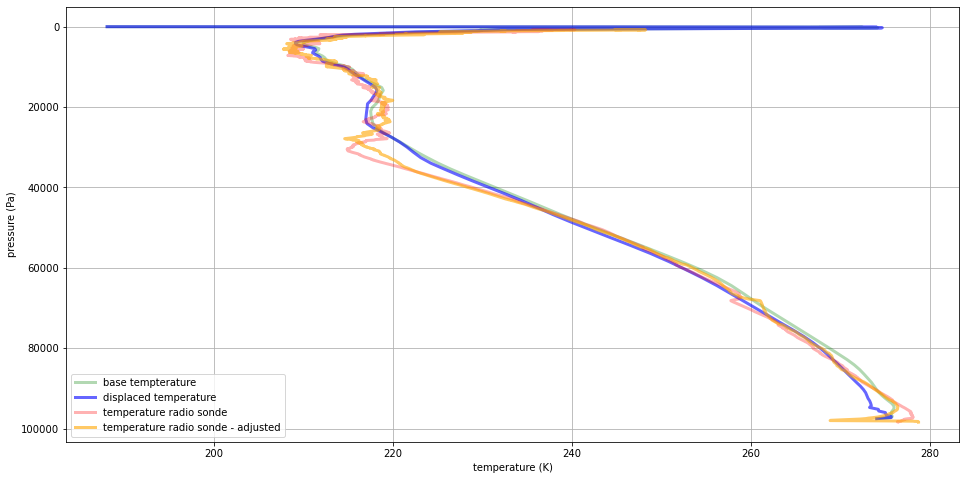

In [55]:
stat = '11035'
date_time = '2020-12-30 23:31:43'
statlist = glob.glob('/mnt/users/scratch/leo/scratch/converted_v7/*' + stat + '*_CEUAS_merged_v1.nc')
df = eua.CDMDataset(filename = statlist[0]).to_dataframe(groups=['observations_table', 'era5fb'], variables=['latitude', 'longitude', 'observed_variable', 'observation_value', 'z_coordinate', 'date_time', 'fg_depar@body', 'an_depar@body'])
test = df[df.date_time == date_time]

t = test[test.observed_variable == 85]
t = t.rename(columns={'observation_value':'temperature'})
t = t.drop(columns='observed_variable')

u = test[test.observed_variable == 104]
u = u.rename(columns={'observation_value':'u'})
u = u.drop(columns=['observed_variable', 'fg_depar@body', 'an_depar@body'])

v = test[test.observed_variable == 105]
v = v.rename(columns={'observation_value':'v'})
v = v.drop(columns=['observed_variable', 'fg_depar@body', 'an_depar@body'])

input_data = pd.merge(t, u, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])
input_data = pd.merge(input_data, v, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])

input_data = input_data.dropna()
phys_model = trj.trajectory(lat=t.latitude.iloc[0], lon=t.longitude.iloc[0], temperature=np.array(input_data.temperature), u=np.array(input_data.u), v=np.array(input_data.v), pressure=np.array(input_data.z_coordinate))


input_data = input_data.reindex(index=input_data.index[::-1])
input_data['z'] = np.array(trj.calc_height(np.array(input_data.temperature), np.array(input_data.z_coordinate), jump=False))
input_data['calc_latd'] = np.array(phys_model[0])
input_data['calc_lond'] = np.array(phys_model[1])

test1 = [0] + list(input_data.calc_lond[:-1])
test2 = [0] + list(input_data.calc_latd[:-1])
input_data['prev_calc_lond']= test1
input_data['prev_calc_latd']= test2

input_data['lat_diff'] = np.array(input_data.calc_latd)- np.array(input_data.prev_calc_latd)
input_data['lon_diff'] = np.array(input_data.calc_lond)- np.array(input_data.prev_calc_lond)


input_data = input_data.dropna()


with open('model_dt_4s_reduced_prev.p', "rb") as input_file:
    model = pickle.load(input_file)
    
out = model.predict(input_data[['temperature', 'z_coordinate', 'u', 'v', 'z','latitude', 'longitude' , 'calc_latd', 'calc_lond', 'prev_calc_lond', 'prev_calc_latd', 'lon_diff', 'lat_diff']])

ml_latd, ml_lond = out.transpose()
input_data['ml_latd'] = ml_latd
input_data['ml_lond'] = ml_lond

input_data = input_data.reset_index()


ds = xr.load_dataset("./PROGRAMS/outputtest.grib")
ds_lnsp = xr.load_dataset("./PROGRAMS/outputtest_lnsp.grib")



igrib = '/scratch/das/mayerj47/era5_sh/lnspana/2020/LNSPANASH202012311700.grib'
f = open(igrib)
print(f)
msgid = codes_new_from_file(f, product_kind=CODES_PRODUCT_GRIB)
print(msgid)
pv = codes_get_array(msgid,'pv')

lnsp = float(ds_lnsp.sel(latitude=[input_data.latitude[0]], longitude=[input_data.longitude[0]], method="nearest").lnsp)
sp = np.exp(lnsp)

pv = np.array(pv)
a = pv[:int(len(pv)/2)]
b = pv[int(len(pv)/2):]

p_half = a + b * sp
base_t = ds.sel(latitude=[input_data.latitude[0]], longitude=[input_data.longitude[0]], method="nearest").t

t_list = []
for i in range(len(p_half[:-1])):
    step = find_nearest(input_data.z_coordinate, p_half[i])
    input_data_step = input_data[input_data.z_coordinate == step]
    station_lat = input_data.latitude[0] + np.array(input_data_step.ml_latd)[0]
#     print(station_lat)
    station_lon = input_data.longitude[0] + np.array(input_data_step.ml_lond)[0]

    ds_now = ds.sel(latitude=[station_lat], longitude=[station_lon], method="nearest")
#     print('selected lat: ', float(ds_now.latitude))
    t = ds_now.t
    t_list.append(np.array(t)[i][0][0])
print('lat: ', input_data.latitude[0], 'lon: ', input_data.longitude[0])
print(stat)
print(date_time)
fig, ax1 = maplt.subplots(1, figsize=(16, 8))
ax1.plot(np.squeeze(t), np.array(p_half[:-1]), color = 'green', alpha = 0.3, label='base tempterature')
ax1.plot(np.array(t_list), np.array(p_half[:-1]), color = 'blue', alpha = 0.6, label='displaced temperature')
ax1.plot(np.array(input_data.temperature), np.array(input_data.z_coordinate), color = 'red', alpha = 0.3, label='temperature radio sonde')
ax1.plot(np.array(input_data.temperature - input_data['fg_depar@body'] - input_data['an_depar@body'] ), np.array(input_data.z_coordinate), color = 'orange', alpha = 0.6, label='temperature radio sonde - adjusted')
ax1.set_ylabel('pressure (Pa)')
ax1.set_xlabel('temperature (K)')
ax1.tick_params(axis='y')
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.legend()
ax1.grid()

<_io.TextIOWrapper name='/scratch/das/mayerj47/era5_sh/lnspana/2020/LNSPANASH202012311700.grib' mode='r' encoding='UTF-8'>
94179481803984
lat:  52.2093 lon:  14.12041
10393
2020-12-30 22:45:14


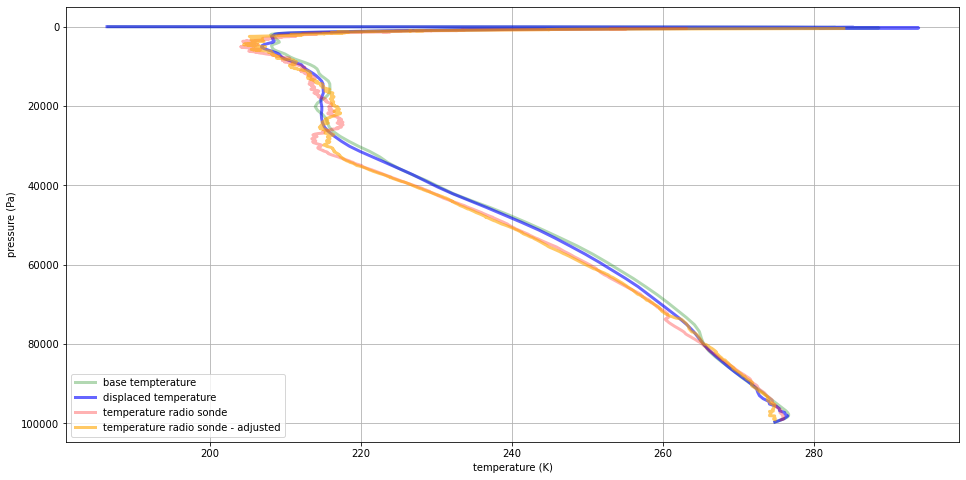

In [57]:
stat = '10393'
date_time = '2020-12-30 22:45:14'
statlist = glob.glob('/mnt/users/scratch/leo/scratch/converted_v7/*' + stat + '*_CEUAS_merged_v1.nc')
df = eua.CDMDataset(filename = statlist[0]).to_dataframe(groups=['observations_table', 'era5fb'], variables=['latitude', 'longitude', 'observed_variable', 'observation_value', 'z_coordinate', 'date_time', 'fg_depar@body', 'an_depar@body'])
test = df[df.date_time == date_time]

t = test[test.observed_variable == 85]
t = t.rename(columns={'observation_value':'temperature'})
t = t.drop(columns='observed_variable')

u = test[test.observed_variable == 104]
u = u.rename(columns={'observation_value':'u'})
u = u.drop(columns=['observed_variable', 'fg_depar@body', 'an_depar@body'])

v = test[test.observed_variable == 105]
v = v.rename(columns={'observation_value':'v'})
v = v.drop(columns=['observed_variable', 'fg_depar@body', 'an_depar@body'])

input_data = pd.merge(t, u, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])
input_data = pd.merge(input_data, v, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])

input_data = input_data.dropna()
phys_model = trj.trajectory(lat=t.latitude.iloc[0], lon=t.longitude.iloc[0], temperature=np.array(input_data.temperature), u=np.array(input_data.u), v=np.array(input_data.v), pressure=np.array(input_data.z_coordinate))


input_data = input_data.reindex(index=input_data.index[::-1])
input_data['z'] = np.array(trj.calc_height(np.array(input_data.temperature), np.array(input_data.z_coordinate), jump=False))
input_data['calc_latd'] = np.array(phys_model[0])
input_data['calc_lond'] = np.array(phys_model[1])

test1 = [0] + list(input_data.calc_lond[:-1])
test2 = [0] + list(input_data.calc_latd[:-1])
input_data['prev_calc_lond']= test1
input_data['prev_calc_latd']= test2

input_data['lat_diff'] = np.array(input_data.calc_latd)- np.array(input_data.prev_calc_latd)
input_data['lon_diff'] = np.array(input_data.calc_lond)- np.array(input_data.prev_calc_lond)


input_data = input_data.dropna()


with open('model_dt_4s_reduced_prev.p', "rb") as input_file:
    model = pickle.load(input_file)
    
out = model.predict(input_data[['temperature', 'z_coordinate', 'u', 'v', 'z','latitude', 'longitude' , 'calc_latd', 'calc_lond', 'prev_calc_lond', 'prev_calc_latd', 'lon_diff', 'lat_diff']])

ml_latd, ml_lond = out.transpose()
input_data['ml_latd'] = ml_latd
input_data['ml_lond'] = ml_lond

input_data = input_data.reset_index()


ds = xr.load_dataset("./PROGRAMS/outputtest.grib")
ds_lnsp = xr.load_dataset("./PROGRAMS/outputtest_lnsp.grib")



igrib = '/scratch/das/mayerj47/era5_sh/lnspana/2020/LNSPANASH202012311700.grib'
f = open(igrib)
print(f)
msgid = codes_new_from_file(f, product_kind=CODES_PRODUCT_GRIB)
print(msgid)
pv = codes_get_array(msgid,'pv')

lnsp = float(ds_lnsp.sel(latitude=[input_data.latitude[0]], longitude=[input_data.longitude[0]], method="nearest").lnsp)
sp = np.exp(lnsp)

pv = np.array(pv)
a = pv[:int(len(pv)/2)]
b = pv[int(len(pv)/2):]

p_half = a + b * sp
base_t = ds.sel(latitude=[input_data.latitude[0]], longitude=[input_data.longitude[0]], method="nearest").t

t_list = []
for i in range(len(p_half[:-1])):
    step = find_nearest(input_data.z_coordinate, p_half[i])
    input_data_step = input_data[input_data.z_coordinate == step]
    station_lat = input_data.latitude[0] + np.array(input_data_step.ml_latd)[0]
#     print(station_lat)
    station_lon = input_data.longitude[0] + np.array(input_data_step.ml_lond)[0]

    ds_now = ds.sel(latitude=[station_lat], longitude=[station_lon], method="nearest")
#     print('selected lat: ', float(ds_now.latitude))
    t = ds_now.t
    t_list.append(np.array(t)[i][0][0])
print('lat: ', input_data.latitude[0], 'lon: ', input_data.longitude[0])
print(stat)
print(date_time)
fig, ax1 = maplt.subplots(1, figsize=(16, 8))
ax1.plot(np.squeeze(t), np.array(p_half[:-1]), color = 'green', alpha = 0.3, label='base tempterature')
ax1.plot(np.array(t_list), np.array(p_half[:-1]), color = 'blue', alpha = 0.6, label='displaced temperature')
ax1.plot(np.array(input_data.temperature), np.array(input_data.z_coordinate), color = 'red', alpha = 0.3, label='temperature radio sonde')
ax1.plot(np.array(input_data.temperature - input_data['fg_depar@body'] - input_data['an_depar@body'] ), np.array(input_data.z_coordinate), color = 'orange', alpha = 0.6, label='temperature radio sonde - adjusted')
ax1.set_ylabel('pressure (Pa)')
ax1.set_xlabel('temperature (K)')
ax1.tick_params(axis='y')
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.legend()
ax1.grid()

<_io.TextIOWrapper name='/scratch/das/mayerj47/era5_sh/lnspana/2020/LNSPANASH202012311700.grib' mode='r' encoding='UTF-8'>
94179389417536
lat:  35.18 lon:  -97.44
72357
2020-12-31 00:00:00


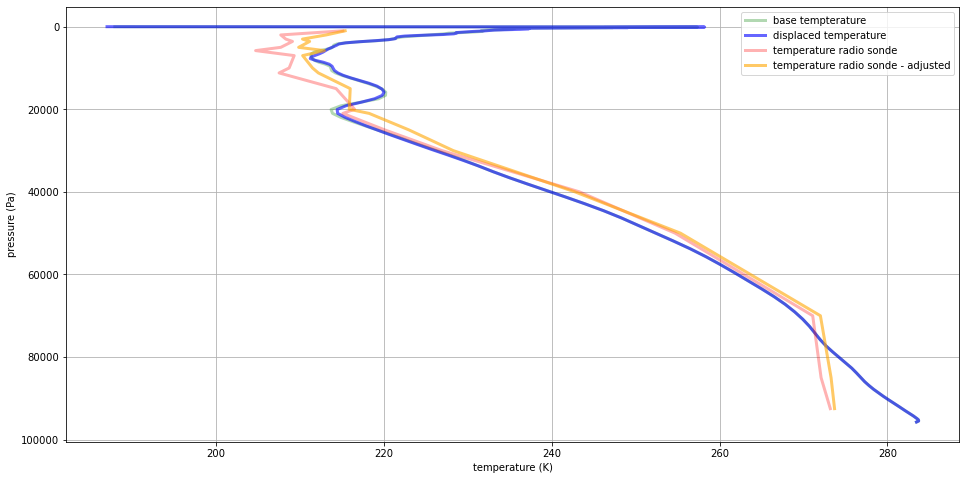

In [56]:
stat = '72357'
date_time = '2020-12-31 00:00:00'
statlist = glob.glob('/mnt/users/scratch/leo/scratch/converted_v7/*' + stat + '*_CEUAS_merged_v1.nc')
df = eua.CDMDataset(filename = statlist[0]).to_dataframe(groups=['observations_table', 'era5fb'], variables=['latitude', 'longitude', 'observed_variable', 'observation_value', 'z_coordinate', 'date_time', 'fg_depar@body', 'an_depar@body'])
test = df[df.date_time == date_time]

t = test[test.observed_variable == 85]
t = t.rename(columns={'observation_value':'temperature'})
t = t.drop(columns='observed_variable')

u = test[test.observed_variable == 104]
u = u.rename(columns={'observation_value':'u'})
u = u.drop(columns=['observed_variable', 'fg_depar@body', 'an_depar@body'])

v = test[test.observed_variable == 105]
v = v.rename(columns={'observation_value':'v'})
v = v.drop(columns=['observed_variable', 'fg_depar@body', 'an_depar@body'])

input_data = pd.merge(t, u, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])
input_data = pd.merge(input_data, v, on=['z_coordinate', 'latitude', 'longitude', 'date_time'])

input_data = input_data.dropna()
phys_model = trj.trajectory(lat=t.latitude.iloc[0], lon=t.longitude.iloc[0], temperature=np.array(input_data.temperature), u=np.array(input_data.u), v=np.array(input_data.v), pressure=np.array(input_data.z_coordinate))


input_data = input_data.reindex(index=input_data.index[::-1])
input_data['z'] = np.array(trj.calc_height(np.array(input_data.temperature), np.array(input_data.z_coordinate), jump=False))
input_data['calc_latd'] = np.array(phys_model[0])
input_data['calc_lond'] = np.array(phys_model[1])

test1 = [0] + list(input_data.calc_lond[:-1])
test2 = [0] + list(input_data.calc_latd[:-1])
input_data['prev_calc_lond']= test1
input_data['prev_calc_latd']= test2

input_data['lat_diff'] = np.array(input_data.calc_latd)- np.array(input_data.prev_calc_latd)
input_data['lon_diff'] = np.array(input_data.calc_lond)- np.array(input_data.prev_calc_lond)


input_data = input_data.dropna()


with open('model_dt_4s_reduced_prev.p', "rb") as input_file:
    model = pickle.load(input_file)
    
out = model.predict(input_data[['temperature', 'z_coordinate', 'u', 'v', 'z','latitude', 'longitude' , 'calc_latd', 'calc_lond', 'prev_calc_lond', 'prev_calc_latd', 'lon_diff', 'lat_diff']])

ml_latd, ml_lond = out.transpose()
input_data['ml_latd'] = ml_latd
input_data['ml_lond'] = ml_lond

input_data = input_data.reset_index()


ds = xr.load_dataset("./PROGRAMS/outputtest.grib")
ds_lnsp = xr.load_dataset("./PROGRAMS/outputtest_lnsp.grib")



igrib = '/scratch/das/mayerj47/era5_sh/lnspana/2020/LNSPANASH202012311700.grib'
f = open(igrib)
print(f)
msgid = codes_new_from_file(f, product_kind=CODES_PRODUCT_GRIB)
print(msgid)
pv = codes_get_array(msgid,'pv')

lnsp = float(ds_lnsp.sel(latitude=[input_data.latitude[0]], longitude=[input_data.longitude[0]], method="nearest").lnsp)
sp = np.exp(lnsp)

pv = np.array(pv)
a = pv[:int(len(pv)/2)]
b = pv[int(len(pv)/2):]

p_half = a + b * sp
base_t = ds.sel(latitude=[input_data.latitude[0]], longitude=[input_data.longitude[0]], method="nearest").t

t_list = []
for i in range(len(p_half[:-1])):
    step = find_nearest(input_data.z_coordinate, p_half[i])
    input_data_step = input_data[input_data.z_coordinate == step]
    station_lat = input_data.latitude[0] + np.array(input_data_step.ml_latd)[0]
#     print(station_lat)
    station_lon = input_data.longitude[0] + np.array(input_data_step.ml_lond)[0]

    ds_now = ds.sel(latitude=[station_lat], longitude=[station_lon], method="nearest")
#     print('selected lat: ', float(ds_now.latitude))
    t = ds_now.t
    t_list.append(np.array(t)[i][0][0])
print('lat: ', input_data.latitude[0], 'lon: ', input_data.longitude[0])
print(stat)
print(date_time)
fig, ax1 = maplt.subplots(1, figsize=(16, 8))
ax1.plot(np.squeeze(t), np.array(p_half[:-1]), color = 'green', alpha = 0.3, label='base tempterature')
ax1.plot(np.array(t_list), np.array(p_half[:-1]), color = 'blue', alpha = 0.6, label='displaced temperature')
ax1.plot(np.array(input_data.temperature), np.array(input_data.z_coordinate), color = 'red', alpha = 0.3, label='temperature radio sonde')
ax1.plot(np.array(input_data.temperature - input_data['fg_depar@body'] - input_data['an_depar@body'] ), np.array(input_data.z_coordinate), color = 'orange', alpha = 0.6, label='temperature radio sonde - adjusted')
ax1.set_ylabel('pressure (Pa)')
ax1.set_xlabel('temperature (K)')
ax1.tick_params(axis='y')
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.legend()
ax1.grid()